In [0]:
# 0) LOAD 2015 FEATURE-ENGINEERED OTPW DATASET

import pyspark.sql.functions as F

PATH = "dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay"

# Load correctly as Parquet
df = spark.read.parquet(PATH).cache()

print(f"Rows: {df.count():,} | Cols: {len(df.columns)}")
df.printSchema()

# =========================================
# 1) CREATE REQUIRED SLICES
#    - Full-year (already the dataset)
#    - 3-month slice (Jan–Mar 2015)
# =========================================

# Full-year OTPW slice (just rename for clarity)
otpw_full_df = df

# 3-month slice required by rubric (Jan–Mar 2015)
otpw_3m_df = (
    df.filter(
        (F.col("FL_DATE") >= F.lit("2015-01-01")) &
        (F.col("FL_DATE") <  F.lit("2015-04-01"))
    )
    .cache()
)

print("3-month rows:", otpw_3m_df.count())
otpw_3m_df.select(F.min("FL_DATE"), F.max("FL_DATE")).show()


Rows: 5,704,114 | Cols: 105
root
 |-- FL_DATE: date (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlyWin


GENERATING FIXED VISUALIZATIONS

1) Creating Missingness Overview...


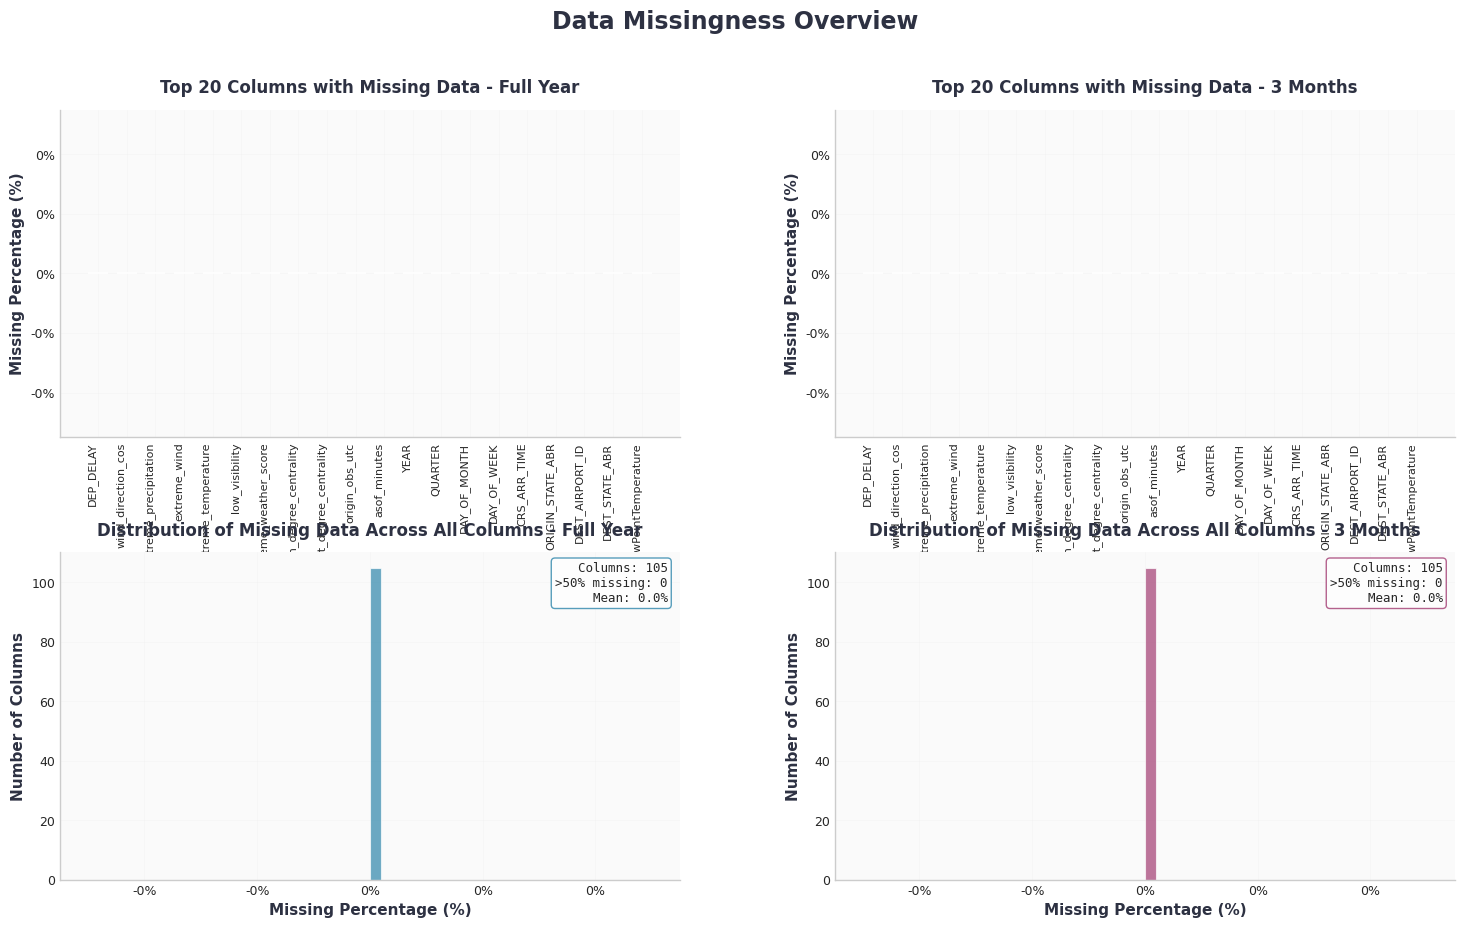


2) Creating Key Feature Distributions...
Found 1 of 12 requested features
Sampling 2.0% of data for feature distributions...
  Plotting 1/1: asof_minutes


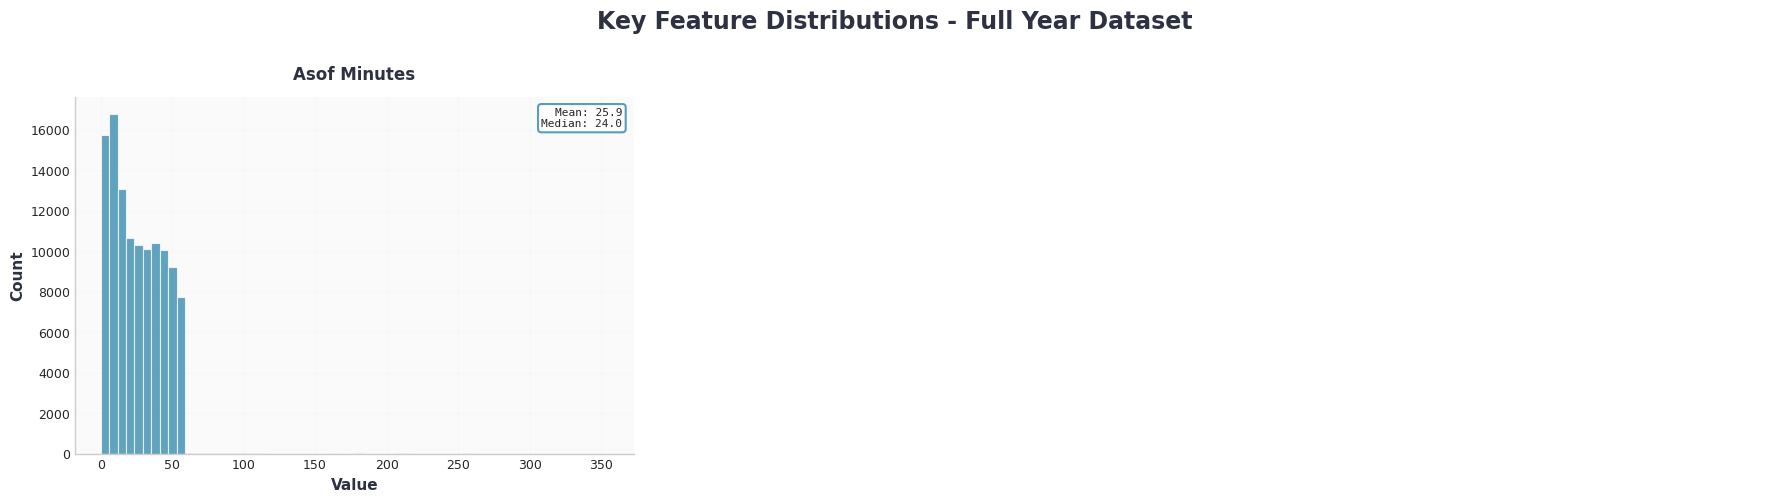


FIXED VISUALIZATIONS COMPLETE!
Saved to: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/combined


In [0]:
# ============================================================
# FIXED VISUALIZATIONS WITH BETTER LAYOUTS
# ============================================================

import os, math, json
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Enhanced styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#06A77D',
    'warning': '#F18F01',
    'danger': '#D00000',
    'grid': '#E8E8E8',
    'text': '#2D3142',
    'background': '#FAFAFA',
    'gradient': ['#2E86AB', '#5FA8D3', '#A23B72', '#F18F01', '#D00000', '#06A77D']
}

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 15,
    'figure.titleweight': 'bold'
})

def format_number(x, pos=None):
    """Format numbers with K/M suffixes"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{int(x)}'

def style_axis(ax, title=None, xlabel=None, ylabel=None):
    """Apply consistent styling to axis"""
    ax.set_facecolor(COLORS['background'])
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color=COLORS['grid'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    
    if title:
        ax.set_title(title, fontweight='bold', color=COLORS['text'], pad=12)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='semibold', color=COLORS['text'])
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='semibold', color=COLORS['text'])

# -----------------------------
# 1) FIXED MISSINGNESS OVERVIEW
# -----------------------------
def plot_missingness_overview_fixed(df_full, df_3m, filename, top_n=20):
    """Improved missingness visualization with better spacing"""
    
    def get_missingness(df):
        total = df.count()
        miss = df.select([
            (F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)) / total).alias(c)
            for c in df.columns
        ]).toPandas().T.reset_index()
        miss.columns = ["column", "missing_pct"]
        miss["missing_pct"] = miss["missing_pct"] * 100
        return miss.sort_values("missing_pct", ascending=False)
    
    miss_full = get_missingness(df_full)
    miss_3m = get_missingness(df_3m)
    
    # Create figure with better proportions
    fig = plt.figure(figsize=(18, 10), facecolor='white')
    gs = GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.25)
    
    # --- TOP ROW: Vertical bar charts (easier to read labels) ---
    ax1 = fig.add_subplot(gs[0, 0])
    top_full = miss_full.head(top_n)
    x_pos = np.arange(len(top_full))
    bars1 = ax1.bar(x_pos, top_full["missing_pct"], 
                    color=COLORS['primary'], alpha=0.8, 
                    edgecolor='white', linewidth=1.5, width=0.7)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(top_full["column"], rotation=90, ha='right', fontsize=8)
    style_axis(ax1, 
               title=f'Top {top_n} Columns with Missing Data - Full Year',
               xlabel='',
               ylabel='Missing Percentage (%)')
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    # Add value labels on top of bars
    for bar, val in zip(bars1, top_full["missing_pct"]):
        height = bar.get_height()
        if height > 5:  # Only label if bar is tall enough
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%', ha='center', va='bottom', 
                    fontsize=7, fontweight='bold', color=COLORS['text'])
    
    ax2 = fig.add_subplot(gs[0, 1])
    top_3m = miss_3m.head(top_n)
    x_pos2 = np.arange(len(top_3m))
    bars2 = ax2.bar(x_pos2, top_3m["missing_pct"], 
                    color=COLORS['secondary'], alpha=0.8, 
                    edgecolor='white', linewidth=1.5, width=0.7)
    ax2.set_xticks(x_pos2)
    ax2.set_xticklabels(top_3m["column"], rotation=90, ha='right', fontsize=8)
    style_axis(ax2, 
               title=f'Top {top_n} Columns with Missing Data - 3 Months',
               xlabel='',
               ylabel='Missing Percentage (%)')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    for bar, val in zip(bars2, top_3m["missing_pct"]):
        height = bar.get_height()
        if height > 5:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%', ha='center', va='bottom', 
                    fontsize=7, fontweight='bold', color=COLORS['text'])
    
    # --- BOTTOM ROW: Distribution histograms ---
    ax3 = fig.add_subplot(gs[1, 0])
    n3, bins3, patches3 = ax3.hist(miss_full["missing_pct"], bins=50, 
                                    color=COLORS['primary'], alpha=0.7, 
                                    edgecolor='white', linewidth=0.8)
    style_axis(ax3, 
               title='Distribution of Missing Data Across All Columns - Full Year',
               xlabel='Missing Percentage (%)',
               ylabel='Number of Columns')
    ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
    ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    # Add summary statistics text
    stats_text = f'Columns: {len(miss_full)}\n>50% missing: {(miss_full["missing_pct"] > 50).sum()}\nMean: {miss_full["missing_pct"].mean():.1f}%'
    ax3.text(0.98, 0.97, stats_text, transform=ax3.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=COLORS['primary']),
            fontsize=9, fontfamily='monospace')
    
    ax4 = fig.add_subplot(gs[1, 1])
    n4, bins4, patches4 = ax4.hist(miss_3m["missing_pct"], bins=50, 
                                    color=COLORS['secondary'], alpha=0.7, 
                                    edgecolor='white', linewidth=0.8)
    style_axis(ax4, 
               title='Distribution of Missing Data Across All Columns - 3 Months',
               xlabel='Missing Percentage (%)',
               ylabel='Number of Columns')
    ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
    ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    stats_text2 = f'Columns: {len(miss_3m)}\n>50% missing: {(miss_3m["missing_pct"] > 50).sum()}\nMean: {miss_3m["missing_pct"].mean():.1f}%'
    ax4.text(0.98, 0.97, stats_text2, transform=ax4.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=COLORS['secondary']),
            fontsize=9, fontfamily='monospace')
    
    fig.suptitle('Data Missingness Overview', fontsize=17, fontweight='bold', 
                 color=COLORS['text'], y=0.98)
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', 
                facecolor='white', pad_inches=0.2)
    plt.show()
    
    return miss_full, miss_3m

# -----------------------------
# 2) FIXED KEY FEATURE DISTRIBUTIONS
# -----------------------------
def plot_key_features_grid_fixed(df, filename, features, ncols=3, sample_frac=0.02):
    """Fixed feature distribution grid with proper subplot handling"""
    
    # Filter to only features that exist in the dataframe
    valid_features = [f for f in features if f in df.columns]
    
    if not valid_features:
        print("Warning: None of the specified features exist in the dataframe")
        return
    
    nrows = math.ceil(len(valid_features) / ncols)
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5*nrows), facecolor='white')
    
    # Flatten axes array for easier iteration
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Sample data once
    print(f"Sampling {sample_frac*100}% of data for feature distributions...")
    samp = df.sample(sample_frac, seed=42).cache()
    
    # Plot each feature
    for idx, feature in enumerate(valid_features):
        ax = axes[idx]
        
        print(f"  Plotting {idx+1}/{len(valid_features)}: {feature}")
        
        # Get data for this feature
        pd_feat = samp.select(feature).dropna().toPandas()
        
        if not pd_feat.empty and len(pd_feat) > 10:
            # Choose color from gradient
            color = COLORS['gradient'][idx % len(COLORS['gradient'])]
            
            # Plot histogram
            n, bins, patches = ax.hist(
                pd_feat[feature], 
                bins=min(60, len(pd_feat) // 10),  # Adaptive bins
                color=color,
                alpha=0.75,
                edgecolor='white',
                linewidth=0.8
            )
            
            # Style the axis
            clean_name = feature.replace('_', ' ').title()
            style_axis(ax, 
                      title=clean_name,
                      xlabel='Value',
                      ylabel='Count')
            
            # Add statistics box
            mean_val = pd_feat[feature].mean()
            median_val = pd_feat[feature].median()
            stats_text = f'Mean: {mean_val:.1f}\nMedian: {median_val:.1f}'
            ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                            edgecolor=color, linewidth=1.5),
                   fontsize=8, fontfamily='monospace')
            
        else:
            # No data - show message
            ax.text(0.5, 0.5, f'No data available\nfor {feature}', 
                   ha='center', va='center', 
                   transform=ax.transAxes, fontsize=11, color='gray',
                   bbox=dict(boxstyle='round', facecolor=COLORS['background'], 
                            alpha=0.5, edgecolor='gray', linestyle='--'))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # Hide unused subplots
    for idx in range(len(valid_features), len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    fig.suptitle('Key Feature Distributions - Full Year Dataset', 
                 fontsize=17, fontweight='bold', 
                 color=COLORS['text'], y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', 
                facecolor='white', pad_inches=0.2)
    plt.show()
    
    # Clean up
    samp.unpersist()

# -----------------------------
# 3) GENERATE FIXED VISUALIZATIONS
# -----------------------------
print("\n" + "="*80)
print("GENERATING FIXED VISUALIZATIONS")
print("="*80 + "\n")

# Missingness Overview (Fixed)
print("1) Creating Missingness Overview...")
miss_full, miss_3m = plot_missingness_overview_fixed(
    otpw_full_df, otpw_3m_df, 
    "missingness_overview_fixed.png",
    top_n=20  # Show top 20 for better readability
)

# Key Feature Distributions (Fixed)
print("\n2) Creating Key Feature Distributions...")
key_features = [
    'CRS_ELAPSED_TIME', 'DISTANCE', 'asof_minutes',
    'origin_avg_delay_3h', 'dest_avg_delay_3h',
    'carrier_avg_delay_24h', 'route_avg_delay_7d',
    'origin_temp', 'origin_wind_speed', 'origin_visibility',
    'dest_precip_3h', 'dest_cloud_coverage'
]

# Filter to existing features
existing_features = [f for f in key_features if f in otpw_full_df.columns]
print(f"Found {len(existing_features)} of {len(key_features)} requested features")

if existing_features:
    plot_key_features_grid_fixed(
        otpw_full_df, 
        "key_features_grid_fixed.png",
        existing_features,
        ncols=3,  # 3 columns for better readability
        sample_frac=0.02
    )
else:
    print("WARNING: No key features found in dataset!")
    print("Available numeric columns:", NUM_COLS[:20])

print("\n" + "="*80)
print("FIXED VISUALIZATIONS COMPLETE!")
print(f"Saved to: {COMBINED_DIR}")
print("="*80)

Rows: 5,704,114 | Cols: 105
Full-year rows: 5704114
3-month rows: 1354285

GENERATING COMBINED VISUALIZATIONS

1/5: Missingness Overview...


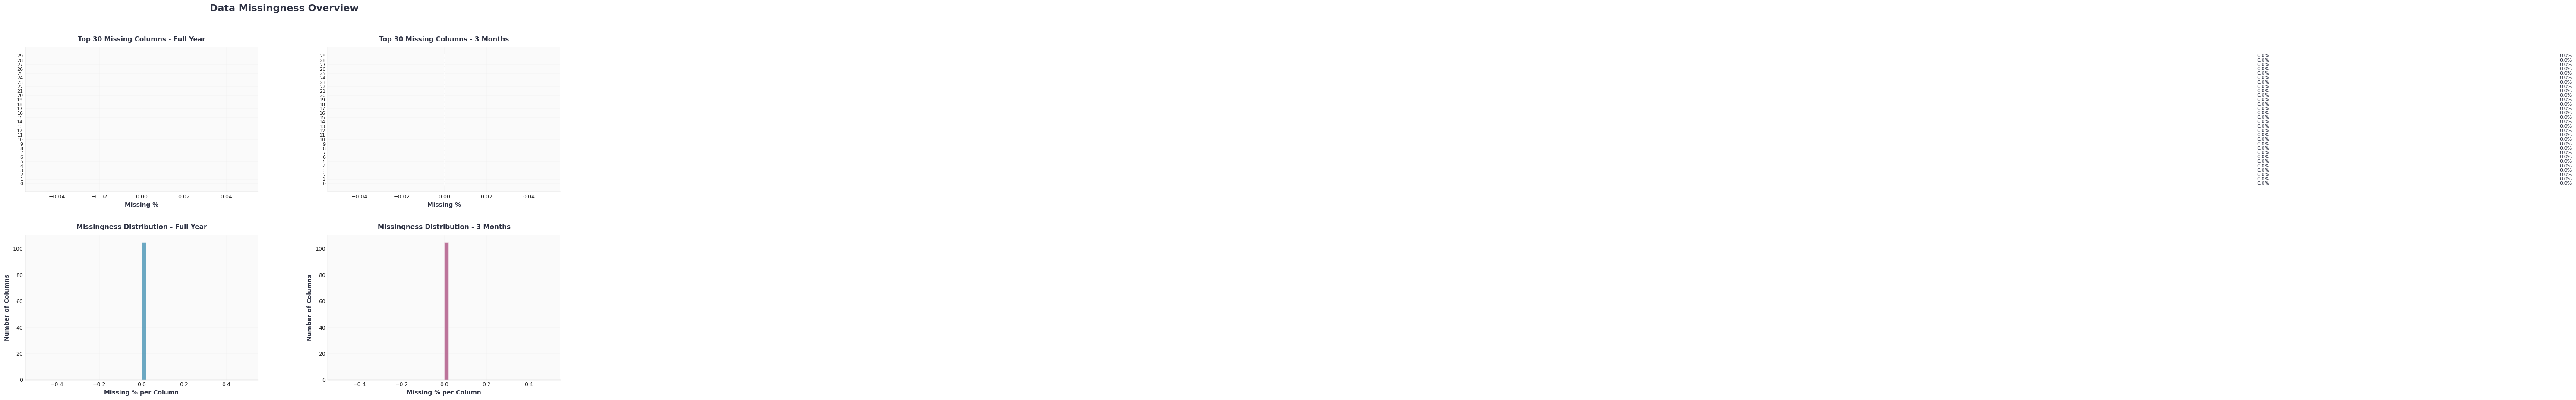

2/5: Target Variable Overview...


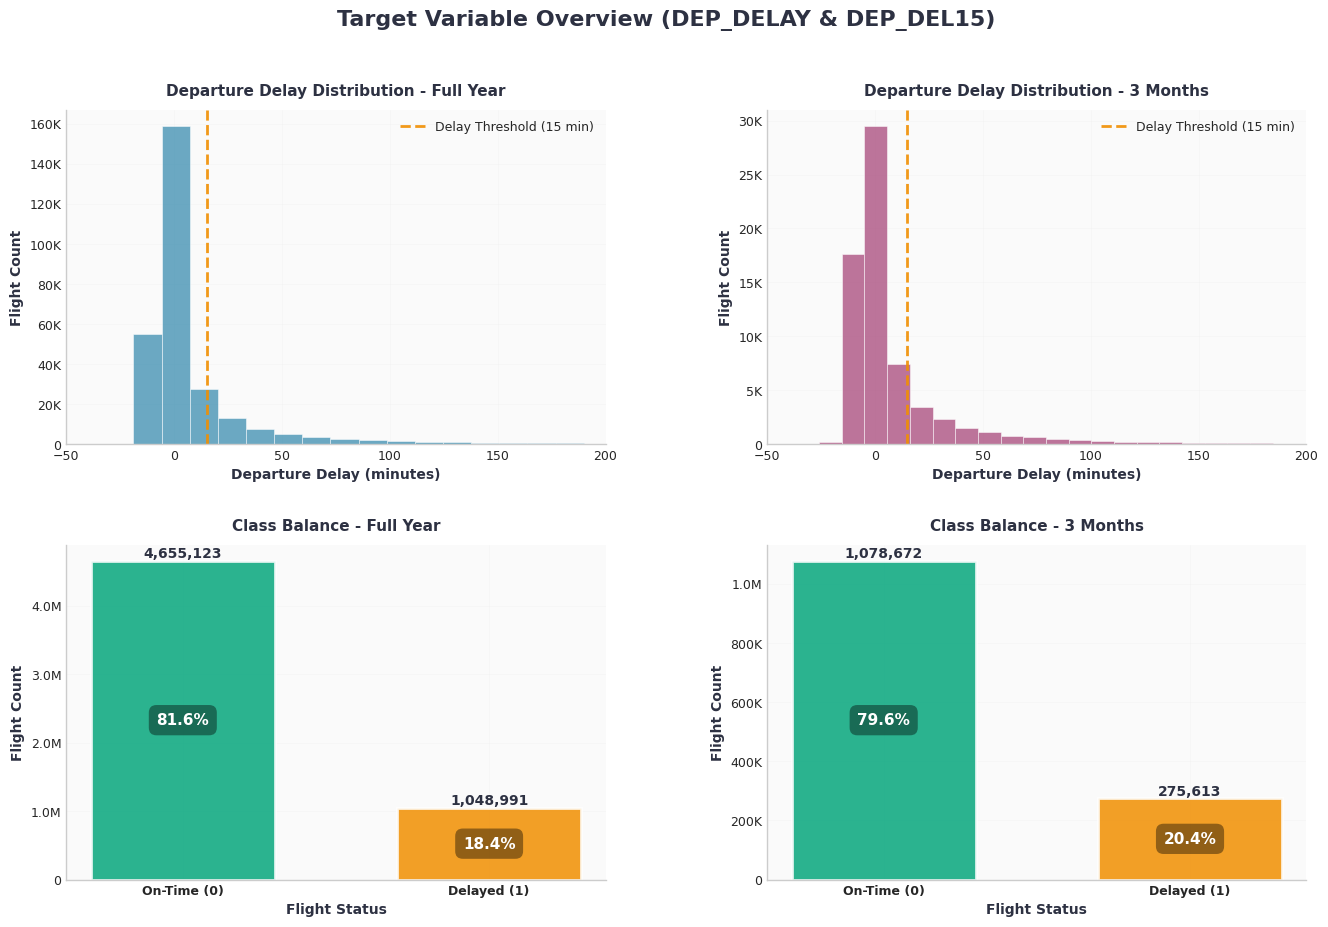

3/5: Key Feature Distributions...


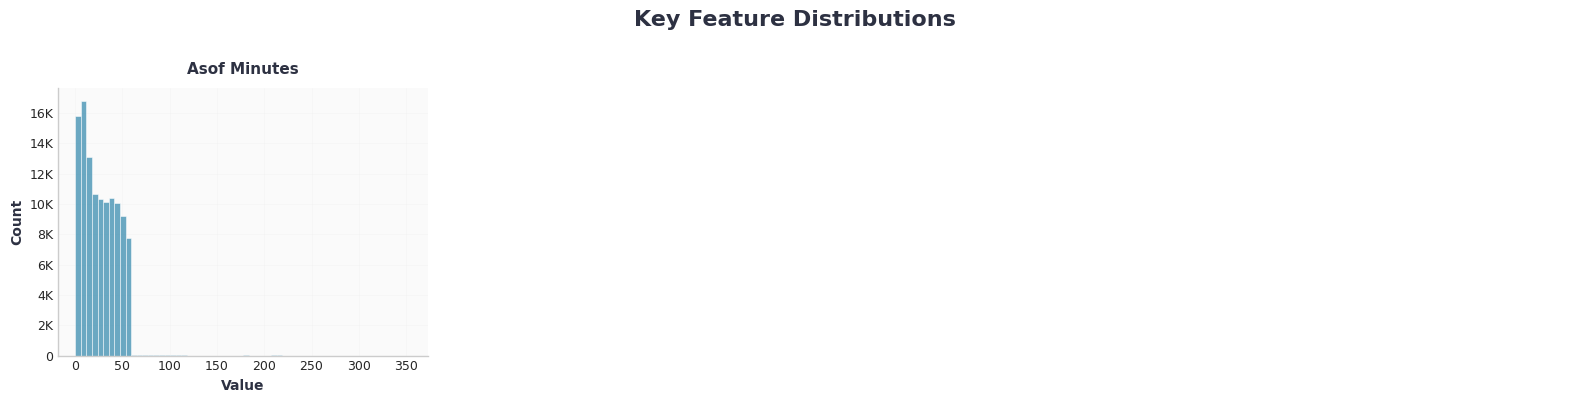

4/5: Delay Pattern Analysis...


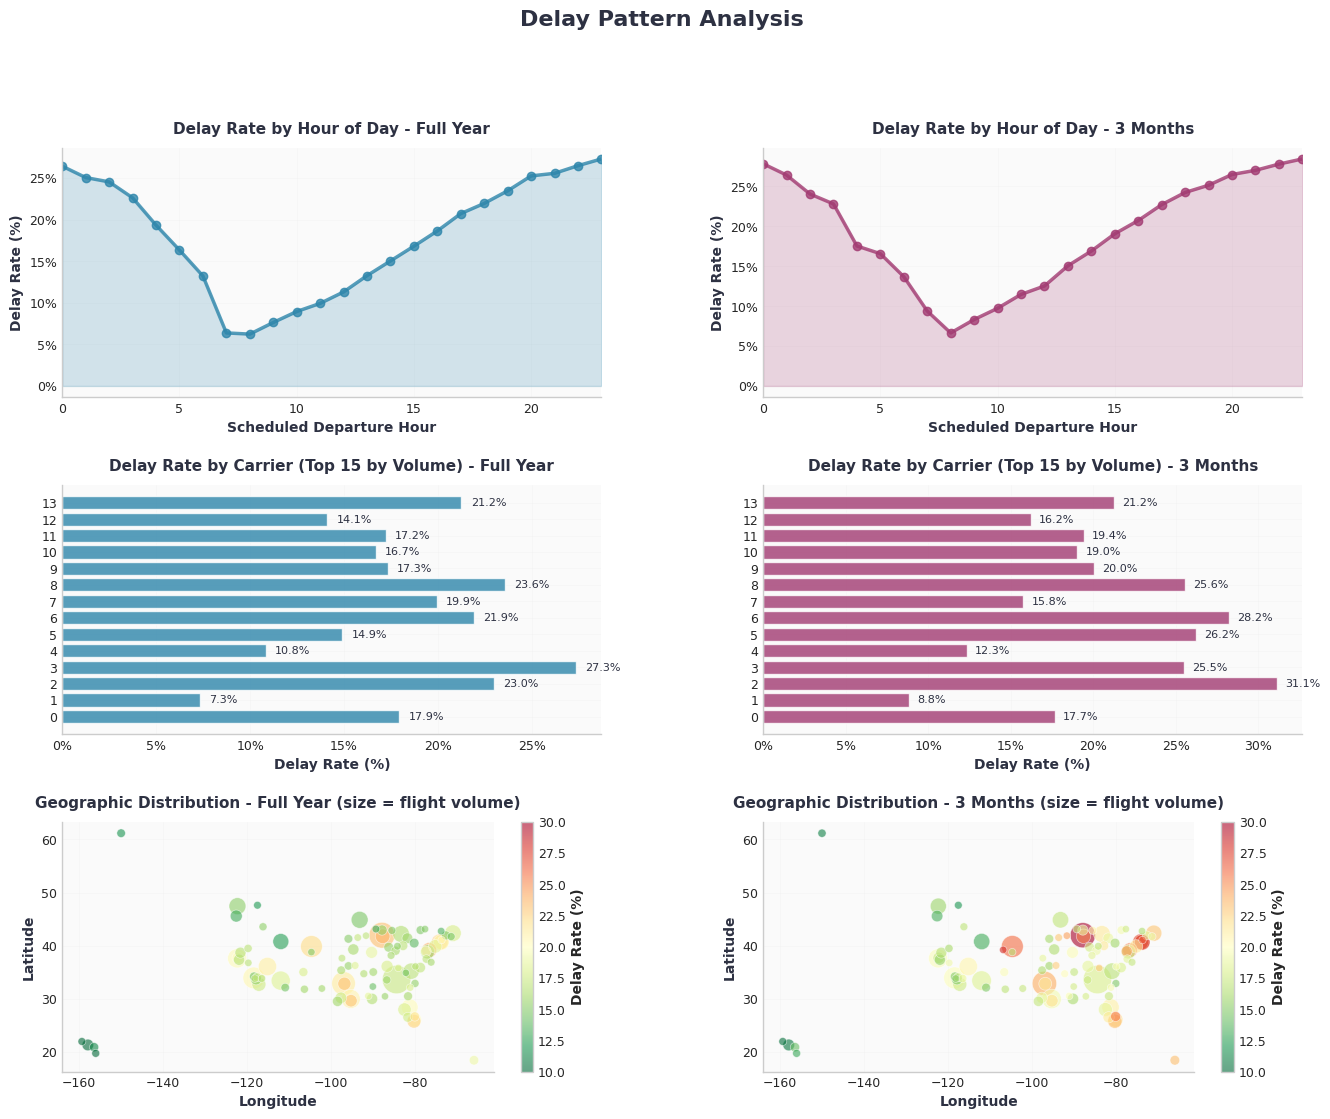

5/5: Correlation Analysis...


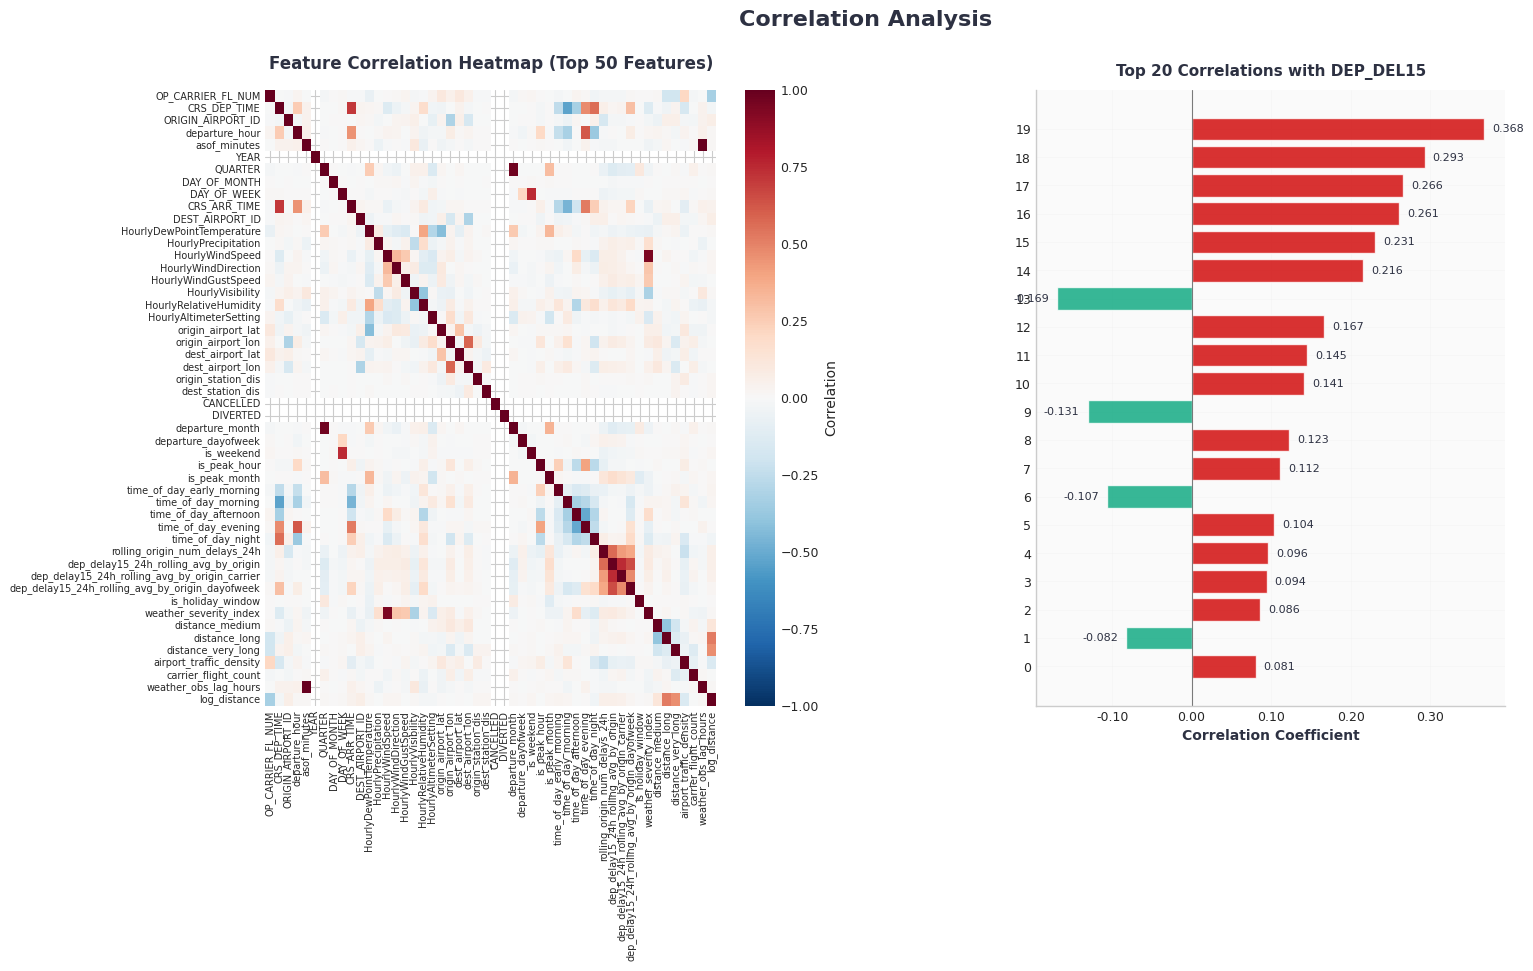


ALL VISUALIZATIONS COMPLETE!
Saved to: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/combined

Top 10 Most Correlated Features with DEP_DEL15:


feature correlation abs_corr prev_flight_dep_del15 0.36806405335409687 0.36806405335409687 prior_day_delay_rate 0.29310265058504176 0.29310265058504176 dep_delay15_24h_rolling_avg_by_origin_dayofweek 0.2662781683105991 0.2662781683105991 num_airport_wide_delays 0.26131352469490865 0.26131352469490865 dep_delay15_24h_rolling_avg_by_origin_carrier 0.23105721354622513 0.23105721354622513 dep_delay15_24h_rolling_avg_by_origin 0.2162420787703582 0.2162420787703582 dep_time_sin -0.16919449003581052 0.16919449003581052 CRS_DEP_TIME 0.16679367330916484 0.16679367330916484 arr_time_cos 0.14496629936665933 0.14496629936665933 CRS_ARR_TIME 0.14119608219995888 0.14119608219995888


Missingness Summary:
Full Year - Columns with >50% missing: 0
3 Months - Columns with >50% missing: 0


In [0]:
# ============================================================
# PHASE 2 EDA — ENHANCED COMBINED VISUALIZATIONS
# Dataset: 2015_final_feature_engineered_data_with_dep_delay
# ============================================================

import os, math, json, textwrap
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# -----------------------------
# ENHANCED STYLING CONFIGURATION
# -----------------------------
COLORS = {
    'primary': '#2E86AB',      # Professional blue
    'secondary': '#A23B72',    # Accent purple
    'success': '#06A77D',      # Green for on-time
    'warning': '#F18F01',      # Orange for delayed
    'danger': '#D00000',       # Red for high delays
    'grid': '#E8E8E8',         # Light grid
    'text': '#2D3142',         # Dark text
    'background': '#FAFAFA',   # Subtle background
    'gradient': ['#2E86AB', '#5FA8D3', '#A23B72', '#F18F01', '#D00000']
}

# Set matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'figure.titleweight': 'bold'
})

def format_number(x, pos=None):
    """Format numbers with K/M suffixes"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{int(x)}'

def style_axis(ax, title=None, xlabel=None, ylabel=None):
    """Apply consistent styling to axis"""
    ax.set_facecolor(COLORS['background'])
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color=COLORS['grid'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    
    if title:
        ax.set_title(title, fontweight='bold', color=COLORS['text'], pad=10)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='semibold', color=COLORS['text'])
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='semibold', color=COLORS['text'])
    
    # Format y-axis with K/M
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_number))

# -----------------------------
# DATA LOADING
# -----------------------------
PATH = "dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay"
df = spark.read.parquet(PATH).cache()
print(f"Rows: {df.count():,} | Cols: {len(df.columns)}")

otpw_full_df = df.cache()
otpw_3m_df = df.filter(
    (F.col("FL_DATE") >= F.lit("2015-01-01")) &
    (F.col("FL_DATE") <  F.lit("2015-04-01"))
).cache()

print("Full-year rows:", otpw_full_df.count())
print("3-month rows:", otpw_3m_df.count())

# Save directories
BASE_LOCAL = "/dbfs/student-groups/Group_4_4/Charts/phase2_eda"
FULL_DIR = f"{BASE_LOCAL}/full"
M3_DIR = f"{BASE_LOCAL}/3m"
COMBINED_DIR = f"{BASE_LOCAL}/combined"
os.makedirs(FULL_DIR, exist_ok=True)
os.makedirs(M3_DIR, exist_ok=True)
os.makedirs(COMBINED_DIR, exist_ok=True)

TARGET_NUM = "DEP_DELAY"
TARGET_BIN = "DEP_DEL15"

# Get feature columns
def get_numeric_cols(df, exclude=set()):
    return [c for c, t in df.dtypes
            if t in ("int", "bigint", "double", "float", "long") and c not in exclude]

def get_categorical_cols(df, exclude=set(), max_card=60):
    cats = []
    for c, t in df.dtypes:
        if t == "string" and c not in exclude:
            card = df.select(c).distinct().count()
            if card <= max_card:
                cats.append(c)
    return cats

exclude_features = {TARGET_NUM, TARGET_BIN}
NUM_COLS = get_numeric_cols(otpw_full_df, exclude_features)
CAT_COLS = get_categorical_cols(otpw_full_df, exclude_features)

# -----------------------------
# 1) COMBINED MISSINGNESS OVERVIEW
# -----------------------------
def plot_missingness_overview(df_full, df_3m, filename, top_n=30):
    """Combined missingness visualization: bar chart + distribution"""
    
    def get_missingness(df):
        total = df.count()
        miss = df.select([
            (F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)) / total).alias(c)
            for c in df.columns
        ]).toPandas().T.reset_index()
        miss.columns = ["column", "missing_pct"]
        miss["missing_pct"] = miss["missing_pct"] * 100
        return miss.sort_values("missing_pct", ascending=False)
    
    miss_full = get_missingness(df_full)
    miss_3m = get_missingness(df_3m)
    
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Top: Bar charts of top missing columns
    ax1 = fig.add_subplot(gs[0, 0])
    top_full = miss_full.head(top_n)
    bars1 = ax1.barh(range(len(top_full)), top_full["missing_pct"][::-1], 
                     color=COLORS['primary'], alpha=0.8, edgecolor='white', linewidth=1)
    ax1.set_yticks(range(len(top_full)))
    ax1.set_yticklabels(top_full["column"][::-1], fontsize=8)
    style_axis(ax1, 
               title=f'Top {top_n} Missing Columns - Full Year',
               xlabel='Missing %',
               ylabel='')
    # Add percentage labels
    for i, (bar, val) in enumerate(zip(bars1, top_full["missing_pct"][::-1])):
        ax1.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8, color=COLORS['text'])
    
    ax2 = fig.add_subplot(gs[0, 1])
    top_3m = miss_3m.head(top_n)
    bars2 = ax2.barh(range(len(top_3m)), top_3m["missing_pct"][::-1], 
                     color=COLORS['secondary'], alpha=0.8, edgecolor='white', linewidth=1)
    ax2.set_yticks(range(len(top_3m)))
    ax2.set_yticklabels(top_3m["column"][::-1], fontsize=8)
    style_axis(ax2, 
               title=f'Top {top_n} Missing Columns - 3 Months',
               xlabel='Missing %',
               ylabel='')
    for i, (bar, val) in enumerate(zip(bars2, top_3m["missing_pct"][::-1])):
        ax2.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8, color=COLORS['text'])
    
    # Bottom: Distribution histograms
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(miss_full["missing_pct"], bins=50, color=COLORS['primary'], 
             alpha=0.7, edgecolor='white', linewidth=0.5)
    style_axis(ax3, 
               title='Missingness Distribution - Full Year',
               xlabel='Missing % per Column',
               ylabel='Number of Columns')
    ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(miss_3m["missing_pct"], bins=50, color=COLORS['secondary'], 
             alpha=0.7, edgecolor='white', linewidth=0.5)
    style_axis(ax4, 
               title='Missingness Distribution - 3 Months',
               xlabel='Missing % per Column',
               ylabel='Number of Columns')
    ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
    
    fig.suptitle('Data Missingness Overview', fontsize=16, fontweight='bold', 
                 color=COLORS['text'], y=0.98)
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    return miss_full, miss_3m

# -----------------------------
# 2) COMBINED TARGET DISTRIBUTIONS
# -----------------------------
def plot_target_overview(df_full, df_3m, filename, sample_frac=0.05):
    """Combined target variable analysis"""
    
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Sample data for histograms
    pd_full_delay = df_full.select(TARGET_NUM).dropna().sample(sample_frac, seed=42).toPandas()
    pd_3m_delay = df_3m.select(TARGET_NUM).dropna().sample(sample_frac, seed=42).toPandas()
    
    # Top row: DEP_DELAY histograms
    ax1 = fig.add_subplot(gs[0, 0])
    n1, bins1, patches1 = ax1.hist(pd_full_delay[TARGET_NUM], bins=120, 
                                    color=COLORS['primary'], alpha=0.7, 
                                    edgecolor='white', linewidth=0.5)
    ax1.axvline(x=15, color=COLORS['warning'], linestyle='--', linewidth=2, 
                label='Delay Threshold (15 min)', alpha=0.9)
    style_axis(ax1, 
               title='Departure Delay Distribution - Full Year',
               xlabel='Departure Delay (minutes)',
               ylabel='Flight Count')
    ax1.legend(loc='upper right', framealpha=0.9)
    ax1.set_xlim(-50, 200)  # Focus on main distribution
    
    ax2 = fig.add_subplot(gs[0, 1])
    n2, bins2, patches2 = ax2.hist(pd_3m_delay[TARGET_NUM], bins=120, 
                                    color=COLORS['secondary'], alpha=0.7, 
                                    edgecolor='white', linewidth=0.5)
    ax2.axvline(x=15, color=COLORS['warning'], linestyle='--', linewidth=2, 
                label='Delay Threshold (15 min)', alpha=0.9)
    style_axis(ax2, 
               title='Departure Delay Distribution - 3 Months',
               xlabel='Departure Delay (minutes)',
               ylabel='Flight Count')
    ax2.legend(loc='upper right', framealpha=0.9)
    ax2.set_xlim(-50, 200)
    
    # Bottom row: DEP_DEL15 class balance
    pdf_full_bal = df_full.groupBy(TARGET_BIN).count().orderBy(TARGET_BIN).toPandas()
    pdf_3m_bal = df_3m.groupBy(TARGET_BIN).count().orderBy(TARGET_BIN).toPandas()
    
    bar_colors = [COLORS['success'], COLORS['warning']]
    labels = ['On-Time (0)', 'Delayed (1)']
    
    ax3 = fig.add_subplot(gs[1, 0])
    x_pos = range(len(pdf_full_bal))
    bars3 = ax3.bar(x_pos, pdf_full_bal["count"], color=bar_colors, 
                    alpha=0.85, edgecolor='white', linewidth=2, width=0.6)
    
    # Add value and percentage labels
    total_full = pdf_full_bal["count"].sum()
    for i, (bar, count) in enumerate(zip(bars3, pdf_full_bal["count"])):
        pct = (count / total_full) * 100
        # Value on top
        ax3.text(bar.get_x() + bar.get_width() / 2., count, 
                f'{int(count):,}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color=COLORS['text'])
        # Percentage inside
        ax3.text(bar.get_x() + bar.get_width() / 2., count * 0.5,
                f'{pct:.1f}%', ha='center', va='center',
                fontsize=11, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         alpha=0.4, edgecolor='none'))
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(labels, fontweight='semibold')
    style_axis(ax3, 
               title='Class Balance - Full Year',
               xlabel='Flight Status',
               ylabel='Flight Count')
    
    ax4 = fig.add_subplot(gs[1, 1])
    bars4 = ax4.bar(x_pos, pdf_3m_bal["count"], color=bar_colors, 
                    alpha=0.85, edgecolor='white', linewidth=2, width=0.6)
    
    total_3m = pdf_3m_bal["count"].sum()
    for i, (bar, count) in enumerate(zip(bars4, pdf_3m_bal["count"])):
        pct = (count / total_3m) * 100
        ax4.text(bar.get_x() + bar.get_width() / 2., count, 
                f'{int(count):,}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color=COLORS['text'])
        ax4.text(bar.get_x() + bar.get_width() / 2., count * 0.5,
                f'{pct:.1f}%', ha='center', va='center',
                fontsize=11, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         alpha=0.4, edgecolor='none'))
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(labels, fontweight='semibold')
    style_axis(ax4, 
               title='Class Balance - 3 Months',
               xlabel='Flight Status',
               ylabel='Flight Count')
    
    fig.suptitle('Target Variable Overview (DEP_DELAY & DEP_DEL15)', 
                 fontsize=16, fontweight='bold', color=COLORS['text'], y=0.98)
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# -----------------------------
# 3) KEY FEATURE DISTRIBUTIONS (GRID)
# -----------------------------
def plot_key_features_grid(df, filename, features, ncols=4, sample_frac=0.02):
    """Plot multiple feature distributions in a grid"""
    
    nrows = math.ceil(len(features) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows), facecolor='white')
    axes = axes.flatten() if nrows > 1 or ncols > 1 else [axes]
    
    samp = df.sample(sample_frac, seed=42)
    
    for idx, feature in enumerate(features):
        ax = axes[idx]
        pd_feat = samp.select(feature).dropna().toPandas()
        
        if not pd_feat.empty:
            ax.hist(pd_feat[feature], bins=60, color=COLORS['gradient'][idx % len(COLORS['gradient'])], 
                   alpha=0.7, edgecolor='white', linewidth=0.5)
            style_axis(ax, 
                      title=feature.replace('_', ' ').title(),
                      xlabel='Value',
                      ylabel='Count')
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12, color='gray')
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Hide extra subplots
    for idx in range(len(features), len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle('Key Feature Distributions', fontsize=16, fontweight='bold', 
                 color=COLORS['text'], y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# -----------------------------
# 4) DELAY PATTERNS OVERVIEW
# -----------------------------
def plot_delay_patterns(df_full, df_3m, filename):
    """Combined delay pattern analysis: by hour, category, and geography"""
    
    fig = plt.figure(figsize=(16, 12), facecolor='white')
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    # --- Row 1: Delay by Hour ---
    def get_hourly_delay(df, hour_col):
        if hour_col in df.columns:
            tmp = df.withColumn("dep_hour", F.col(hour_col))
        else:
            tmp = df.withColumn("dep_hour", (F.col("CRS_DEP_TIME")/100).cast("int"))
        
        return tmp.groupBy("dep_hour").agg(
            F.count("*").alias("n"),
            F.mean(TARGET_BIN).alias("delay_rate")
        ).orderBy("dep_hour").toPandas()
    
    pd_hour_full = get_hourly_delay(df_full, "departure_hour")
    pd_hour_3m = get_hourly_delay(df_3m, "departure_hour")
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(pd_hour_full["dep_hour"], pd_hour_full["delay_rate"]*100, 
            marker='o', linewidth=2.5, markersize=6, color=COLORS['primary'], alpha=0.8)
    ax1.fill_between(pd_hour_full["dep_hour"], 0, pd_hour_full["delay_rate"]*100, 
                     alpha=0.2, color=COLORS['primary'])
    style_axis(ax1, 
               title='Delay Rate by Hour of Day - Full Year',
               xlabel='Scheduled Departure Hour',
               ylabel='Delay Rate (%)')
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    ax1.set_xlim(0, 23)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(pd_hour_3m["dep_hour"], pd_hour_3m["delay_rate"]*100, 
            marker='o', linewidth=2.5, markersize=6, color=COLORS['secondary'], alpha=0.8)
    ax2.fill_between(pd_hour_3m["dep_hour"], 0, pd_hour_3m["delay_rate"]*100, 
                     alpha=0.2, color=COLORS['secondary'])
    style_axis(ax2, 
               title='Delay Rate by Hour of Day - 3 Months',
               xlabel='Scheduled Departure Hour',
               ylabel='Delay Rate (%)')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    ax2.set_xlim(0, 23)
    
    # --- Row 2: Delay by Carrier ---
    pd_carrier_full = (df_full.groupBy("OP_UNIQUE_CARRIER")
                       .agg(F.count("*").alias("n"),
                            F.mean(TARGET_BIN).alias("delay_rate"))
                       .orderBy(F.desc("n"))
                       .limit(15)
                       .toPandas())
    
    pd_carrier_3m = (df_3m.groupBy("OP_UNIQUE_CARRIER")
                     .agg(F.count("*").alias("n"),
                          F.mean(TARGET_BIN).alias("delay_rate"))
                     .orderBy(F.desc("n"))
                     .limit(15)
                     .toPandas())
    
    ax3 = fig.add_subplot(gs[1, 0])
    bars3 = ax3.barh(range(len(pd_carrier_full)), pd_carrier_full["delay_rate"][::-1]*100,
                    color=COLORS['primary'], alpha=0.8, edgecolor='white', linewidth=1)
    ax3.set_yticks(range(len(pd_carrier_full)))
    ax3.set_yticklabels(pd_carrier_full["OP_UNIQUE_CARRIER"][::-1], fontsize=9)
    style_axis(ax3, 
               title='Delay Rate by Carrier (Top 15 by Volume) - Full Year',
               xlabel='Delay Rate (%)',
               ylabel='')
    ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    for i, (bar, val) in enumerate(zip(bars3, pd_carrier_full["delay_rate"][::-1]*100)):
        ax3.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8, color=COLORS['text'])
    
    ax4 = fig.add_subplot(gs[1, 1])
    bars4 = ax4.barh(range(len(pd_carrier_3m)), pd_carrier_3m["delay_rate"][::-1]*100,
                    color=COLORS['secondary'], alpha=0.8, edgecolor='white', linewidth=1)
    ax4.set_yticks(range(len(pd_carrier_3m)))
    ax4.set_yticklabels(pd_carrier_3m["OP_UNIQUE_CARRIER"][::-1], fontsize=9)
    style_axis(ax4, 
               title='Delay Rate by Carrier (Top 15 by Volume) - 3 Months',
               xlabel='Delay Rate (%)',
               ylabel='')
    ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    for i, (bar, val) in enumerate(zip(bars4, pd_carrier_3m["delay_rate"][::-1]*100)):
        ax4.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8, color=COLORS['text'])
    
    # --- Row 3: Geographic Distribution ---
    pd_geo_full = (df_full.groupBy("ORIGIN", "origin_airport_lat", "origin_airport_lon")
                   .agg(F.count("*").alias("n"),
                        F.mean(TARGET_BIN).alias("delay_rate"))
                   .filter(F.col("origin_airport_lat").isNotNull() & 
                          F.col("origin_airport_lon").isNotNull())
                   .orderBy(F.desc("n"))
                   .limit(100)
                   .toPandas())
    
    pd_geo_3m = (df_3m.groupBy("ORIGIN", "origin_airport_lat", "origin_airport_lon")
                 .agg(F.count("*").alias("n"),
                      F.mean(TARGET_BIN).alias("delay_rate"))
                 .filter(F.col("origin_airport_lat").isNotNull() & 
                        F.col("origin_airport_lon").isNotNull())
                 .orderBy(F.desc("n"))
                 .limit(100)
                 .toPandas())
    
    ax5 = fig.add_subplot(gs[2, 0])
    scatter1 = ax5.scatter(pd_geo_full["origin_airport_lon"], 
                          pd_geo_full["origin_airport_lat"],
                          s=(pd_geo_full["n"]/pd_geo_full["n"].max())*400 + 20,
                          c=pd_geo_full["delay_rate"]*100,
                          cmap='RdYlGn_r', alpha=0.6, edgecolor='white', linewidth=0.5,
                          vmin=10, vmax=30)
    cbar1 = plt.colorbar(scatter1, ax=ax5)
    cbar1.set_label('Delay Rate (%)', fontweight='semibold')
    style_axis(ax5, 
               title='Geographic Distribution - Full Year (size = flight volume)',
               xlabel='Longitude',
               ylabel='Latitude')
    ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}'))
    
    ax6 = fig.add_subplot(gs[2, 1])
    scatter2 = ax6.scatter(pd_geo_3m["origin_airport_lon"], 
                          pd_geo_3m["origin_airport_lat"],
                          s=(pd_geo_3m["n"]/pd_geo_3m["n"].max())*400 + 20,
                          c=pd_geo_3m["delay_rate"]*100,
                          cmap='RdYlGn_r', alpha=0.6, edgecolor='white', linewidth=0.5,
                          vmin=10, vmax=30)
    cbar2 = plt.colorbar(scatter2, ax=ax6)
    cbar2.set_label('Delay Rate (%)', fontweight='semibold')
    style_axis(ax6, 
               title='Geographic Distribution - 3 Months (size = flight volume)',
               xlabel='Longitude',
               ylabel='Latitude')
    ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.0f}'))
    
    fig.suptitle('Delay Pattern Analysis', fontsize=16, fontweight='bold', 
                 color=COLORS['text'], y=0.995)
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# -----------------------------
# 5) CORRELATION ANALYSIS
# -----------------------------
def plot_correlation_overview(df, filename, num_cols, top_n=50):
    """Combined correlation heatmap + top correlations with target"""
    
    # Select top features for correlation
    feat_cols = num_cols[:top_n]
    
    # Compute Pearson correlation matrix
    assembler = VectorAssembler(inputCols=feat_cols, outputCol="features", handleInvalid="skip")
    vec = assembler.transform(df.select(feat_cols).dropna())
    corr_matrix = Correlation.corr(vec, "features", "pearson").head()[0].toArray()
    corr_df = pd.DataFrame(corr_matrix, index=feat_cols, columns=feat_cols)
    
    # Compute point-biserial with target
    pb_results = []
    samp = df.select([TARGET_BIN] + num_cols).dropna().sample(0.1, seed=42)
    for c in num_cols:
        try:
            pb_results.append((c, samp.stat.corr(TARGET_BIN, c)))
        except:
            pb_results.append((c, None))
    
    pb_df = pd.DataFrame(pb_results, columns=["feature", "correlation"])
    pb_df["abs_corr"] = pb_df["correlation"].abs()
    pb_df = pb_df.sort_values("abs_corr", ascending=False).head(20)
    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    gs = GridSpec(1, 2, figure=fig, hspace=0.3, wspace=0.4, width_ratios=[1.2, 1])
    
    # Left: Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(corr_df, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=False, linewidths=0, cbar_kws={'label': 'Correlation'},
                ax=ax1, xticklabels=True, yticklabels=True)
    ax1.set_title(f'Feature Correlation Heatmap (Top {top_n} Features)', 
                 fontweight='bold', color=COLORS['text'], pad=15, fontsize=12)
    ax1.tick_params(labelsize=7)
    
    # Right: Top correlations with target
    ax2 = fig.add_subplot(gs[0, 1])
    colors_pb = [COLORS['danger'] if x > 0 else COLORS['success'] for x in pb_df["correlation"]]
    bars = ax2.barh(range(len(pb_df)), pb_df["correlation"][::-1], 
                   color=colors_pb[::-1], alpha=0.8, edgecolor='white', linewidth=1)
    ax2.set_yticks(range(len(pb_df)))
    ax2.set_yticklabels(pb_df["feature"][::-1], fontsize=9)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    style_axis(ax2, 
               title=f'Top 20 Correlations with {TARGET_BIN}',
               xlabel='Correlation Coefficient',
               ylabel='')
    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.2f}'))
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, pb_df["correlation"][::-1])):
        x_pos = val + (0.01 if val > 0 else -0.01)
        ha = 'left' if val > 0 else 'right'
        ax2.text(x_pos, i, f'{val:.3f}', va='center', ha=ha, 
                fontsize=8, color=COLORS['text'])
    
    fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold', 
                 color=COLORS['text'], y=0.98)
    
    plt.savefig(f"{COMBINED_DIR}/{filename}", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return corr_df, pb_df

# -----------------------------
# GENERATE ALL VISUALIZATIONS
# -----------------------------
print("\n" + "="*80)
print("GENERATING COMBINED VISUALIZATIONS")
print("="*80 + "\n")

# 1) Missingness Overview
print("1/5: Missingness Overview...")
miss_full, miss_3m = plot_missingness_overview(
    otpw_full_df, otpw_3m_df, 
    "missingness_overview.png"
)

# 2) Target Overview
print("2/5: Target Variable Overview...")
plot_target_overview(
    otpw_full_df, otpw_3m_df,
    "target_overview.png"
)

# 3) Key Feature Distributions
print("3/5: Key Feature Distributions...")
key_features = [
    'CRS_ELAPSED_TIME', 'DISTANCE', 'asof_minutes',
    'origin_avg_delay_3h', 'dest_avg_delay_3h',
    'carrier_avg_delay_24h', 'route_avg_delay_7d',
    'origin_temp', 'origin_wind_speed', 'origin_visibility',
    'dest_precip_3h', 'dest_cloud_coverage'
]
# Filter to only existing features
key_features = [f for f in key_features if f in otpw_full_df.columns]
if key_features:
    plot_key_features_grid(
        otpw_full_df, 
        "key_features_grid_full.png",
        key_features[:12]  # Top 12
    )

# 4) Delay Patterns
print("4/5: Delay Pattern Analysis...")
plot_delay_patterns(
    otpw_full_df, otpw_3m_df,
    "delay_patterns.png"
)

# 5) Correlation Analysis
print("5/5: Correlation Analysis...")
corr_df, pb_df = plot_correlation_overview(
    otpw_full_df,
    "correlation_overview.png",
    NUM_COLS
)

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETE!")
print(f"Saved to: {COMBINED_DIR}")
print("="*80)

# Display summary statistics
print("\nTop 10 Most Correlated Features with DEP_DEL15:")
display(pb_df.head(10))

print("\nMissingness Summary:")
print(f"Full Year - Columns with >50% missing: {(miss_full['missing_pct'] > 50).sum()}")
print(f"3 Months - Columns with >50% missing: {(miss_3m['missing_pct'] > 50).sum()}")

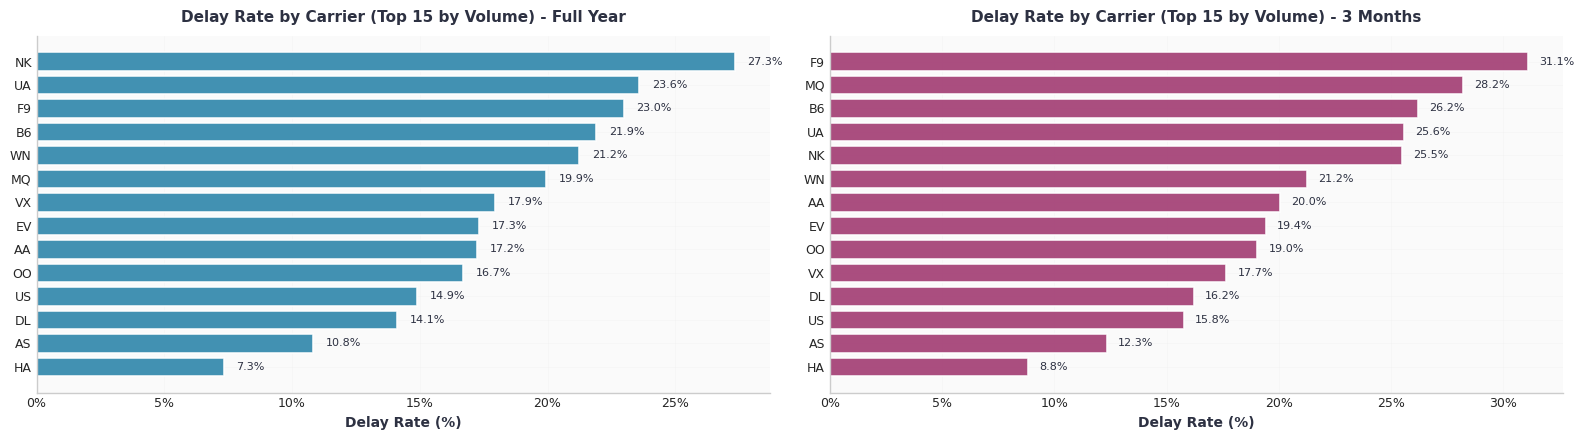

Saved: dbfs:/student-groups/Group_4_4/Charts/phase2_eda/airlines/delay_rate_by_carrier_full_vs_3m.png


In [0]:
import os
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ---------- local style + colors (self-contained) ----------
COLORS = {
    'primary':    '#2E86AB',
    'secondary':  '#A23B72',
    'grid':       '#E8E8E8',
    'text':       '#2D3142',
    'background': '#FAFAFA'
}

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'figure.titleweight': 'bold'
})

def style_axis(ax, title=None, xlabel=None, ylabel=None):
    ax.set_facecolor(COLORS['background'])
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color=COLORS['grid'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    if title:
        ax.set_title(title, fontweight='bold', color=COLORS['text'], pad=10)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='semibold', color=COLORS['text'])
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='semibold', color=COLORS['text'])

AIRLINE_DIR = "dbfs:/student-groups/Group_4_4/Charts/phase2_eda/airlines"
os.makedirs("/dbfs/student-groups/Group_4_4/Charts/phase2_eda/airlines", exist_ok=True)

def plot_delay_rate_by_carrier(df_full, df_3m, filename, top_n=15):
    # summaries
    full_summ = (df_full
        .groupBy("OP_UNIQUE_CARRIER")
        .agg(
            F.count("*").alias("num_flights"),
            F.mean(TARGET_BIN).alias("delay_rate")
        )
        .orderBy(F.desc("num_flights"))
        .limit(top_n)
        .toPandas()
    )

    slice_summ = (df_3m
        .groupBy("OP_UNIQUE_CARRIER")
        .agg(
            F.count("*").alias("num_flights"),
            F.mean(TARGET_BIN).alias("delay_rate")
        )
        .orderBy(F.desc("num_flights"))
        .limit(top_n)
        .toPandas()
    )

    full_summ  = full_summ.sort_values("delay_rate")
    slice_summ = slice_summ.sort_values("delay_rate")

    fig, (ax_full, ax_3m) = plt.subplots(1, 2, figsize=(16, 4.5), facecolor='white')

    # -------- full year --------
    y1 = range(len(full_summ))
    bars1 = ax_full.barh(
        y1,
        full_summ["delay_rate"] * 100,
        color=COLORS['primary'],
        alpha=0.9,
        edgecolor='white',
        linewidth=1.2
    )
    ax_full.set_yticks(y1)
    ax_full.set_yticklabels(full_summ["OP_UNIQUE_CARRIER"], fontsize=9)
    style_axis(
        ax_full,
        title="Delay Rate by Carrier (Top 15 by Volume) - Full Year",
        xlabel="Delay Rate (%)",
        ylabel=""
    )
    ax_full.xaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

    for i, (bar, v) in enumerate(zip(bars1, full_summ["delay_rate"] * 100)):
        ax_full.text(
            v + 0.5,
            i,
            f"{v:.1f}%",
            va="center",
            ha="left",
            fontsize=8,
            color=COLORS['text']
        )

    # -------- 3-month slice --------
    y2 = range(len(slice_summ))
    bars2 = ax_3m.barh(
        y2,
        slice_summ["delay_rate"] * 100,
        color=COLORS['secondary'],
        alpha=0.9,
        edgecolor='white',
        linewidth=1.2
    )
    ax_3m.set_yticks(y2)
    ax_3m.set_yticklabels(slice_summ["OP_UNIQUE_CARRIER"], fontsize=9)
    style_axis(
        ax_3m,
        title="Delay Rate by Carrier (Top 15 by Volume) - 3 Months",
        xlabel="Delay Rate (%)",
        ylabel=""
    )
    ax_3m.xaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

    for i, (bar, v) in enumerate(zip(bars2, slice_summ["delay_rate"] * 100)):
        ax_3m.text(
            v + 0.5,
            i,
            f"{v:.1f}%",
            va="center",
            ha="left",
            fontsize=8,
            color=COLORS['text']
        )

    plt.tight_layout()
    out_path_local = "/dbfs/student-groups/Group_4_4/Charts/phase2_eda/airlines/" + filename
    plt.savefig(out_path_local, dpi=300, bbox_inches="tight", facecolor='white')
    plt.show()
    print("Saved:", AIRLINE_DIR + "/" + filename)

# run it
plot_delay_rate_by_carrier(
    otpw_full_df,
    otpw_3m_df,
    filename="delay_rate_by_carrier_full_vs_3m.png"
)


In [0]:
dbutils.fs.cp(
    "dbfs:/student-groups/Group_4_4/Charts/phase2_eda/airlines",
    "dbfs:/FileStore/Group_4_4/Charts/phase2_eda/airlines",
    recurse=True
)


True

saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/combined/geo_distribution_full.png


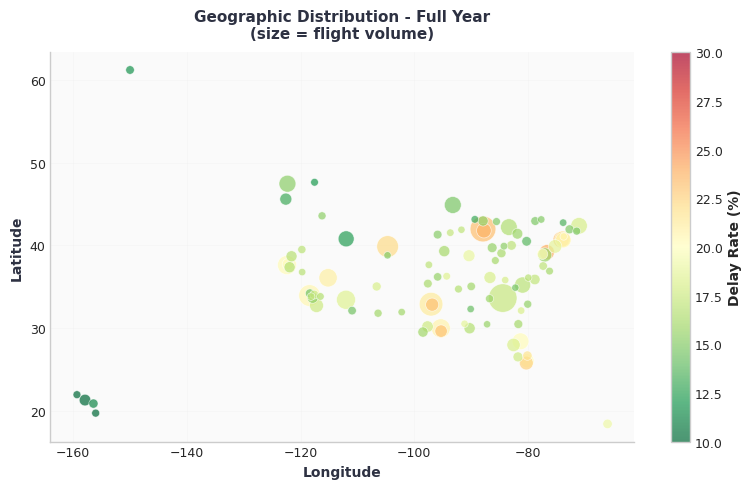

saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/combined/geo_distribution_3m.png


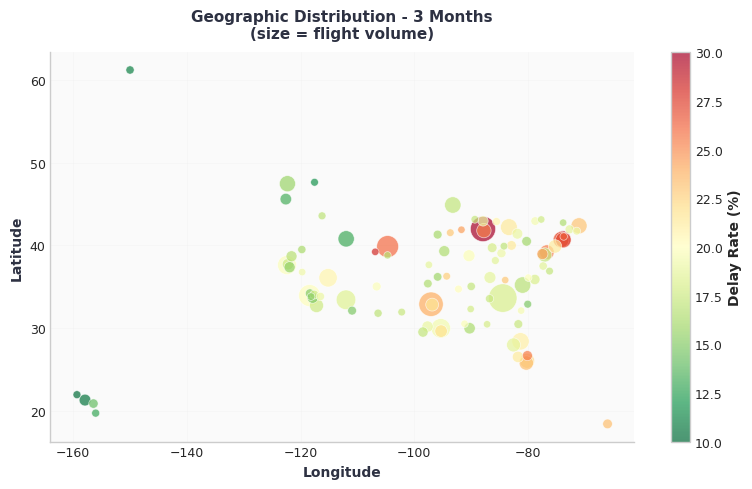

In [0]:
# ============================================================
# GEO DISTRIBUTION — FULL YEAR & 3-MONTH (SEPARATE FIGURES)
# ============================================================

def compute_geo_df(df):
    return (
        df.groupBy("ORIGIN", "origin_airport_lat", "origin_airport_lon")
          .agg(
              F.count("*").alias("n"),
              F.mean(TARGET_BIN).alias("delay_rate")
          )
          .filter(F.col("origin_airport_lat").isNotNull() &
                  F.col("origin_airport_lon").isNotNull())
          .orderBy(F.desc("n"))
          .limit(100)
          .toPandas()
    )

def plot_geo_distribution_separate(df_full, df_3m, prefix="geo_distribution"):
    # ---------- prep data ----------
    pd_geo_full = compute_geo_df(df_full)
    pd_geo_3m   = compute_geo_df(df_3m)

    # ---------- FULL YEAR ----------
    fig1, ax1 = plt.subplots(figsize=(8, 5), facecolor="white")
    scatter1 = ax1.scatter(
        pd_geo_full["origin_airport_lon"],
        pd_geo_full["origin_airport_lat"],
        s=(pd_geo_full["n"] / pd_geo_full["n"].max()) * 400 + 20,
        c=pd_geo_full["delay_rate"] * 100,
        cmap="RdYlGn_r",
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5,
        vmin=10,
        vmax=30,
    )
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label("Delay Rate (%)", fontweight="semibold")
    style_axis(
        ax1,
        title="Geographic Distribution - Full Year\n(size = flight volume)",
        xlabel="Longitude",
        ylabel="Latitude",
    )
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}"))

    full_path = f"{COMBINED_DIR}/{prefix}_full.png"
    fig1.tight_layout()
    fig1.savefig(full_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", full_path)
    plt.show()

    # ---------- 3-MONTH WINDOW ----------
    fig2, ax2 = plt.subplots(figsize=(8, 5), facecolor="white")
    scatter2 = ax2.scatter(
        pd_geo_3m["origin_airport_lon"],
        pd_geo_3m["origin_airport_lat"],
        s=(pd_geo_3m["n"] / pd_geo_3m["n"].max()) * 400 + 20,
        c=pd_geo_3m["delay_rate"] * 100,
        cmap="RdYlGn_r",
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5,
        vmin=10,
        vmax=30,
    )
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label("Delay Rate (%)", fontweight="semibold")
    style_axis(
        ax2,
        title="Geographic Distribution - 3 Months\n(size = flight volume)",
        xlabel="Longitude",
        ylabel="Latitude",
    )
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}"))

    m3_path = f"{COMBINED_DIR}/{prefix}_3m.png"
    fig2.tight_layout()
    fig2.savefig(m3_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", m3_path)
    plt.show()

    return full_path, m3_path


# ----- RUN TO GENERATE & SAVE -----
geo_full_path, geo_3m_path = plot_geo_distribution_separate(
    otpw_full_df,
    otpw_3m_df,
    prefix="geo_distribution"
)


In [0]:
# Copy geo charts into a web-visible folder
dbutils.fs.mkdirs("dbfs:/FileStore/group4_phase2")

dbutils.fs.cp(
    "dbfs:/student-groups/Group_4_4/Charts/phase2_eda/combined/geo_distribution_full.png",
    "dbfs:/FileStore/group4_phase2/geo_distribution_full.png",
    True,
)

dbutils.fs.cp(
    "dbfs:/student-groups/Group_4_4/Charts/phase2_eda/combined/geo_distribution_3m.png",
    "dbfs:/FileStore/group4_phase2/geo_distribution_3m.png",
    True,
)


True

In [0]:
src_dir = "dbfs:/FileStore/group4_phase2"
dst_dir = "dbfs:/student-groups/Group_4_4/Charts/phase2"

files = [
    "geo_distribution_full_resized.png",
    "geo_distribution_3m_resized.png"
]

for name in files:
    dbutils.fs.cp(f"{src_dir}/{name}", f"{dst_dir}/{name}", True)

print("Copied resized geo charts into phase2 folder.")



Copied resized geo charts into phase2 folder.


In [0]:
dbutils.fs.ls("dbfs:/student-groups/Group_4_4/Charts/phase2")


[FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/phase2/airline_delay_rate_vs_flight_volume_3m.png', name='airline_delay_rate_vs_flight_volume_3m.png', size=184188, modificationTime=1764027069000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/phase2/airline_delay_rate_vs_flight_volume_full.png', name='airline_delay_rate_vs_flight_volume_full.png', size=180229, modificationTime=1764027066000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/phase2/busiest_origins_business_3m.png', name='busiest_origins_business_3m.png', size=269246, modificationTime=1764037926000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/phase2/busiest_origins_business_full.png', name='busiest_origins_business_full.png', size=280578, modificationTime=1764037913000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_origins_combined_3m.png', name='busiest_vs_most_delayed_origins_combined_3m.png', size=412356, modificationTime=1764027083000),
 FileInfo(p


6/6: Hourly Delay Rate...
saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/full/delay_rate_by_hour_full.png


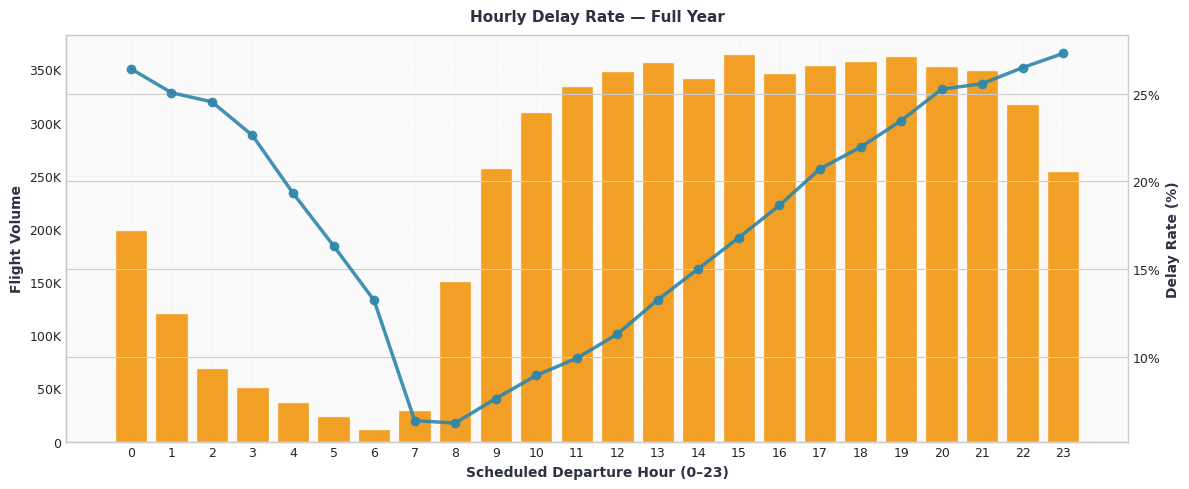

saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/3m/delay_rate_by_hour_3m.png


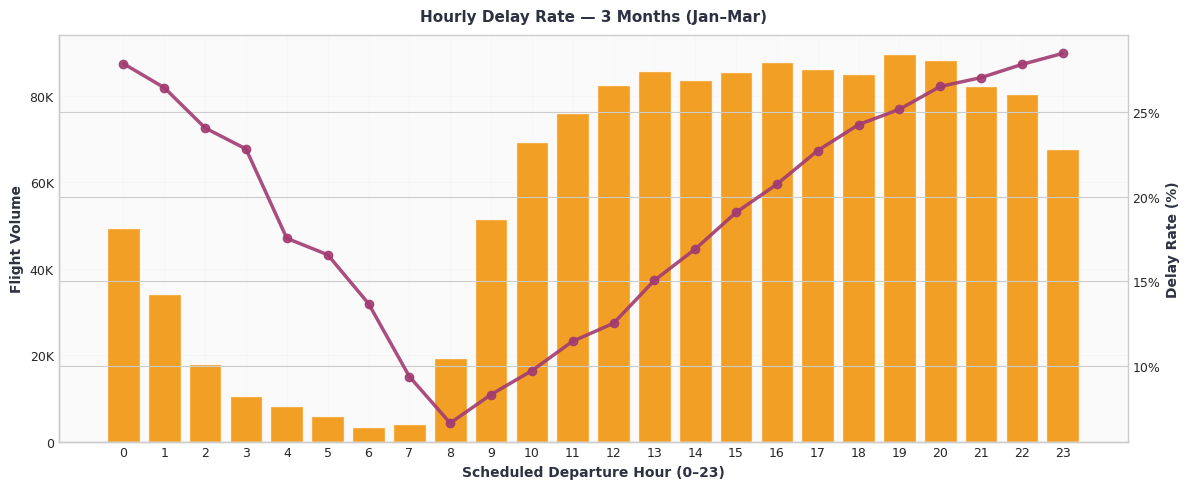

/root/.ipykernel/5032/command-7174456240422614-3585252542:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/combined/delay_rate_by_hour_combined_full_vs_3m.png


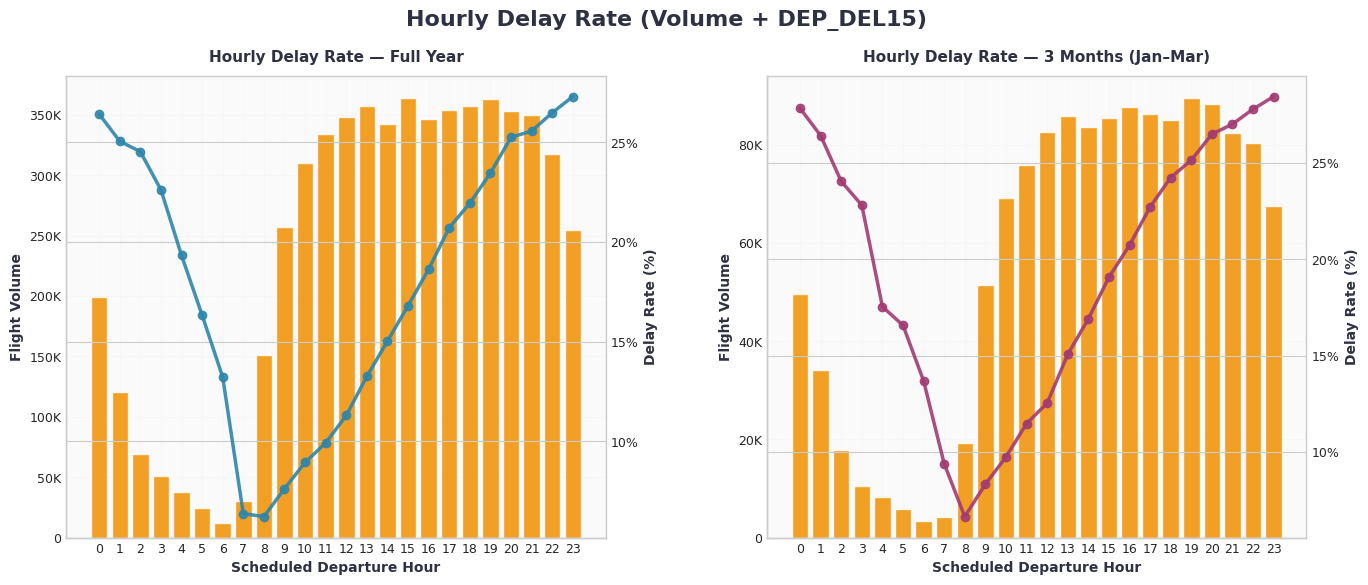

In [0]:
# ============================================================
# 6) HOURLY DELAY RATE (12M vs 3M)
#   - Bars = flight volume
#   - Line = DEP_DEL15 delay rate (%)
# ============================================================

def _prep_hourly(df):
    """Ensure we have an hour column and compute volume + delay rate."""
    # Prefer engineered departure_hour if present, else derive from CRS_DEP_TIME
    if "departure_hour" in df.columns:
        tmp = df.withColumn("dep_hour", F.col("departure_hour"))
    else:
        tmp = df.withColumn("dep_hour", (F.col("CRS_DEP_TIME")/100).cast("int"))
    
    pdf = (
        tmp.groupBy("dep_hour")
           .agg(
               F.count("*").alias("num_flights"),
               (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
           )
           .orderBy("dep_hour")
           .toPandas()
    )
    pdf = pdf[pdf["dep_hour"].notnull()]
    return pdf


def plot_hourly_delay_single(df, title, out_dir, filename, line_color):
    """Single hourly chart: bars = volume, line = delay rate (%)"""
    pdf = _prep_hourly(df)

    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    # Bars: flight volume
    bars = ax1.bar(
        pdf["dep_hour"],
        pdf["num_flights"],
        color=COLORS["warning"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1
    )
    style_axis(
        ax1,
        title=title,
        xlabel="Scheduled Departure Hour (0–23)",
        ylabel="Flight Volume"
    )
    ax1.set_xticks(range(0, 24, 1))

    # Line: delay rate
    ax2 = ax1.twinx()
    ax2.plot(
        pdf["dep_hour"],
        pdf["delay_rate_pct"],
        color=line_color,
        marker="o",
        linewidth=2.5,
        markersize=6,
        alpha=0.9,
        label="Delay Rate (%)"
    )
    ax2.set_ylabel("Delay Rate (%)", fontweight="semibold", color=COLORS["text"])
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))

    fig.tight_layout()
    out_path = f"{out_dir}/{filename}"
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", out_path)
    plt.show()


def plot_hourly_delay_combined(df_full, df_3m, filename):
    """
    Side-by-side combined figure:
      left  = full year
      right = 3 months
    Matches Phase 2 GridSpec styling.
    """
    pdf_full = _prep_hourly(df_full)
    pdf_3m   = _prep_hourly(df_3m)

    fig = plt.figure(figsize=(16, 6), facecolor="white")
    gs = GridSpec(1, 2, figure=fig, wspace=0.3)

    # ---------- Full year ----------
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.bar(
        pdf_full["dep_hour"],
        pdf_full["num_flights"],
        color=COLORS["warning"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1
    )
    style_axis(
        ax1,
        title="Hourly Delay Rate — Full Year",
        xlabel="Scheduled Departure Hour",
        ylabel="Flight Volume"
    )
    ax1.set_xticks(range(0, 24, 1))

    ax2 = ax1.twinx()
    ax2.plot(
        pdf_full["dep_hour"],
        pdf_full["delay_rate_pct"],
        color=COLORS["primary"],
        marker="o",
        linewidth=2.5,
        markersize=6,
        alpha=0.9
    )
    ax2.set_ylabel("Delay Rate (%)", fontweight="semibold", color=COLORS["text"])
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))

    # ---------- 3-month window ----------
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.bar(
        pdf_3m["dep_hour"],
        pdf_3m["num_flights"],
        color=COLORS["warning"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1
    )
    style_axis(
        ax3,
        title="Hourly Delay Rate — 3 Months (Jan–Mar)",
        xlabel="Scheduled Departure Hour",
        ylabel="Flight Volume"
    )
    ax3.set_xticks(range(0, 24, 1))

    ax4 = ax3.twinx()
    ax4.plot(
        pdf_3m["dep_hour"],
        pdf_3m["delay_rate_pct"],
        color=COLORS["secondary"],
        marker="o",
        linewidth=2.5,
        markersize=6,
        alpha=0.9
    )
    ax4.set_ylabel("Delay Rate (%)", fontweight="semibold", color=COLORS["text"])
    ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))

    fig.suptitle(
        "Hourly Delay Rate (Volume + DEP_DEL15)",
        fontsize=16,
        fontweight="bold",
        color=COLORS["text"],
        y=0.99
    )

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    out_path = f"{COMBINED_DIR}/{filename}"
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", out_path)
    plt.show()


# ------------------------------------------------------------
# Generate hourly delay charts
# ------------------------------------------------------------
print("\n6/6: Hourly Delay Rate...")

# Individual full / 3-month (to FULL_DIR and M3_DIR)
plot_hourly_delay_single(
    otpw_full_df,
    "Hourly Delay Rate — Full Year",
    FULL_DIR,
    "delay_rate_by_hour_full.png",
    line_color=COLORS["primary"]
)

plot_hourly_delay_single(
    otpw_3m_df,
    "Hourly Delay Rate — 3 Months (Jan–Mar)",
    M3_DIR,
    "delay_rate_by_hour_3m.png",
    line_color=COLORS["secondary"]
)

# Combined figure (to COMBINED_DIR)
plot_hourly_delay_combined(
    otpw_full_df,
    otpw_3m_df,
    "delay_rate_by_hour_combined_full_vs_3m.png"
)


Rows: 5,704,114 | Cols: 105
Full-year rows: 5704114
3-month rows: 1354285


RUNNING FULL-YEAR EDA

=== otpw_full_2015 ===
Rows: 5,704,114 | Cols: 105
Date range: 2015-01-01 → 2015-12-31


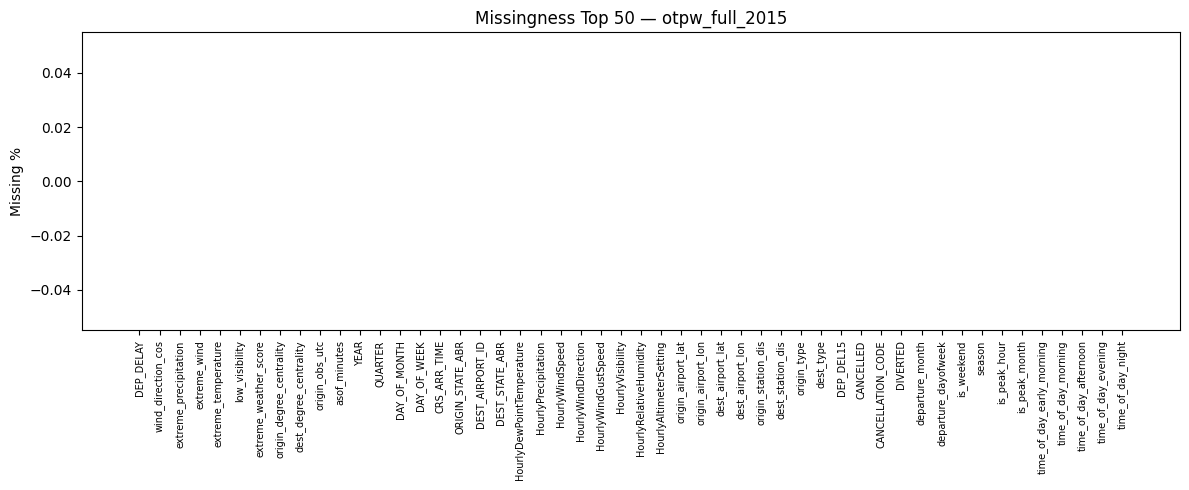

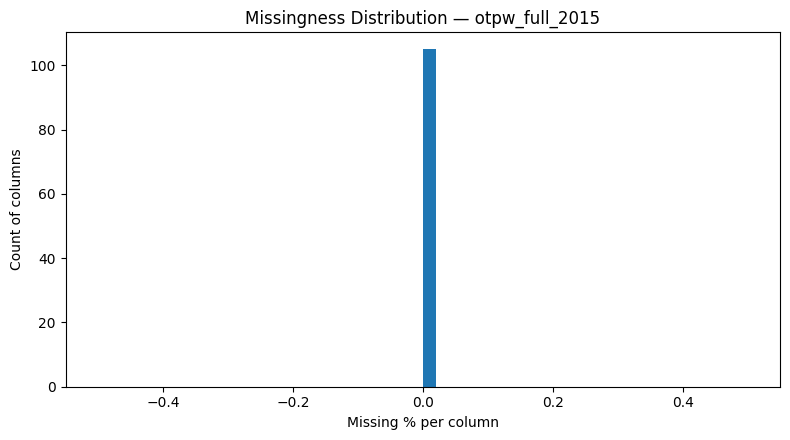

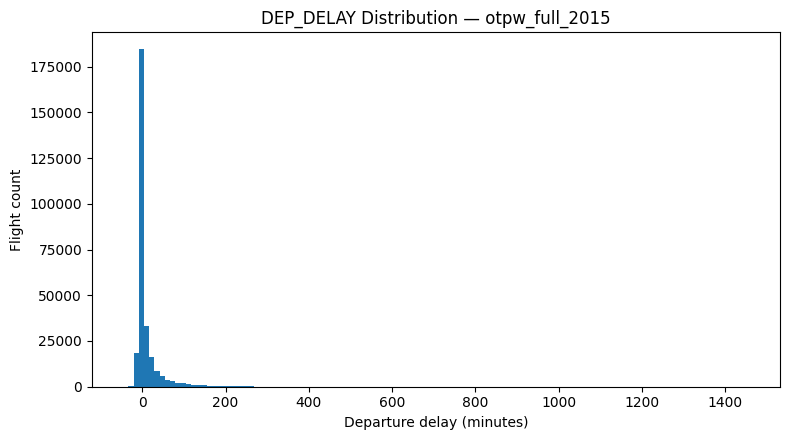

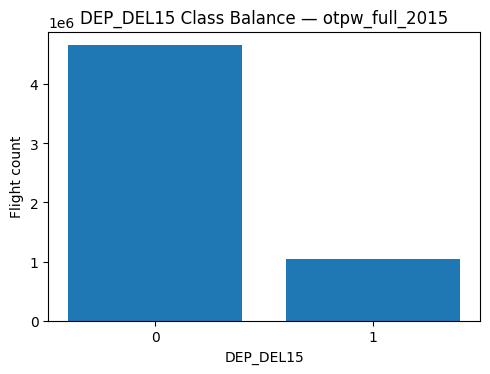

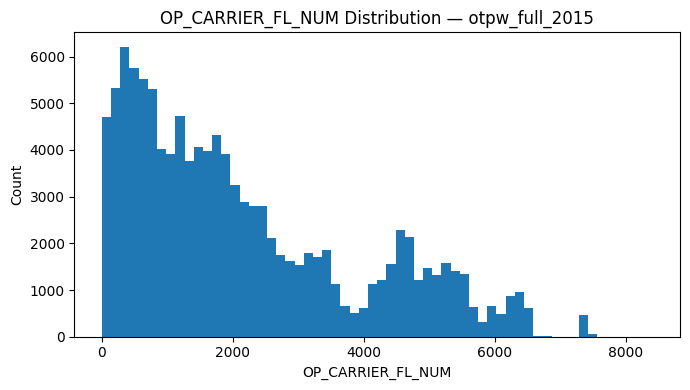

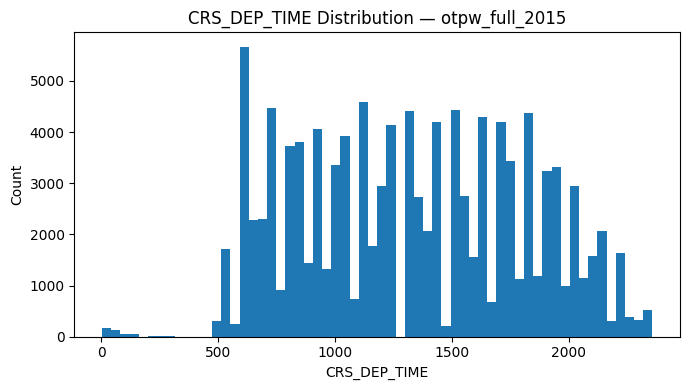

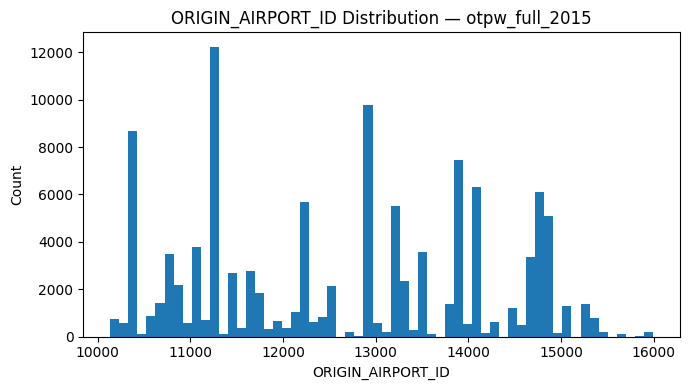

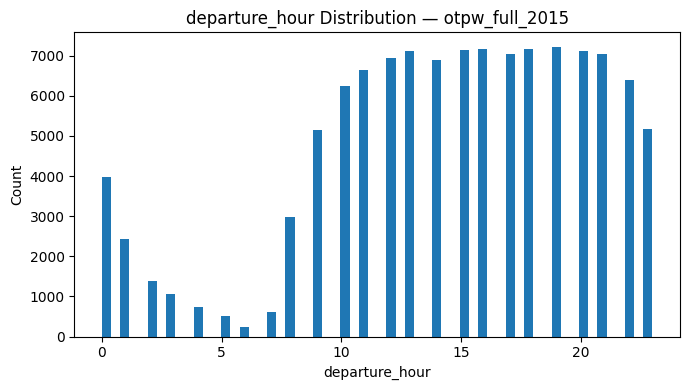

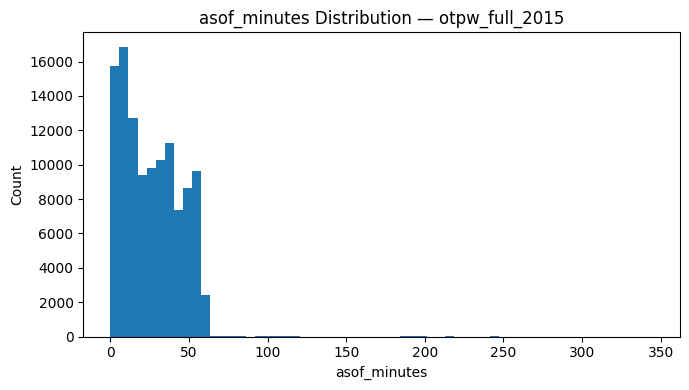

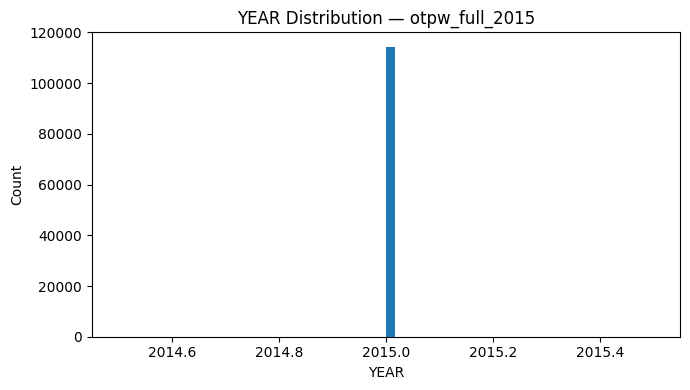

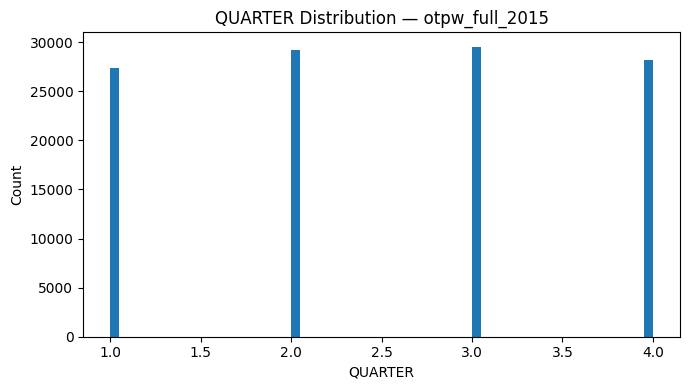

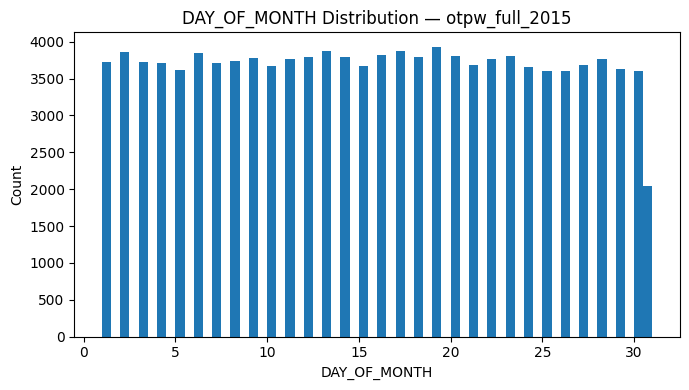

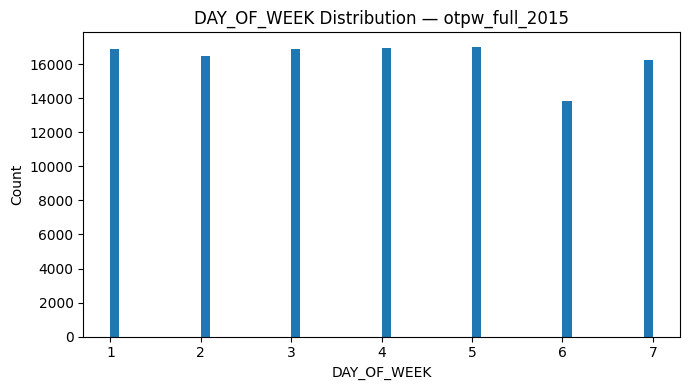

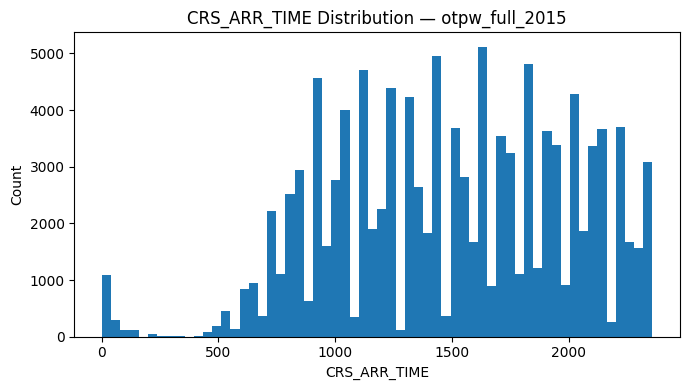

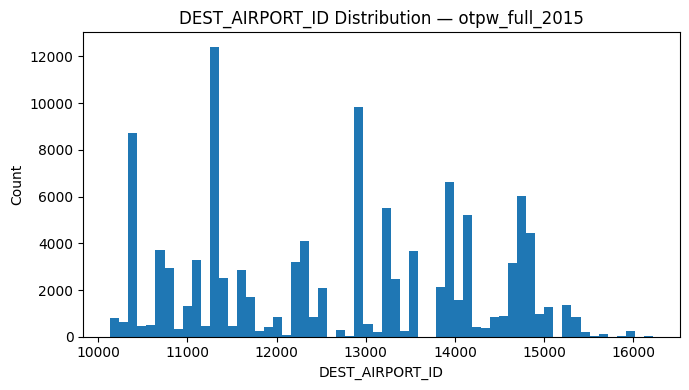

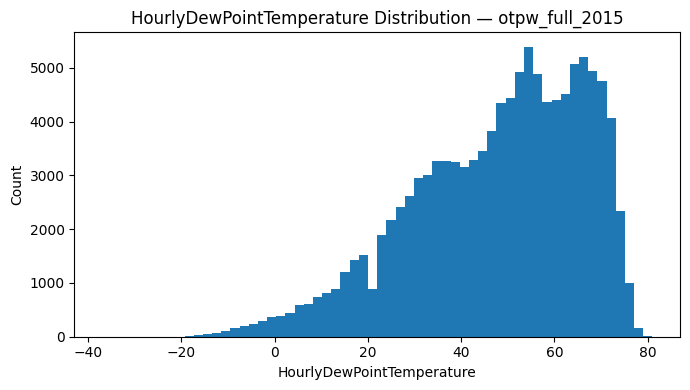

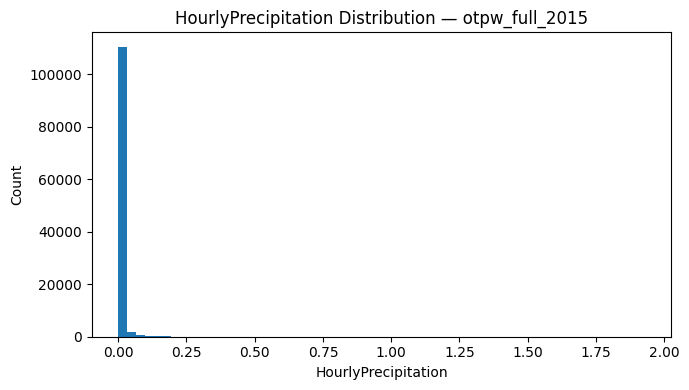

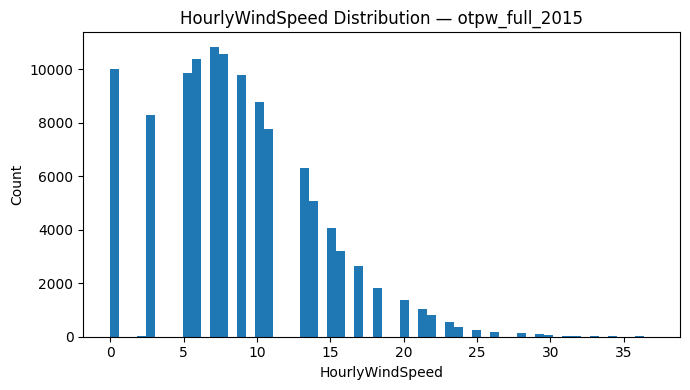

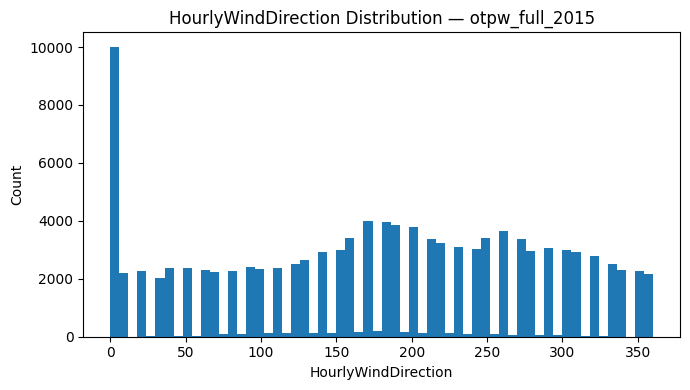

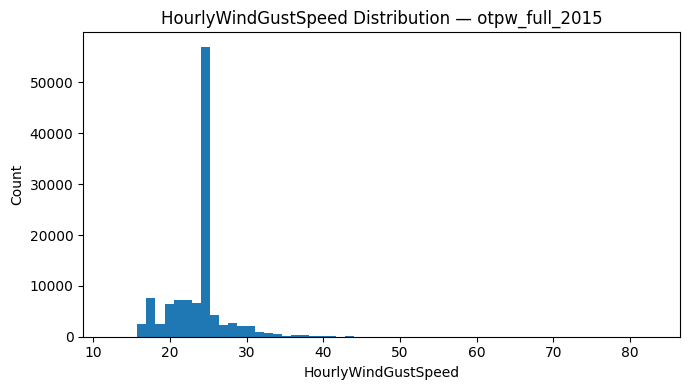

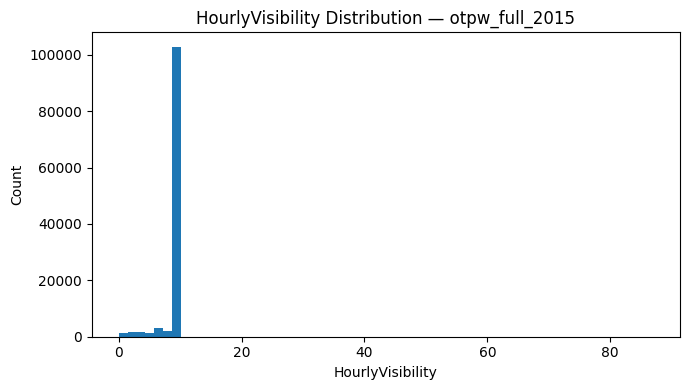

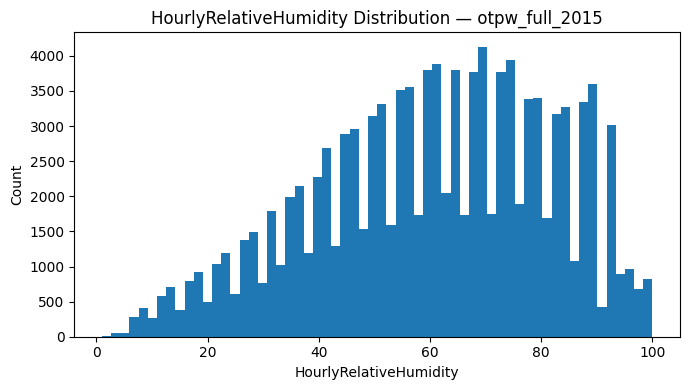

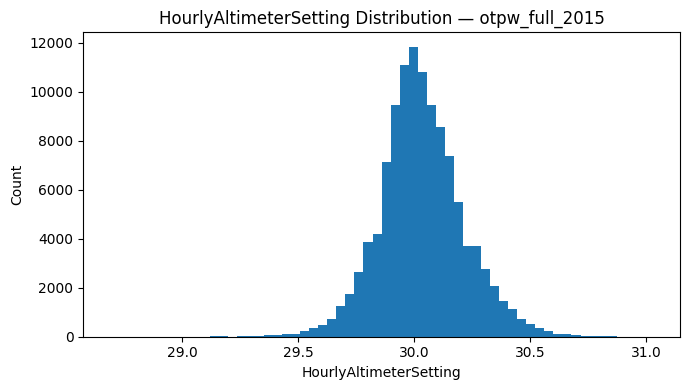

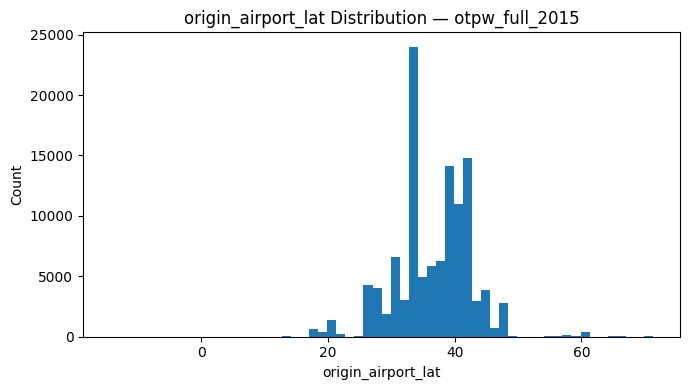

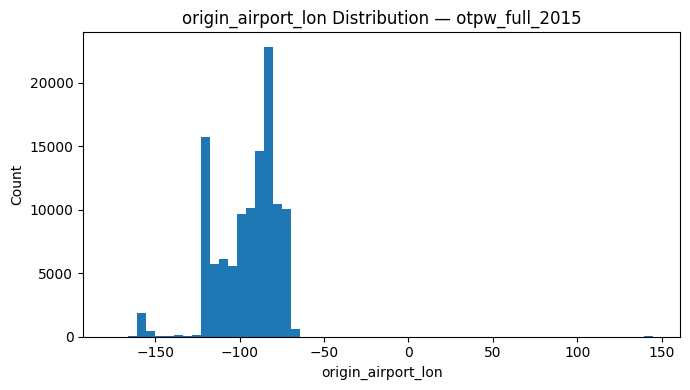

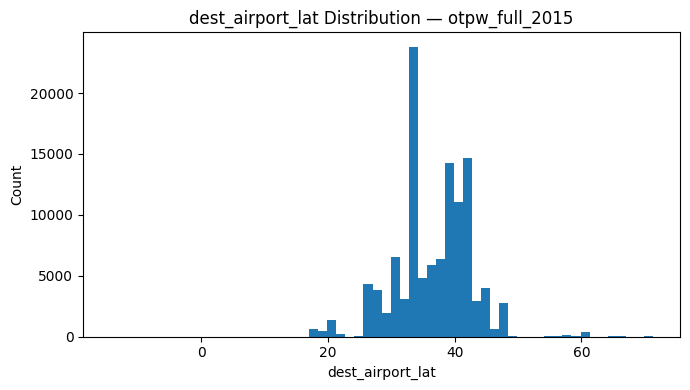

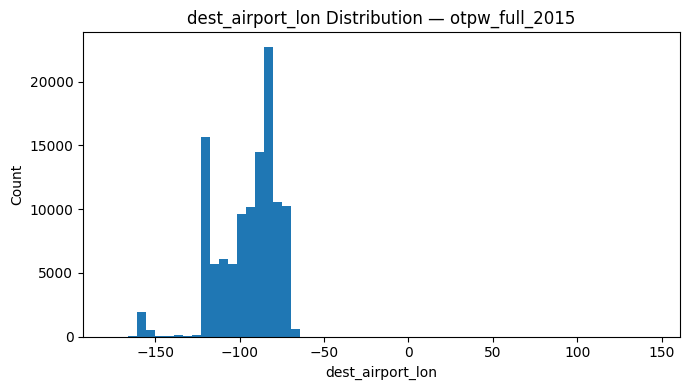

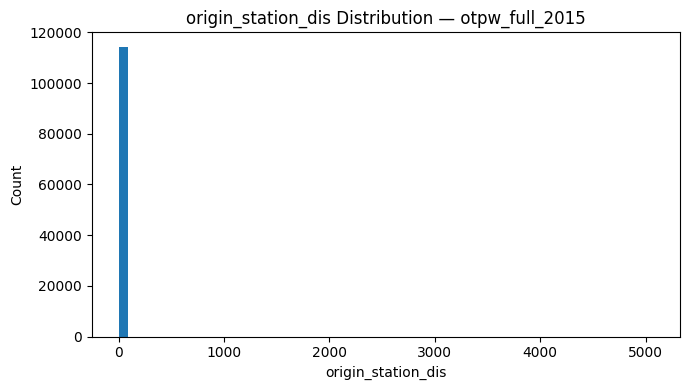

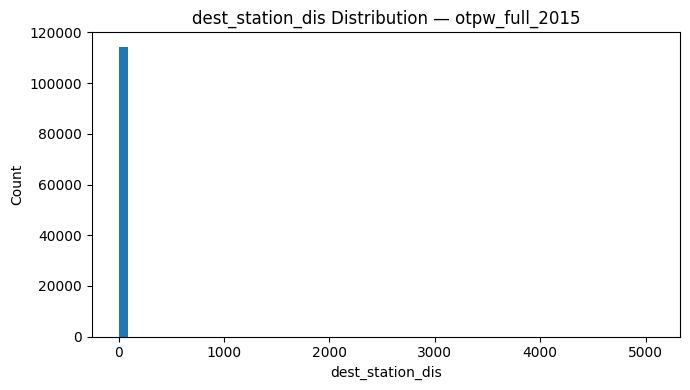

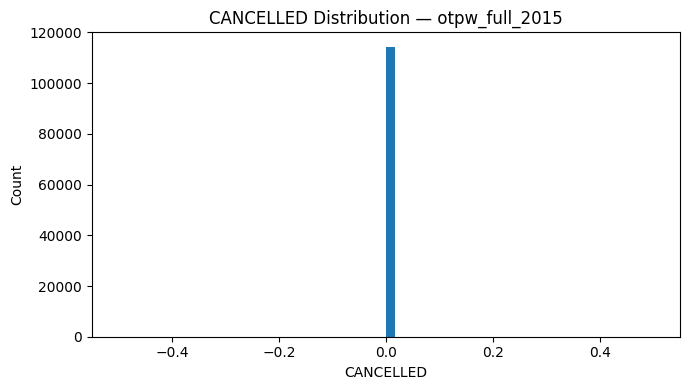

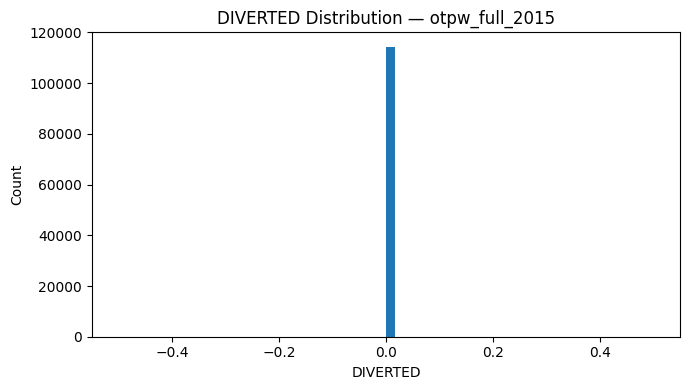

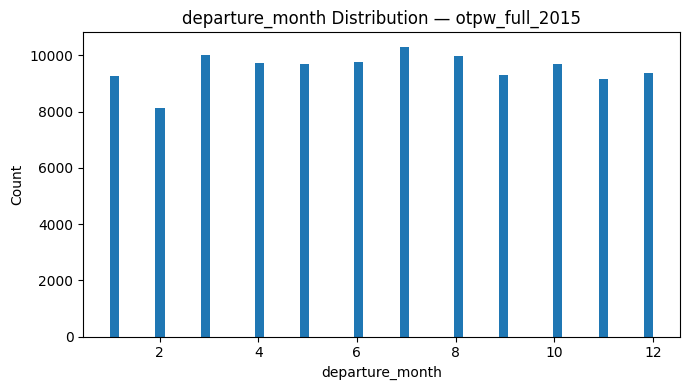

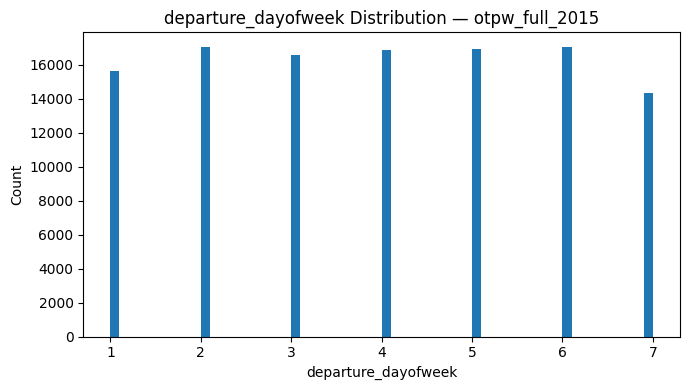

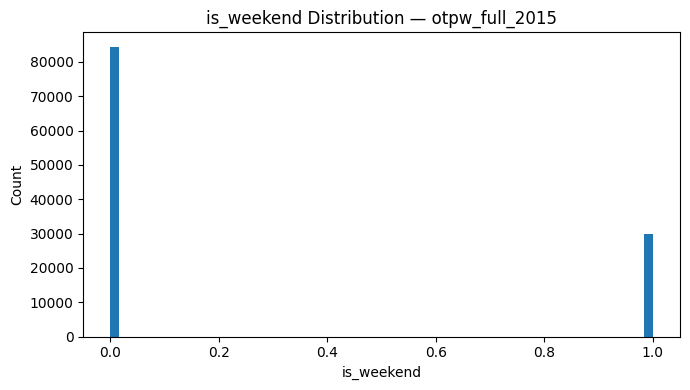

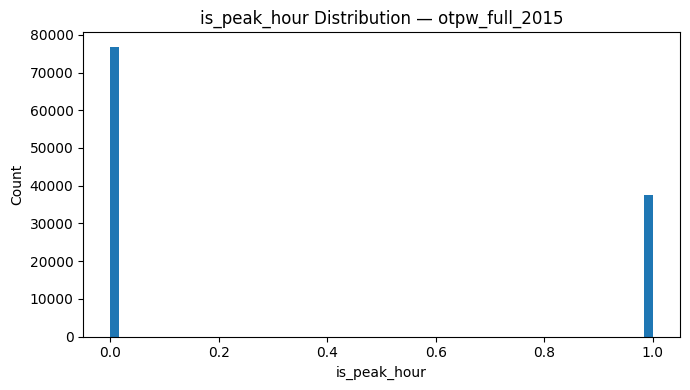

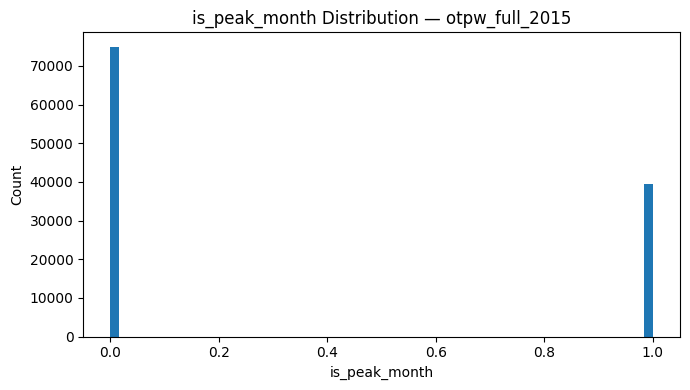

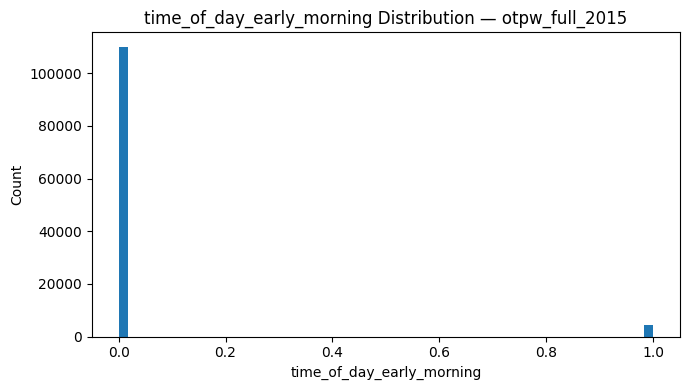

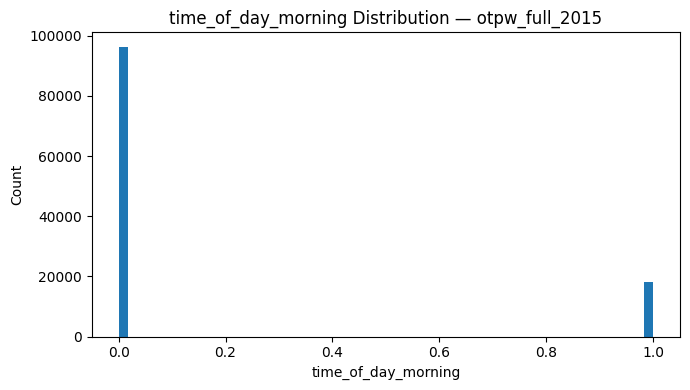

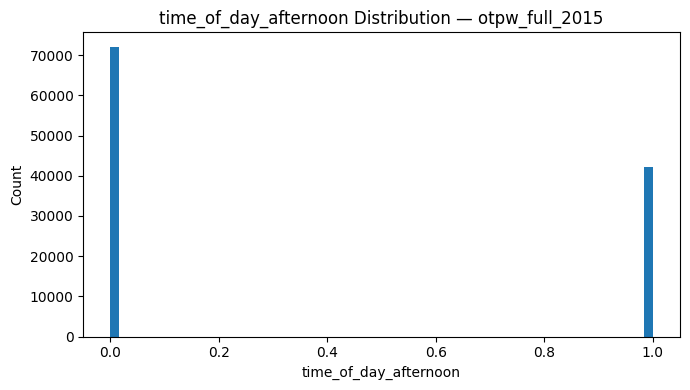

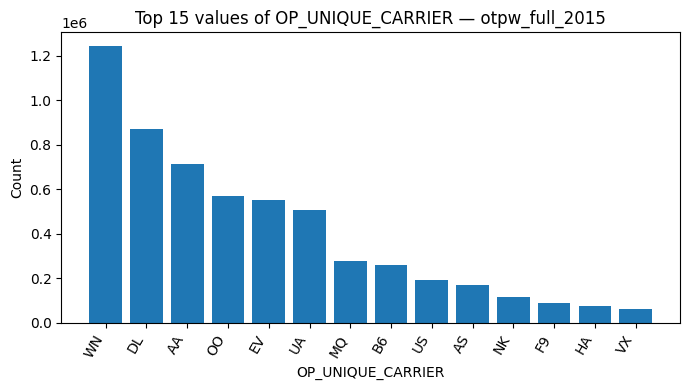

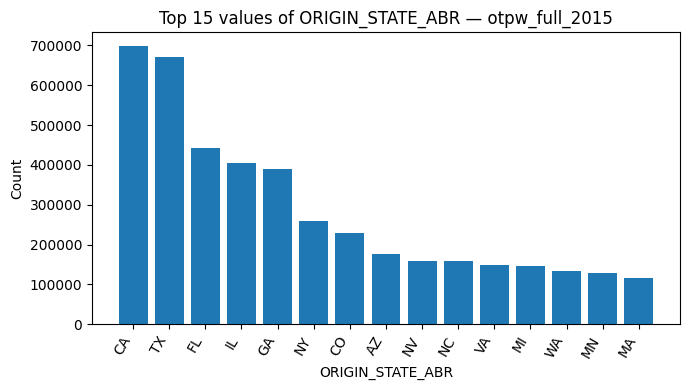

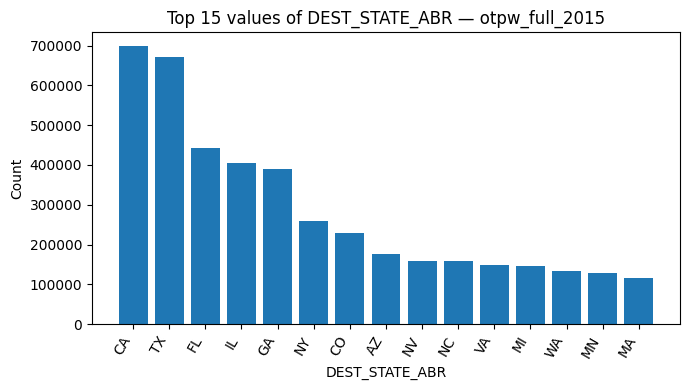

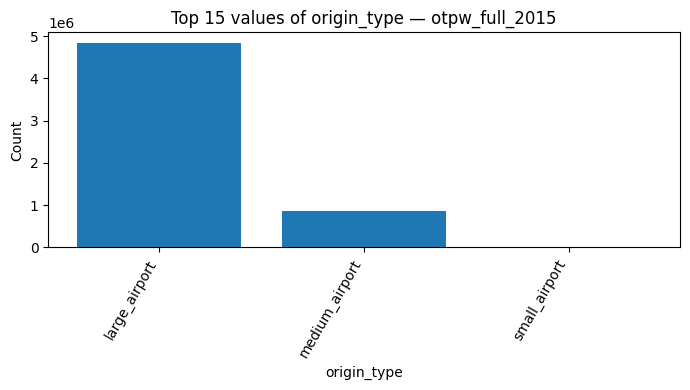

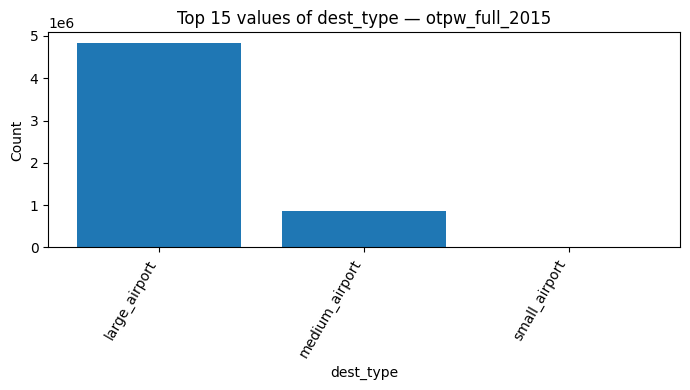

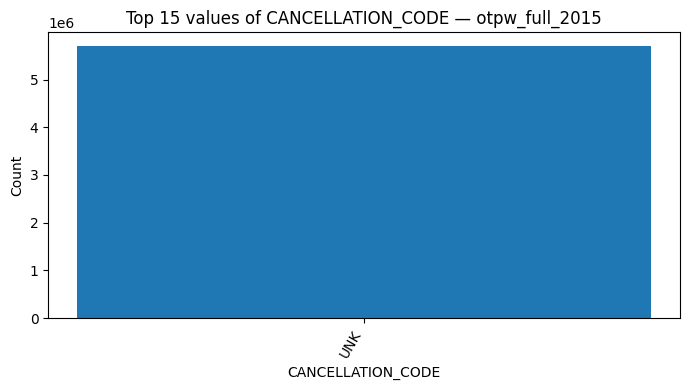

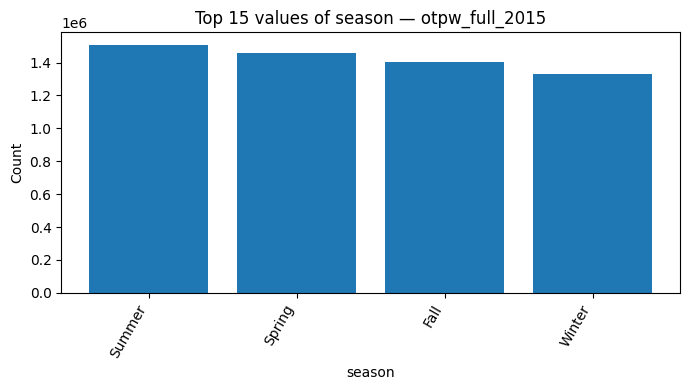

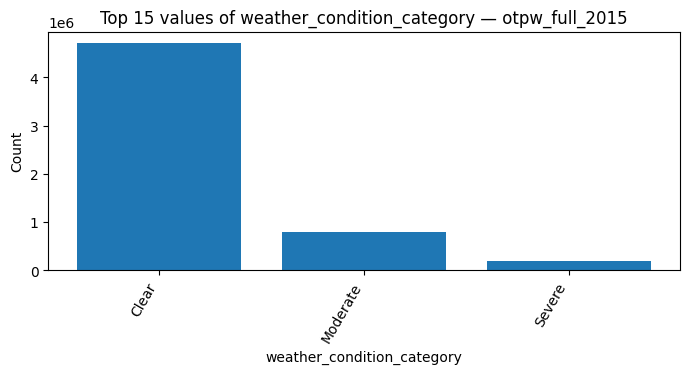

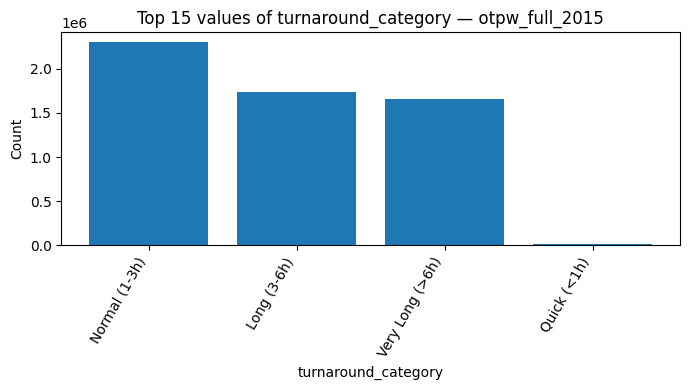

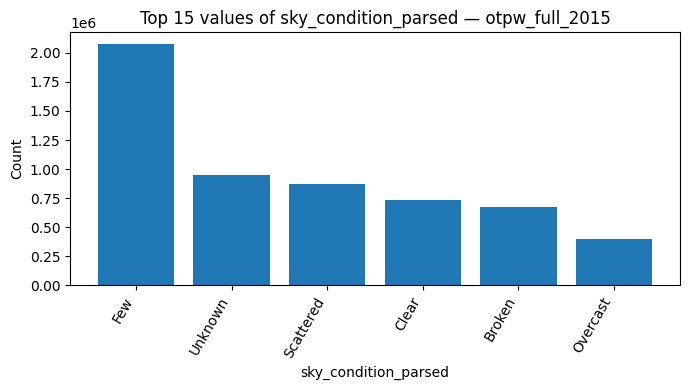

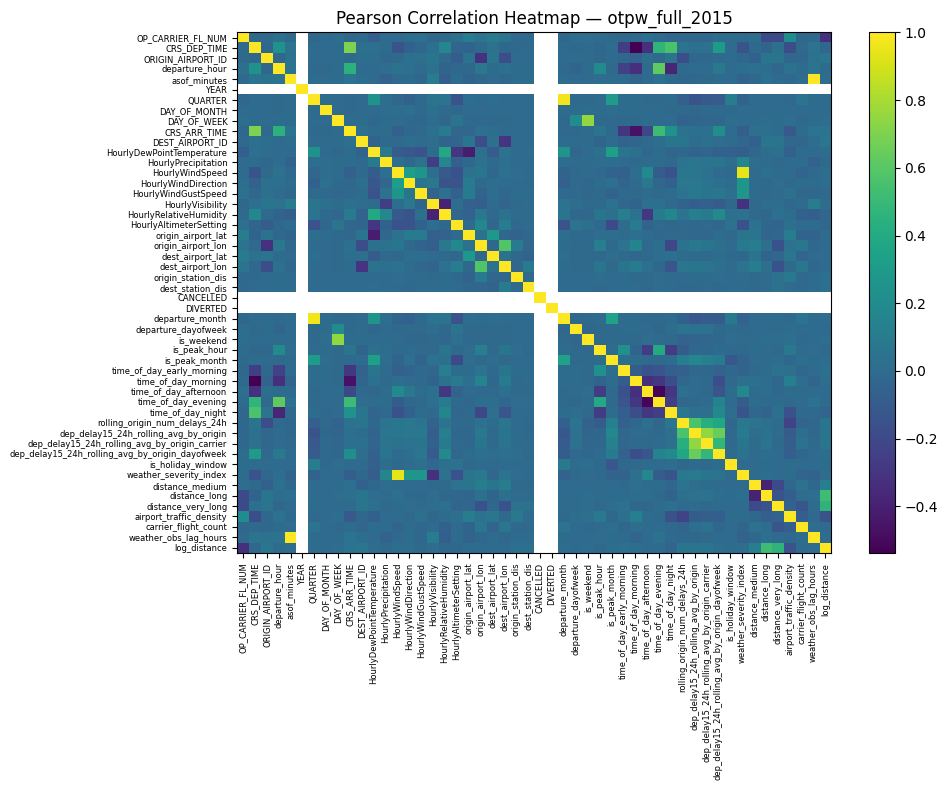

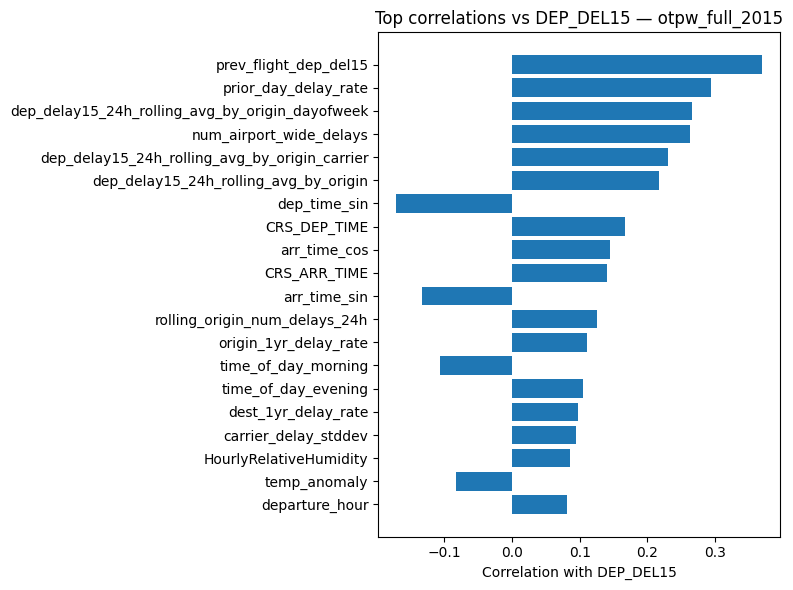

feature point_biserial_corr abs_corr prev_flight_dep_del15 0.36879263289471864 0.36879263289471864 prior_day_delay_rate 0.29396295509767795 0.29396295509767795 dep_delay15_24h_rolling_avg_by_origin_dayofweek 0.26615159639151525 0.26615159639151525 num_airport_wide_delays 0.2626989559506814 0.2626989559506814 dep_delay15_24h_rolling_avg_by_origin_carrier 0.2310882397944777 0.2310882397944777 dep_delay15_24h_rolling_avg_by_origin 0.21739050329169995 0.21739050329169995 dep_time_sin -0.17042975606841632 0.17042975606841632 CRS_DEP_TIME 0.16743404562428804 0.16743404562428804 arr_time_cos 0.14468965297388015 0.14468965297388015 CRS_ARR_TIME 0.14108676388034672 0.14108676388034672 arr_time_sin -0.13265612332867732 0.13265612332867732 rolling_origin_num_delays_24h 0.12590317481664906 0.12590317481664906 origin_1yr_delay_rate 0.1113185546919589 0.1113185546919589 time_of_day_morning -0.10574003298318348 0.10574003298318348 time_of_day_evening 0.10427506195675545 0.10427506195675545 dest_1yr_delay_rate 0.09711151336636709 0.09711151336636709 carrier_delay_stddev 0.09523630177086313 0.09523630177086313 HourlyRelativeHumidity 0.08644322482522387 0.08644322482522387 temp_anomaly -0.08192755254263642 0.08192755254263642 departure_hour 0.080685326571129 0.080685326571129 extreme_weather_score 0.07806393542213884 0.07806393542213884 is_rainy 0.07543997940387023 0.07543997940387023 time_of_day_night 0.07226724487048494 0.07226724487048494 is_business_hours -0.0705963688503601 0.0705963688503601 dep_time_cos 0.06033806042157838 0.06033806042157838

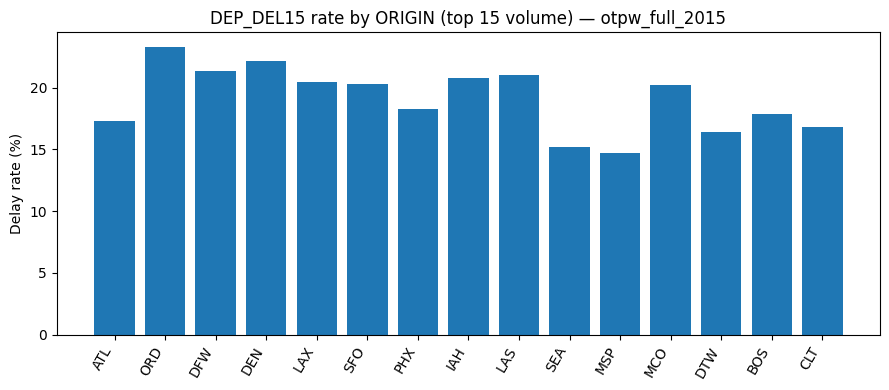

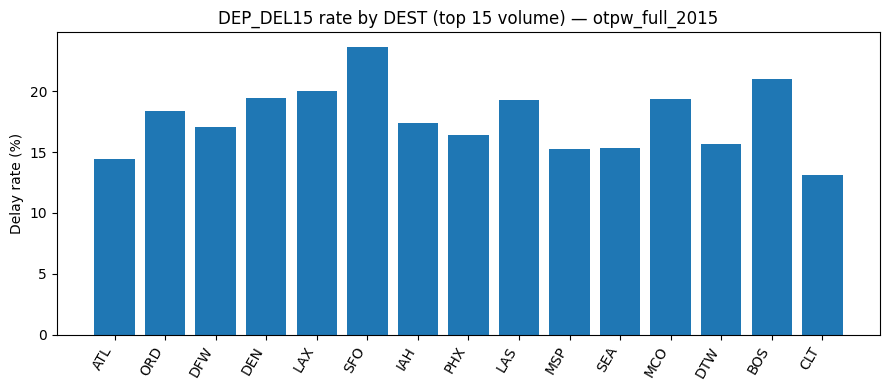

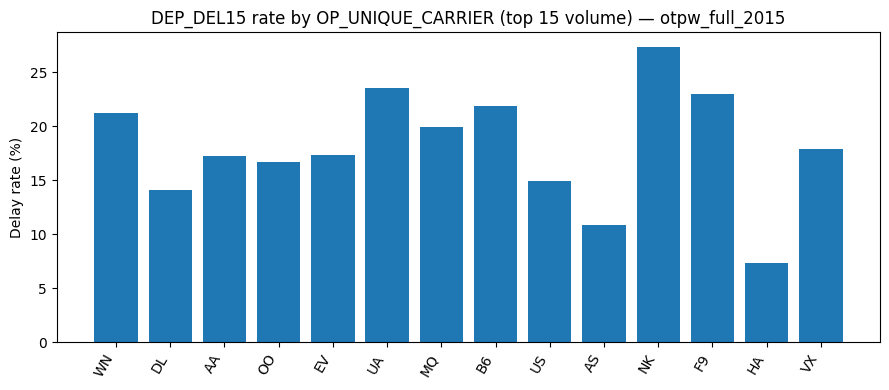

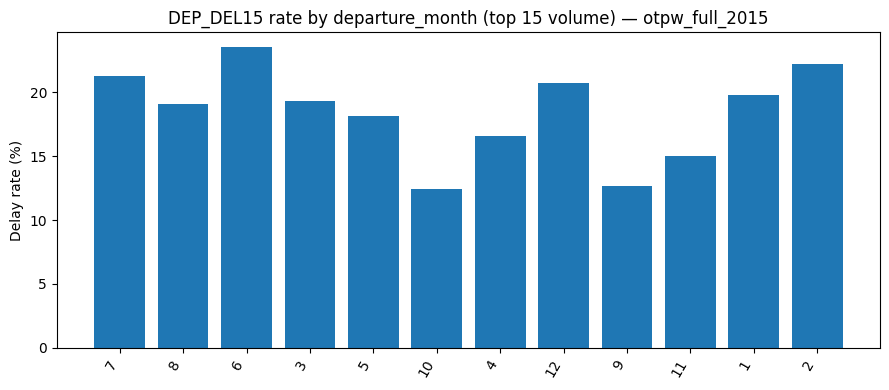

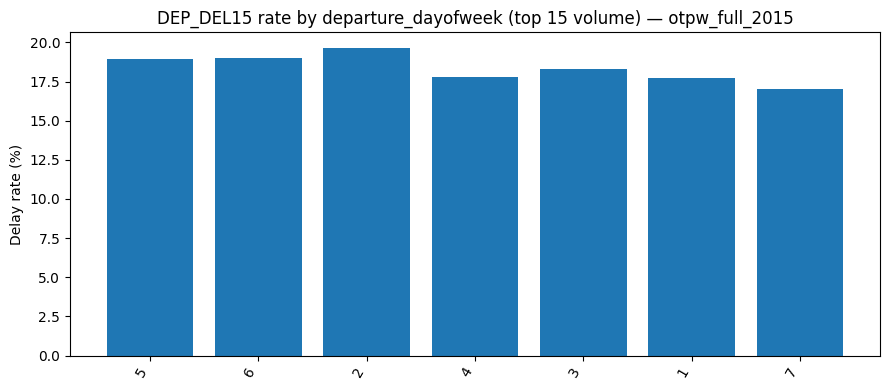

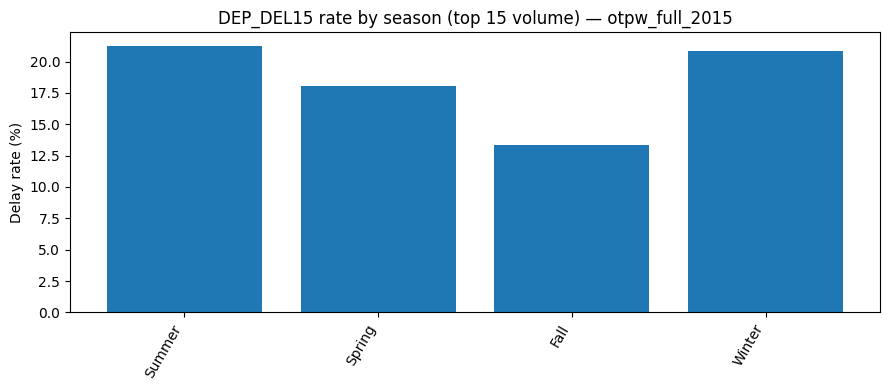

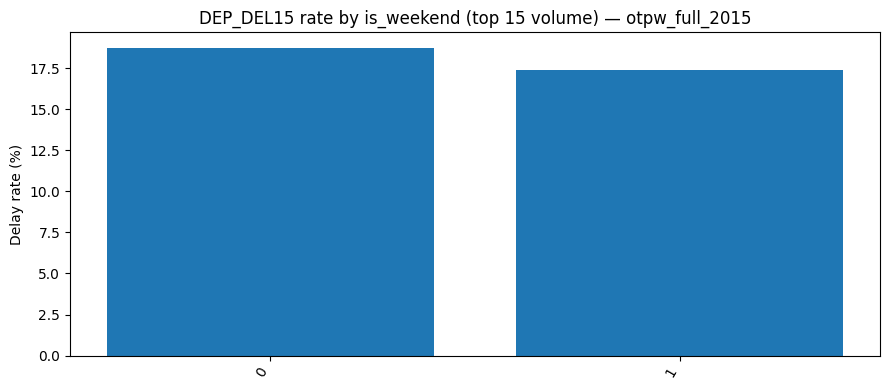

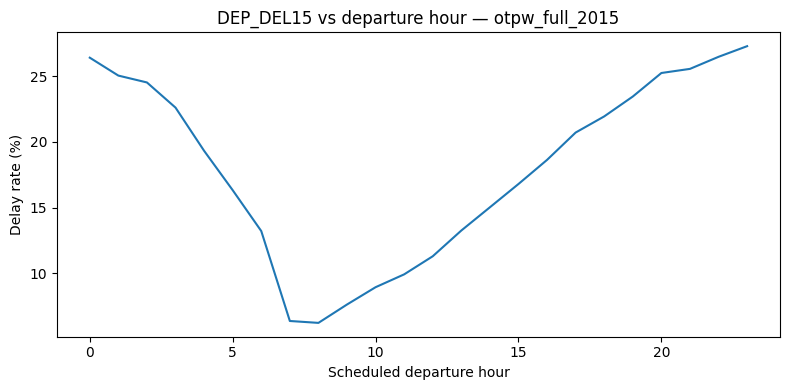

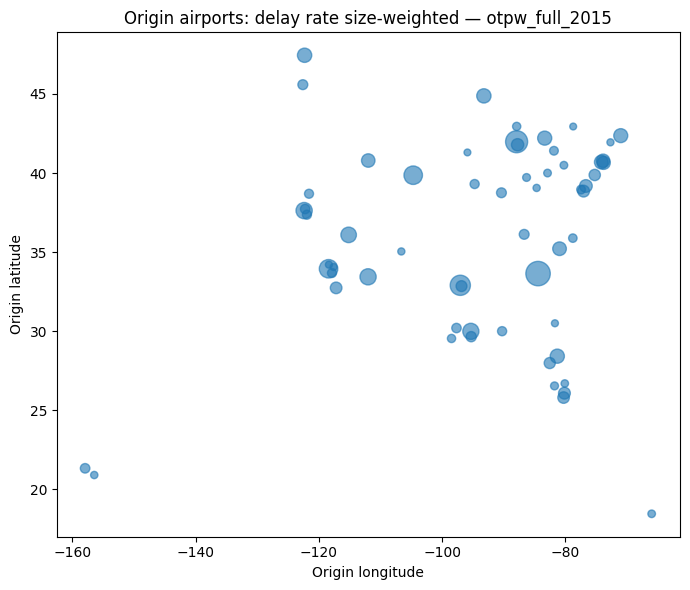

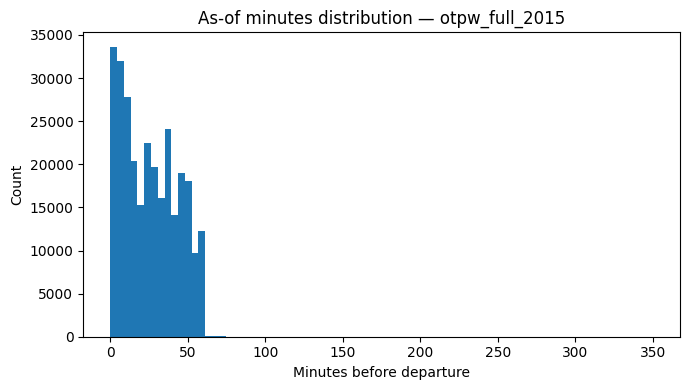

Finished EDA: otpw_full_2015 → /dbfs/student-groups/Group_4_4/Charts/phase2_eda/full


RUNNING 3-MONTH EDA

=== otpw_3m_JanMar2015 ===
Rows: 1,354,285 | Cols: 105
Date range: 2015-01-01 → 2015-03-31


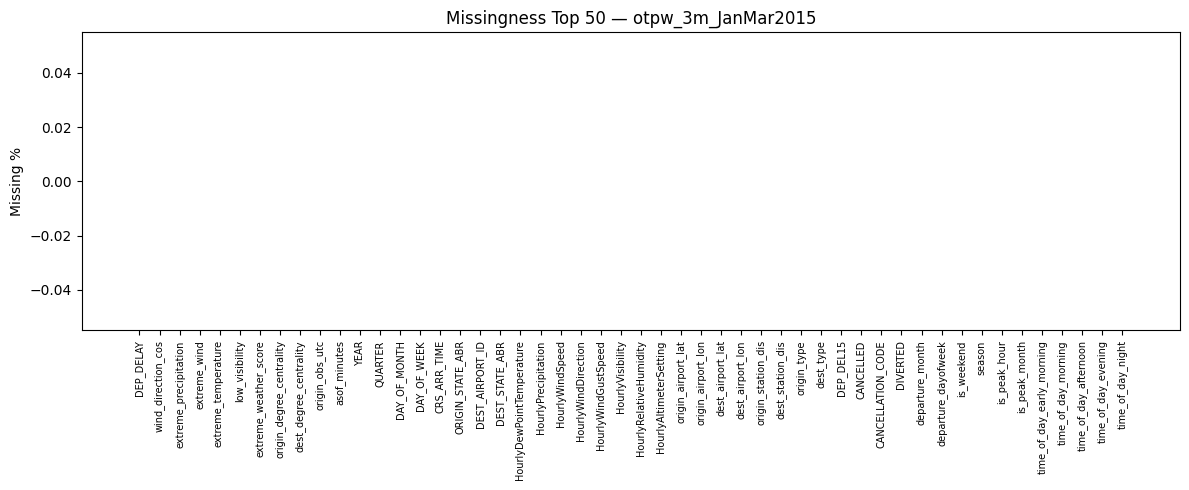

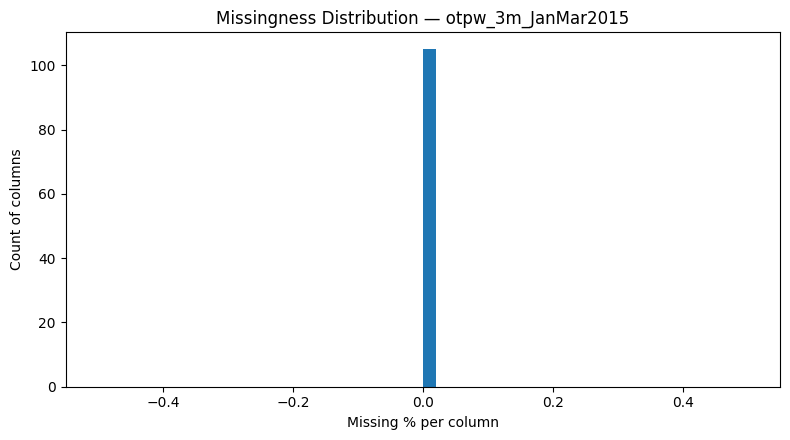

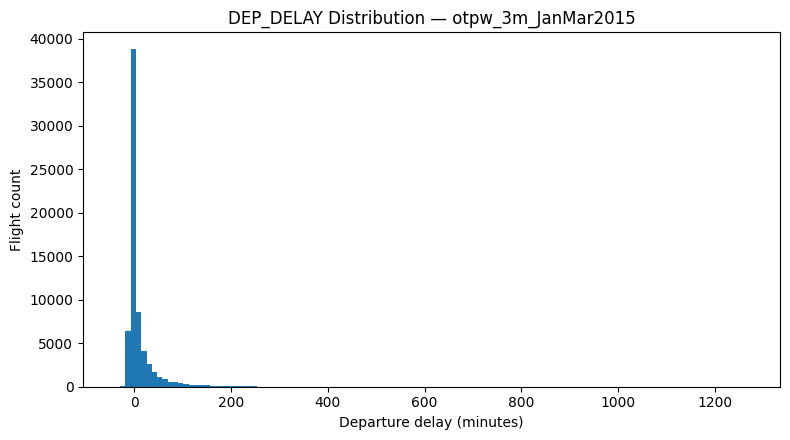

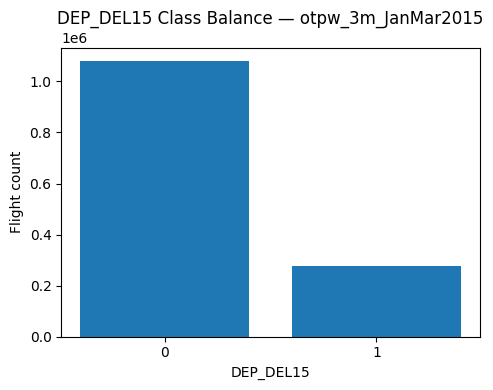

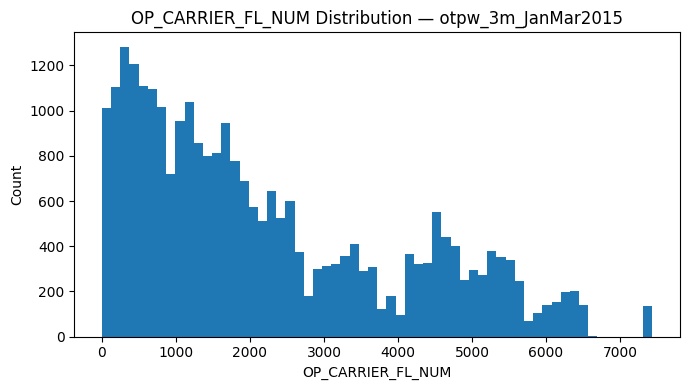

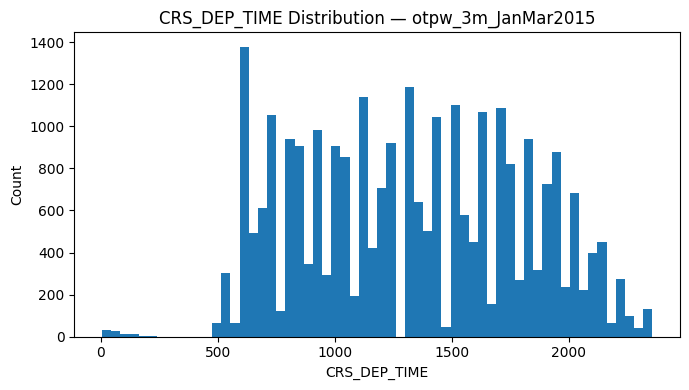

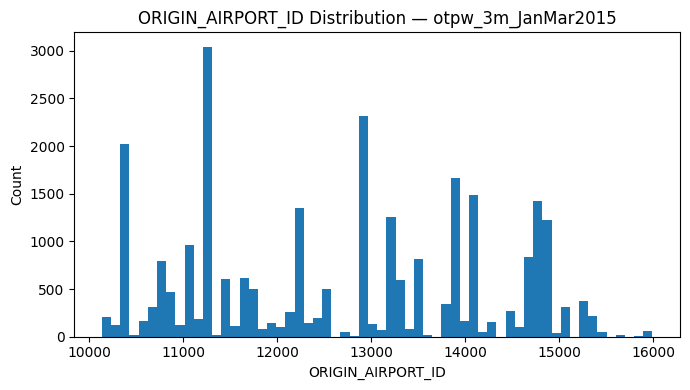

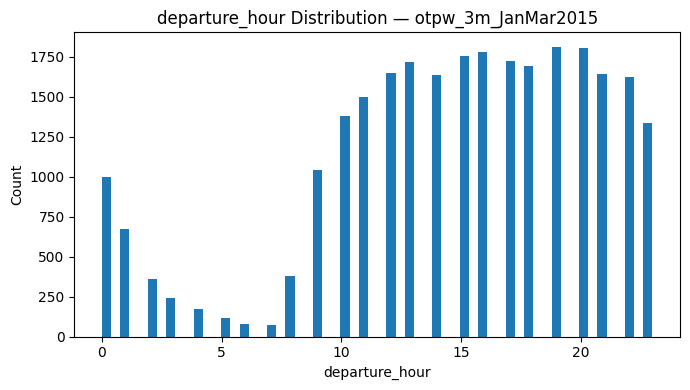

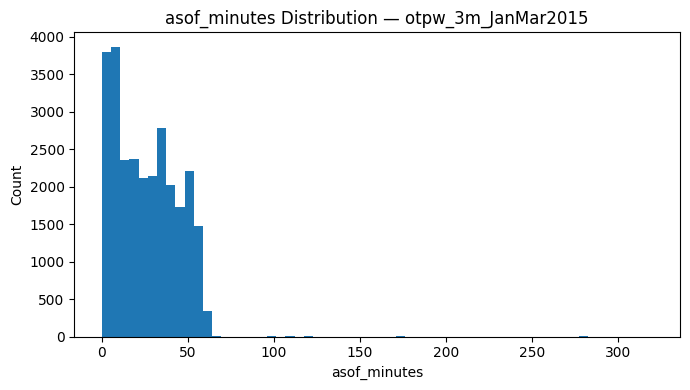

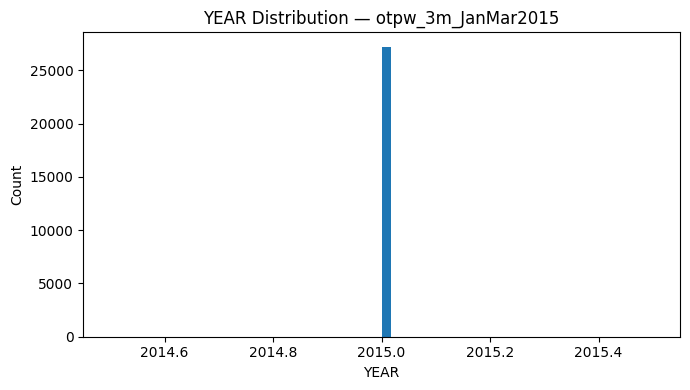

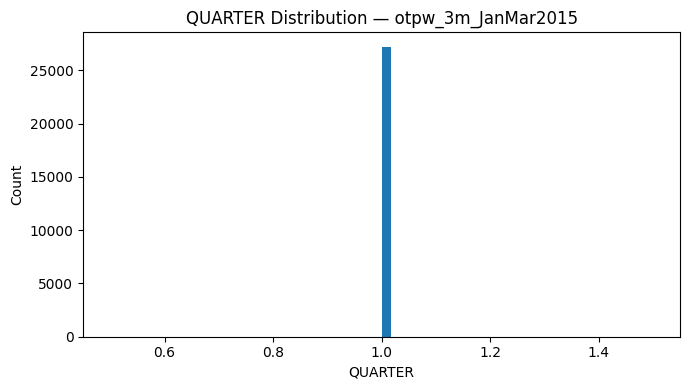

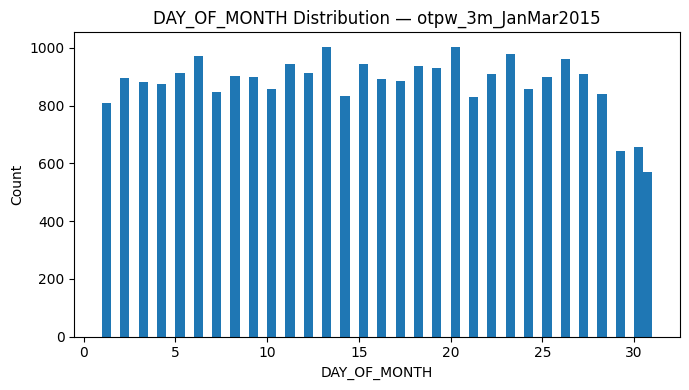

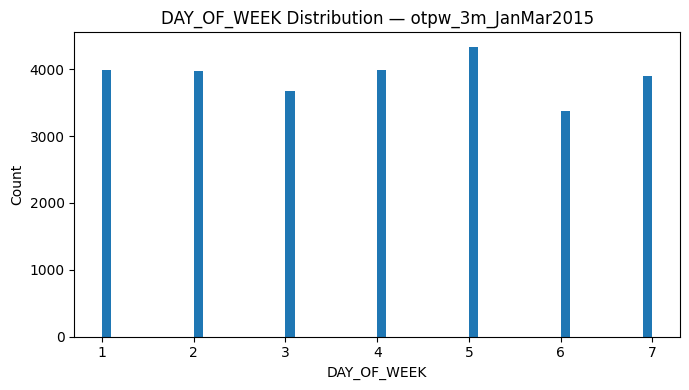

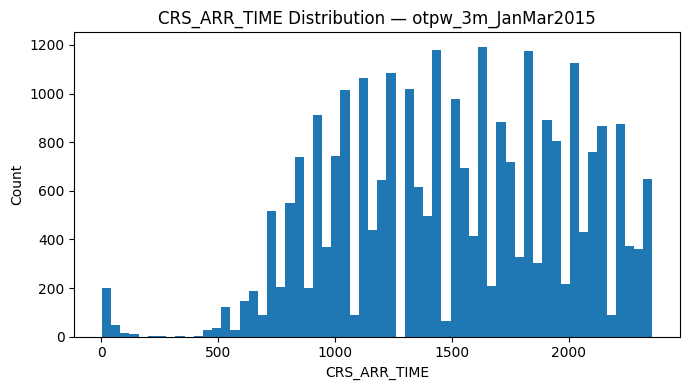

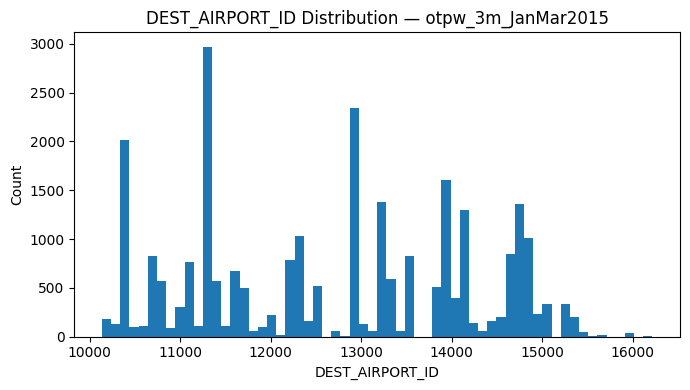

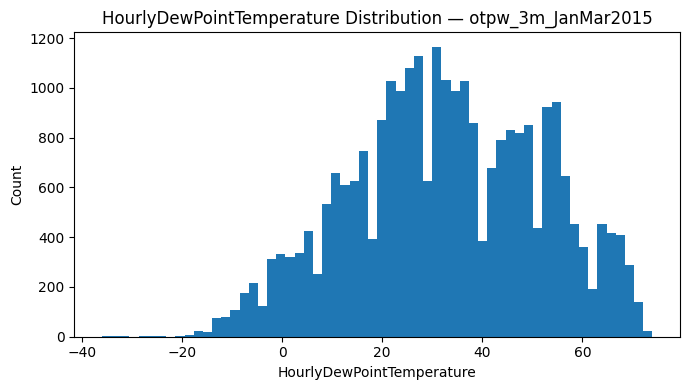

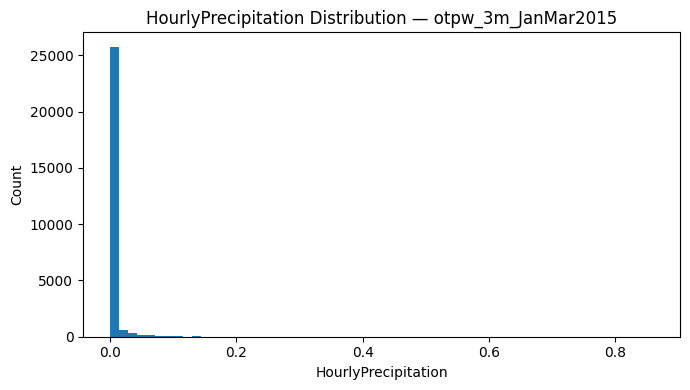

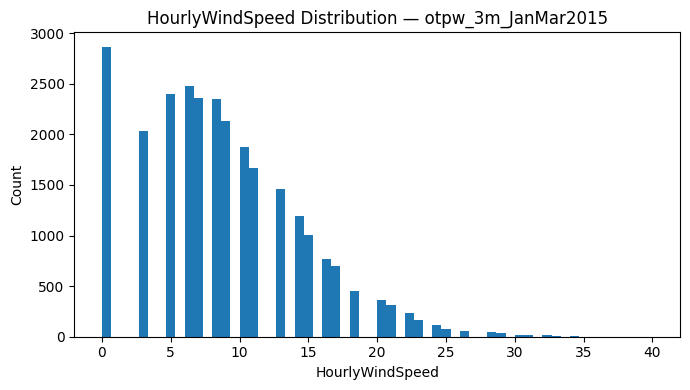

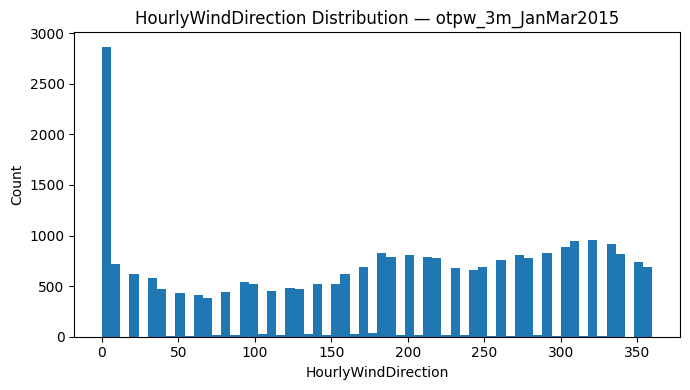

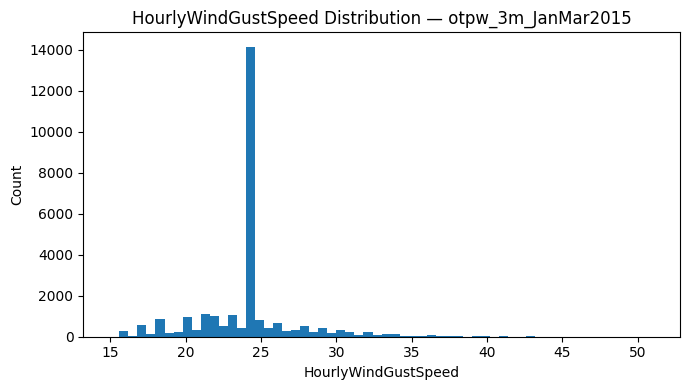

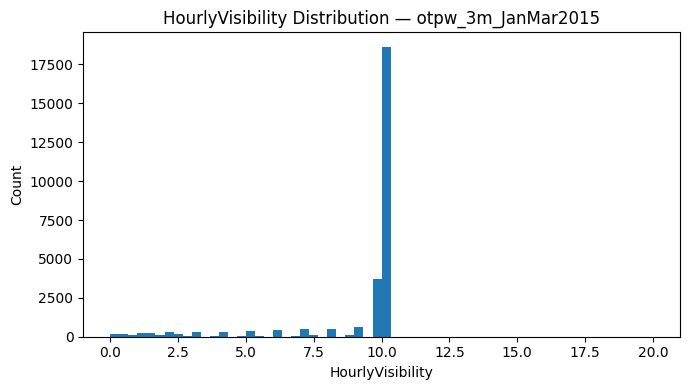

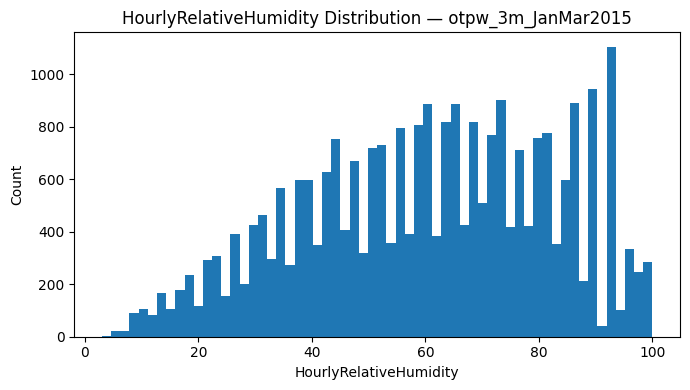

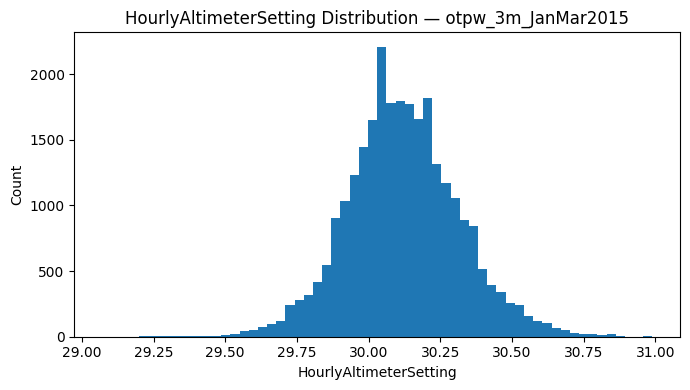

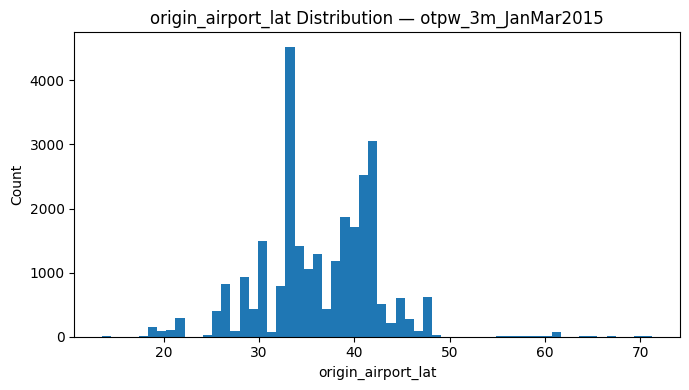

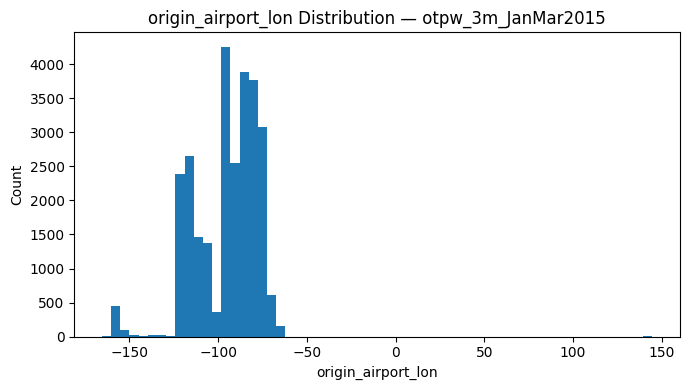

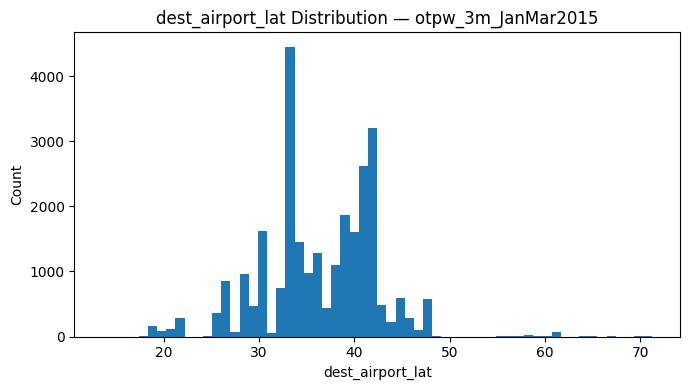

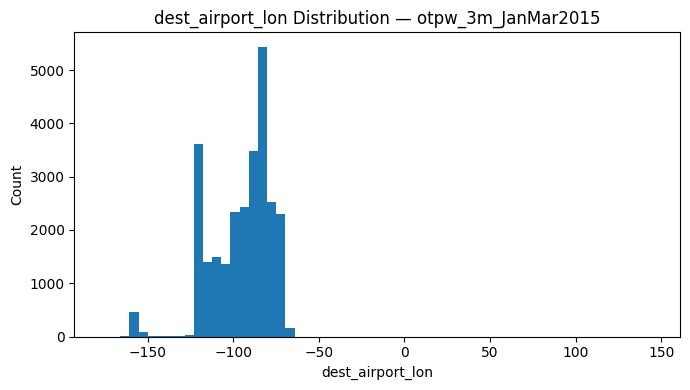

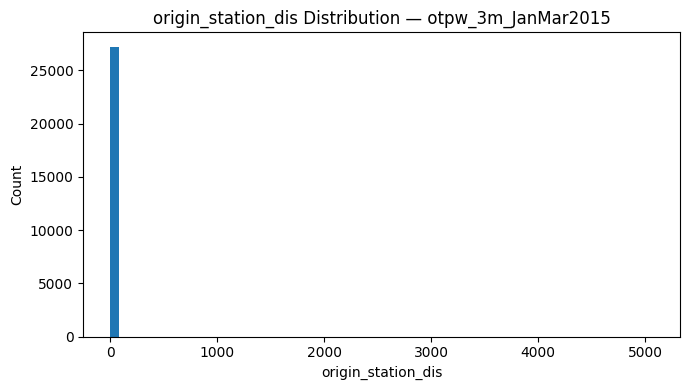

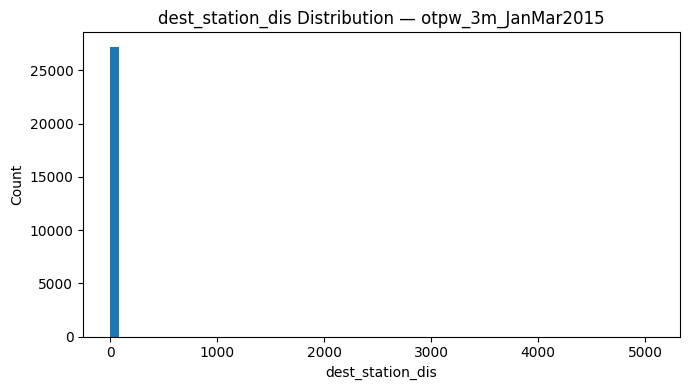

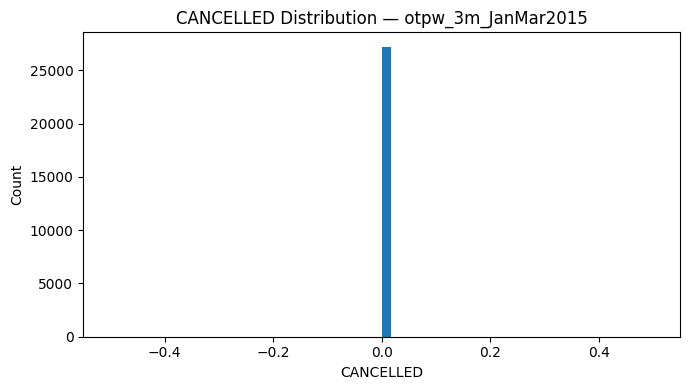

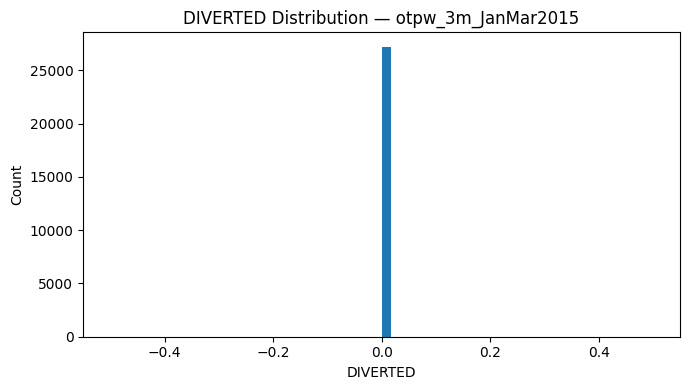

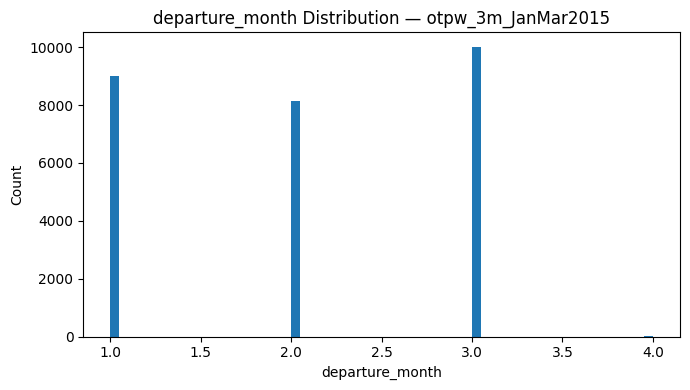

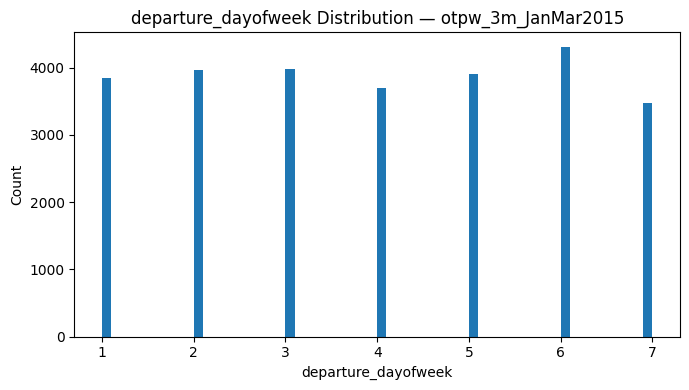

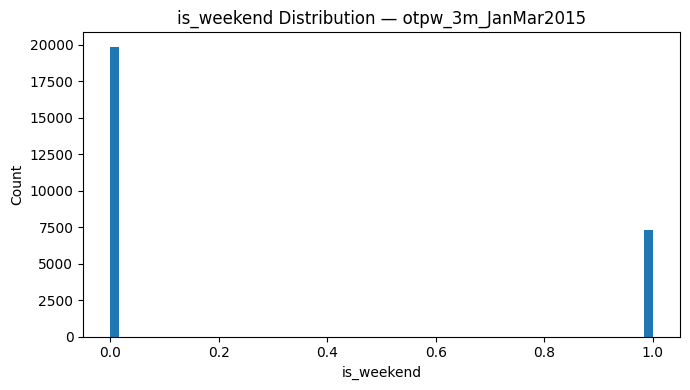

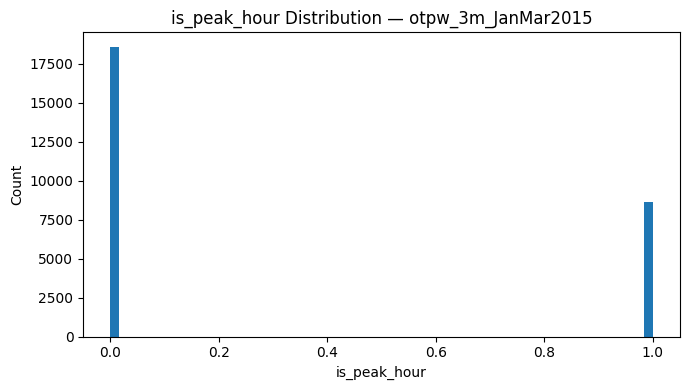

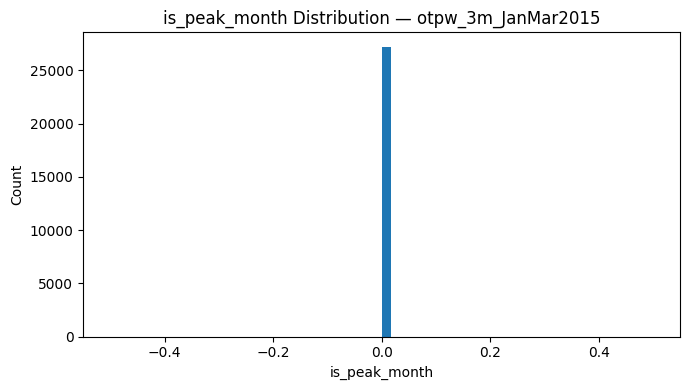

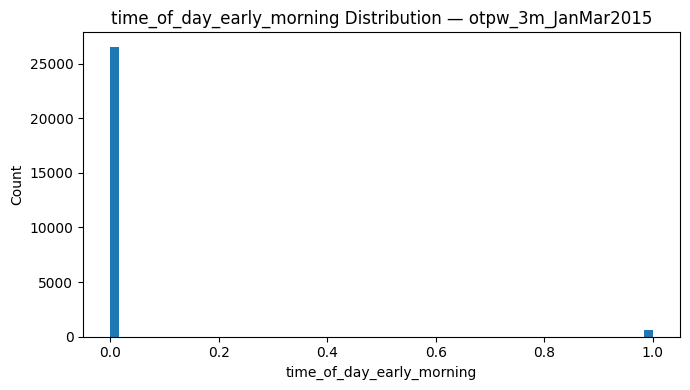

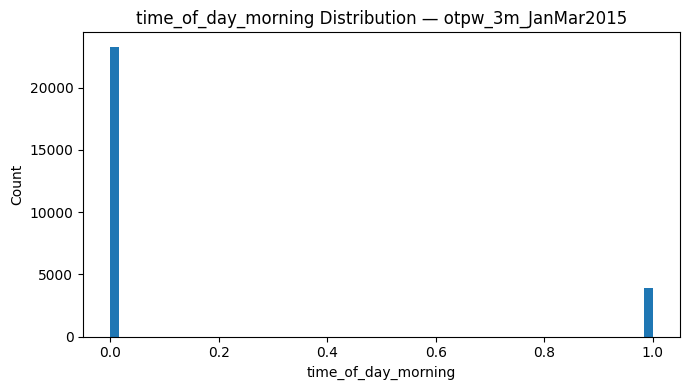

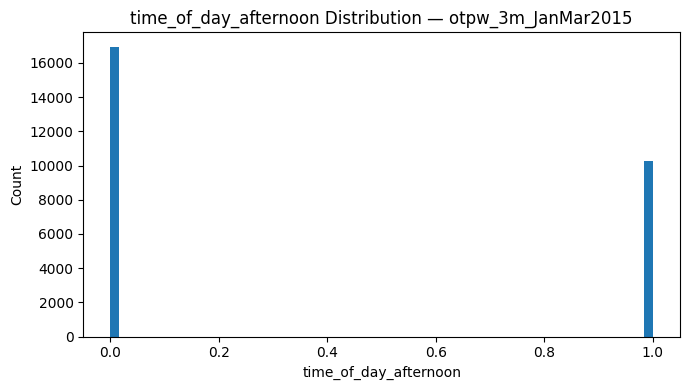

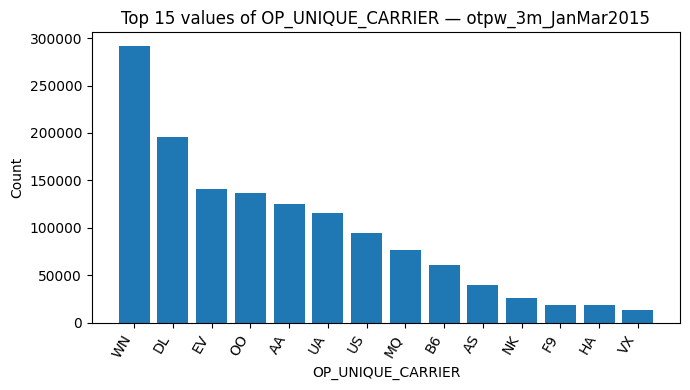

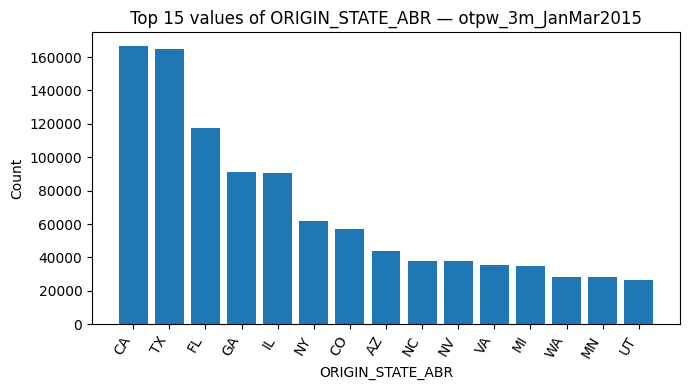

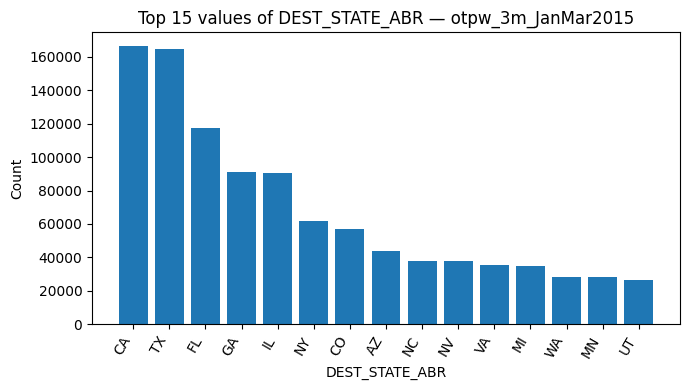

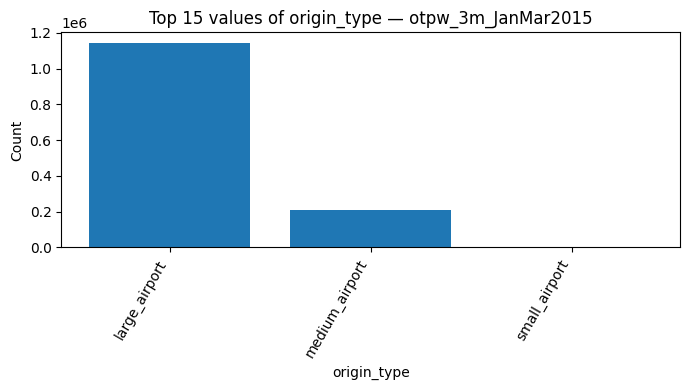

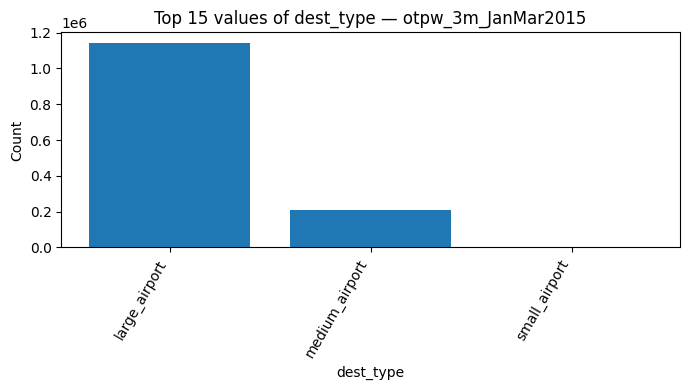

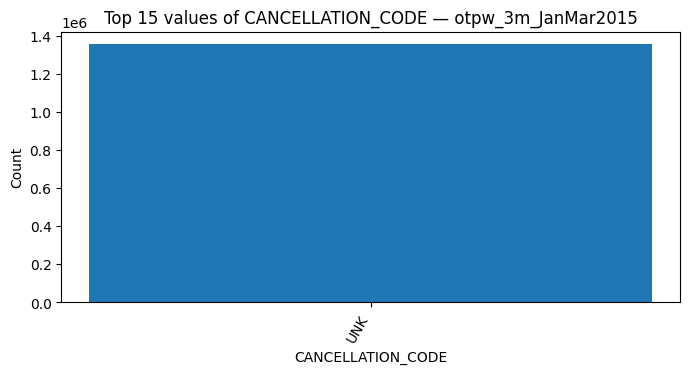

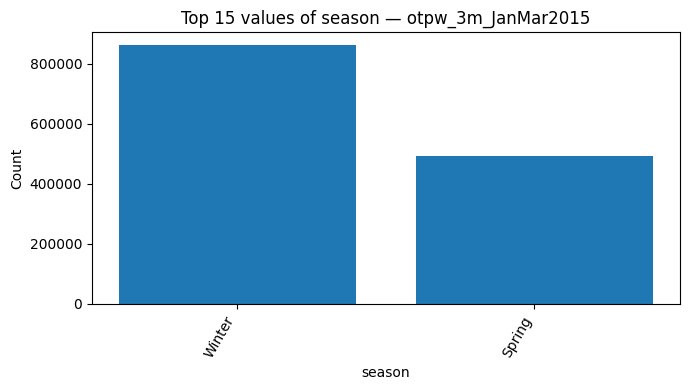

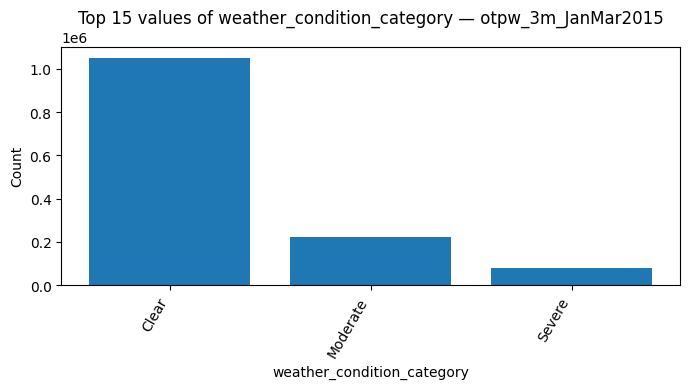

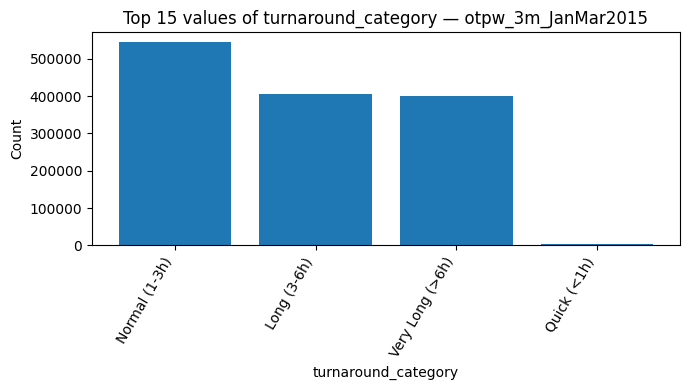

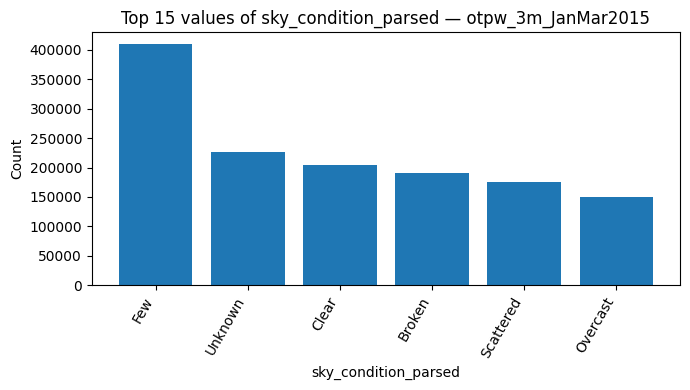

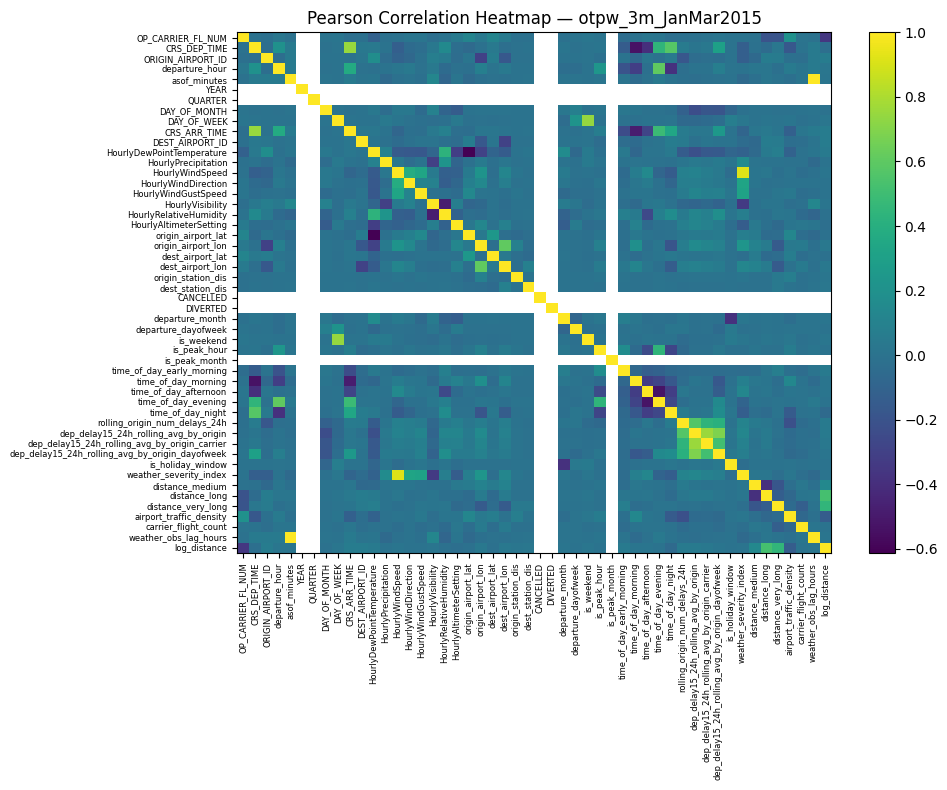

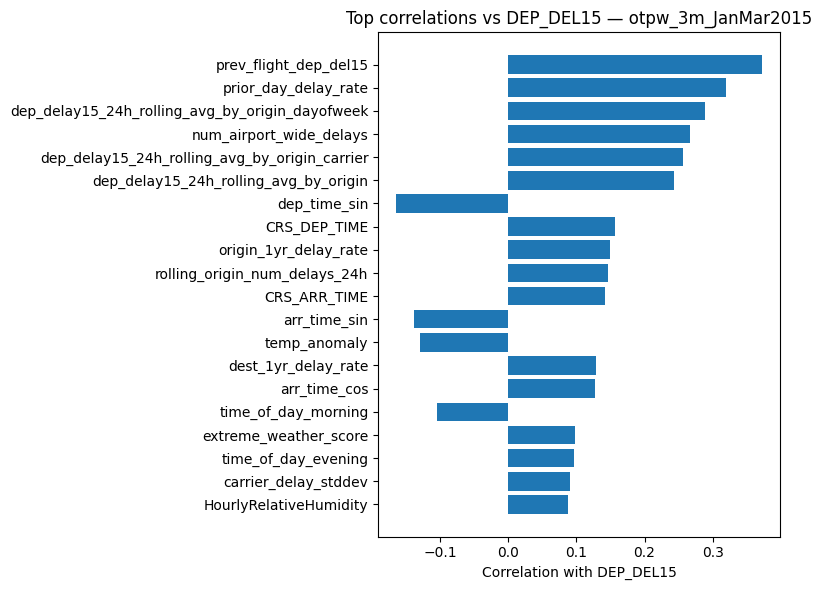

feature point_biserial_corr abs_corr prev_flight_dep_del15 0.3722353852689135 0.3722353852689135 prior_day_delay_rate 0.31983287375960706 0.31983287375960706 dep_delay15_24h_rolling_avg_by_origin_dayofweek 0.28910149341566266 0.28910149341566266 num_airport_wide_delays 0.26663438687962554 0.26663438687962554 dep_delay15_24h_rolling_avg_by_origin_carrier 0.2569661226786256 0.2569661226786256 dep_delay15_24h_rolling_avg_by_origin 0.24399641658310306 0.24399641658310306 dep_time_sin -0.1644839530968709 0.1644839530968709 CRS_DEP_TIME 0.15668590515787065 0.15668590515787065 origin_1yr_delay_rate 0.14864805206326978 0.14864805206326978 rolling_origin_num_delays_24h 0.14596054114679122 0.14596054114679122 CRS_ARR_TIME 0.14241484063986906 0.14241484063986906 arr_time_sin -0.13829829019511852 0.13829829019511852 temp_anomaly -0.13013151856833224 0.13013151856833224 dest_1yr_delay_rate 0.12807647162132352 0.12807647162132352 arr_time_cos 0.1272210326173059 0.1272210326173059 time_of_day_morning -0.10560867683191119 0.10560867683191119 extreme_weather_score 0.0984554817959266 0.0984554817959266 time_of_day_evening 0.09682030777435868 0.09682030777435868 carrier_delay_stddev 0.09092403924148822 0.09092403924148822 HourlyRelativeHumidity 0.08783629900996369 0.08783629900996369 is_rainy 0.08740484580854925 0.08740484580854925 DAY_OF_MONTH -0.08208375518548042 0.08208375518548042 departure_hour 0.07517460937106799 0.07517460937106799 extreme_temperature 0.0673982258031143 0.0673982258031143 time_of_day_night 0.06331697819653473 0.06331697819653473

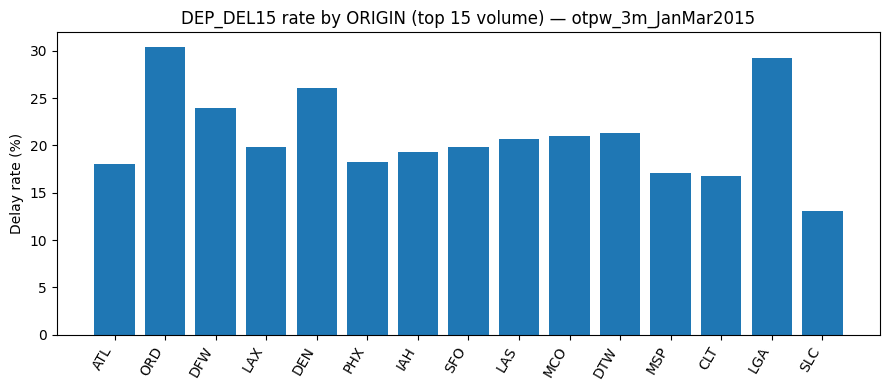

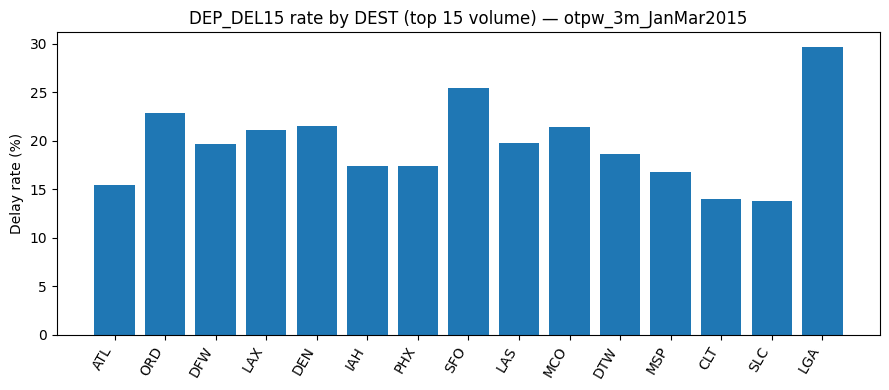

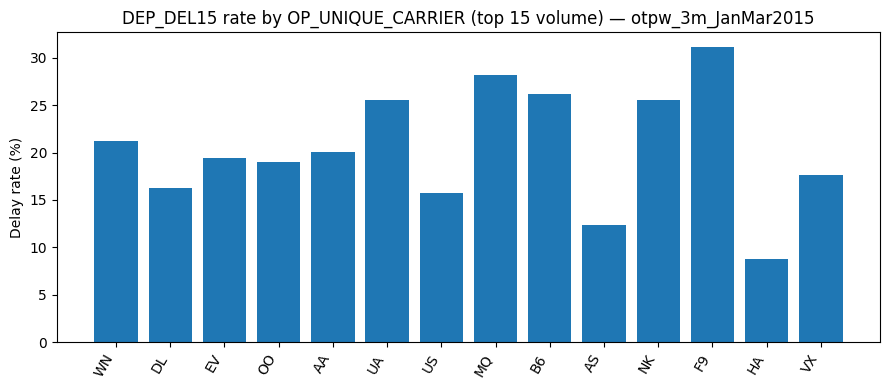

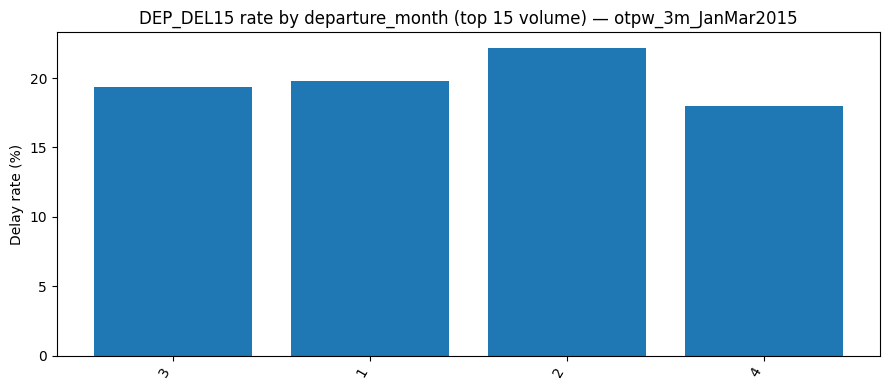

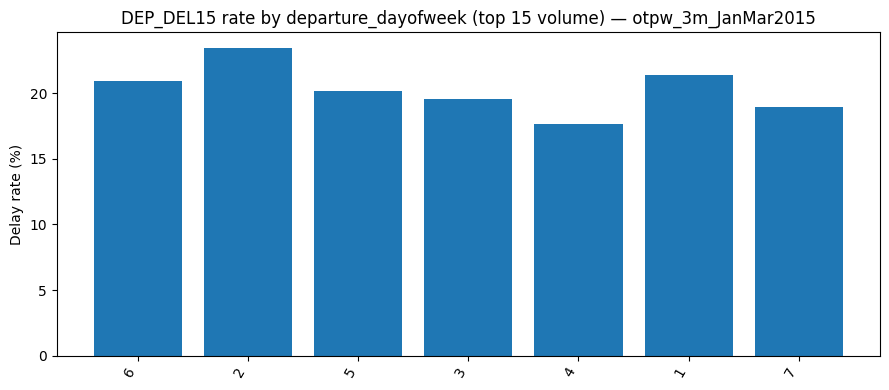

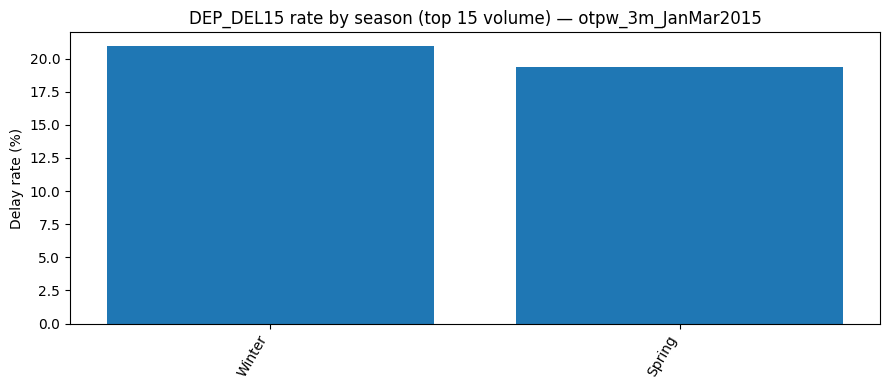

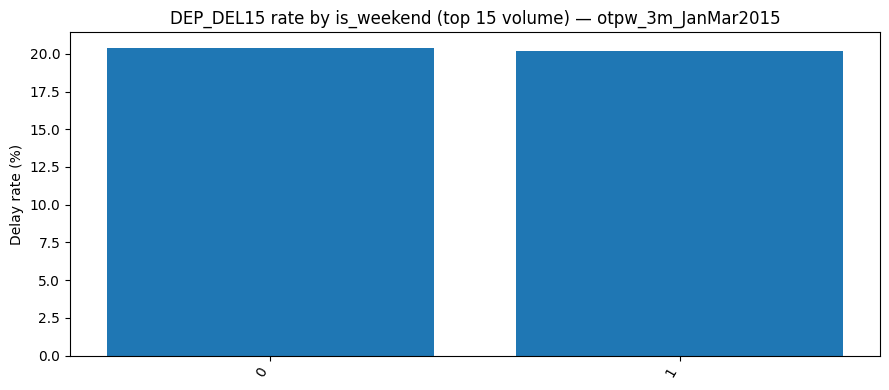

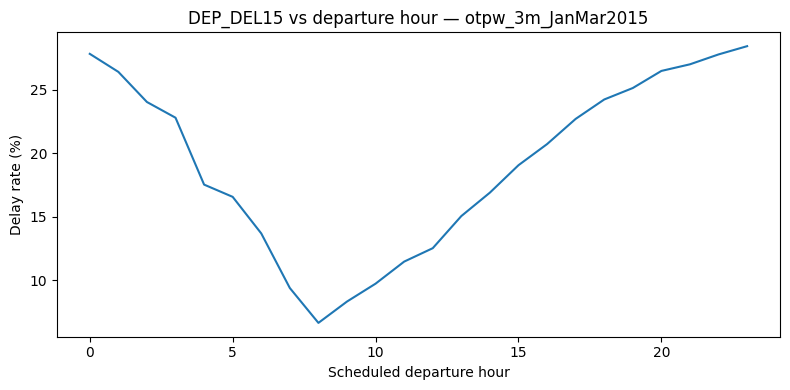

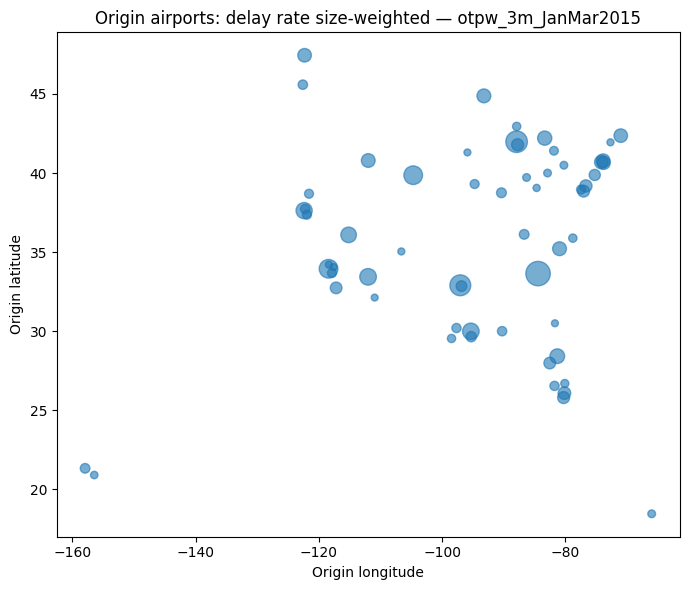

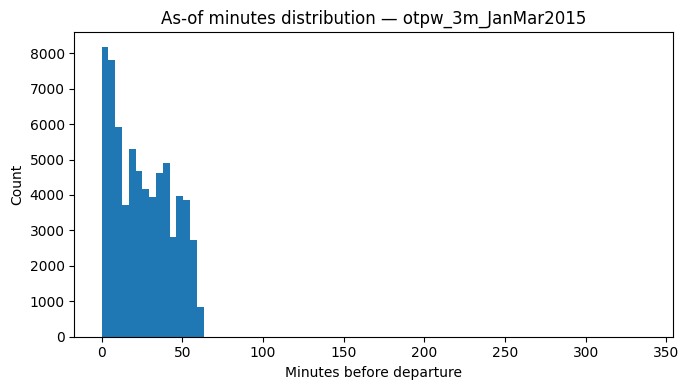

Finished EDA: otpw_3m_JanMar2015 → /dbfs/student-groups/Group_4_4/Charts/phase2_eda/3m

All plots + tables saved under:
  Full-year: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/full
  3-month  : /dbfs/student-groups/Group_4_4/Charts/phase2_eda/3m


In [0]:
# ============================================================
# PHASE 2 EDA — FULL YEAR vs 3-MONTH SIDE-BY-SIDE (ONE CELL)
# Dataset: 2015_final_feature_engineered_data_with_dep_delay
# Outputs saved to /dbfs/student-groups/Group_4_4/Charts/phase2_eda/{full,3m}/
# ============================================================

# -----------------------------
# 0) Imports + Load + Slices
# -----------------------------
import os, math, json, textwrap
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH = "dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay"

df = spark.read.parquet(PATH).cache()
print(f"Rows: {df.count():,} | Cols: {len(df.columns)}")

# Full-year slice (entire 2015 dataset)
otpw_full_df = df.cache()

# 3-month slice (Jan–Mar 2015)
otpw_3m_df = df.filter(
    (F.col("FL_DATE") >= F.lit("2015-01-01")) &
    (F.col("FL_DATE") <  F.lit("2015-04-01"))
).cache()

print("Full-year rows:", otpw_full_df.count())
print("3-month rows:", otpw_3m_df.count())

# Save folders
BASE_LOCAL = "/dbfs/student-groups/Group_4_4/Charts/phase2_eda"
FULL_DIR = f"{BASE_LOCAL}/full"
M3_DIR   = f"{BASE_LOCAL}/3m"
os.makedirs(FULL_DIR, exist_ok=True)
os.makedirs(M3_DIR, exist_ok=True)

# -----------------------------
# 1) Column sets from schema
# -----------------------------
TARGET_NUM = "DEP_DELAY"
TARGET_BIN = "DEP_DEL15"

ID_COLS = {
    "FL_DATE","prediction_utc","origin_obs_utc",
    "OP_CARRIER_FL_NUM","ORIGIN_AIRPORT_ID","DEST_AIRPORT_ID"
}

# Numeric cols (Spark dtypes)
def get_numeric_cols(df, exclude=set()):
    return [c for c,t in df.dtypes
            if t in ("int","bigint","double","float","long") and c not in exclude]

# Categorical cols (small-ish cardinality strings)
def get_categorical_cols(df, exclude=set(), max_card=60):
    cats=[]
    for c,t in df.dtypes:
        if t=="string" and c not in exclude:
            card=df.select(c).distinct().count()
            if card<=max_card:
                cats.append(c)
    return cats

exclude_for_features = {TARGET_NUM, TARGET_BIN}
NUM_COLS_FULL = get_numeric_cols(otpw_full_df, exclude_for_features)
CAT_COLS_FULL = get_categorical_cols(otpw_full_df, exclude_for_features)

# Use same feature lists for 3m (keeps side-by-side consistent)
NUM_COLS_3M = NUM_COLS_FULL
CAT_COLS_3M = CAT_COLS_FULL


# -----------------------------
# 2) Helpers
# -----------------------------
def table_summary(df, name, out_dir):
    rows=df.count()
    cols=len(df.columns)
    min_date, max_date = df.select(F.min("FL_DATE"), F.max("FL_DATE")).first()
    summary = {
        "name": name,
        "rows": rows,
        "cols": cols,
        "min_date": str(min_date),
        "max_date": str(max_date)
    }
    print(f"\n=== {name} ===")
    print(f"Rows: {rows:,} | Cols: {cols}")
    print(f"Date range: {min_date} → {max_date}")
    with open(f"{out_dir}/table_summary_{name}.json","w") as f:
        json.dump(summary,f,indent=2)
    return summary


def missingness_table(df):
    total=df.count()
    miss = (df.select([
                (F.sum(F.when(F.col(c).isNull(),1).otherwise(0))/total).alias(c)
                for c in df.columns
            ])
            .toPandas()
            .T.reset_index()
           )
    miss.columns=["column","missing_pct"]
    miss["missing_pct"]=miss["missing_pct"]*100
    return miss.sort_values("missing_pct",ascending=False)


def plot_missingness(miss_pd, name, out_dir, top_n=50):
    top=miss_pd.head(top_n)
    plt.figure(figsize=(12,5))
    plt.bar(top["column"], top["missing_pct"])
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel("Missing %")
    plt.title(f"Missingness Top {top_n} — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/missing_top{top_n}_{name}.png", dpi=220)
    plt.show()

    plt.figure(figsize=(8,4.5))
    plt.hist(miss_pd["missing_pct"], bins=50)
    plt.xlabel("Missing % per column")
    plt.ylabel("Count of columns")
    plt.title(f"Missingness Distribution — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/missing_hist_{name}.png", dpi=220)
    plt.show()


def plot_target_distributions(df, name, out_dir):
    # DEP_DELAY histogram
    pd_delay = (df.select(TARGET_NUM)
                  .dropna()
                  .sample(0.05, seed=42)
                  .toPandas())
    plt.figure(figsize=(8,4.5))
    plt.hist(pd_delay[TARGET_NUM], bins=120)
    plt.xlabel("Departure delay (minutes)")
    plt.ylabel("Flight count")
    plt.title(f"{TARGET_NUM} Distribution — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/target_{TARGET_NUM}_{name}.png", dpi=220)
    plt.show()

    # DEP_DEL15 balance
    pd_del15 = (df.groupBy(TARGET_BIN).count()
                  .orderBy(TARGET_BIN)
                  .toPandas())
    plt.figure(figsize=(5,4))
    plt.bar(pd_del15[TARGET_BIN].astype(str), pd_del15["count"])
    plt.xlabel(TARGET_BIN)
    plt.ylabel("Flight count")
    plt.title(f"{TARGET_BIN} Class Balance — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/target_{TARGET_BIN}_{name}.png", dpi=220)
    plt.show()


def plot_numeric_distributions(df, name, out_dir, num_cols, sample_frac=0.02, max_plots=35):
    samp=df.sample(sample_frac, seed=42)
    for c in num_cols[:max_plots]:
        pd_s = samp.select(c).dropna().toPandas()
        if pd_s.empty: 
            continue
        plt.figure(figsize=(7,4))
        plt.hist(pd_s[c], bins=60)
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.title(f"{c} Distribution — {name}")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/numdist_{c}_{name}.png", dpi=180)
        plt.show()


def plot_categorical_bars(df, name, out_dir, cat_cols, top_k=15, max_plots=20):
    for c in cat_cols[:max_plots]:
        pd_top = (df.groupBy(c).count()
                    .orderBy(F.desc("count"))
                    .limit(top_k)
                    .toPandas())
        plt.figure(figsize=(7,4))
        plt.bar(pd_top[c].astype(str), pd_top["count"])
        plt.xticks(rotation=60, ha="right")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.title(f"Top {top_k} values of {c} — {name}")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/catbar_{c}_{name}.png", dpi=180)
        plt.show()


def pearson_corr_heatmap(df, cols, name, out_dir):
    assembler = VectorAssembler(inputCols=cols, outputCol="features", handleInvalid="skip")
    vec = assembler.transform(df.select(cols).dropna())
    corr = Correlation.corr(vec, "features", "pearson").head()[0].toArray()
    corr_pd = pd.DataFrame(corr, index=cols, columns=cols)
    corr_pd.to_csv(f"{out_dir}/pearson_corr_{name}.csv")
    plt.figure(figsize=(10,8))
    plt.imshow(corr_pd, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=90, fontsize=6)
    plt.yticks(range(len(cols)), cols, fontsize=6)
    plt.title(f"Pearson Correlation Heatmap — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/pearson_heatmap_{name}.png", dpi=240)
    plt.show()
    return corr_pd


def point_biserial(df, binary_col, num_cols, name, out_dir):
    # corr(binary, numeric) = Pearson with 0/1 target
    results=[]
    samp = df.select([binary_col]+num_cols).dropna()
    for c in num_cols:
        try:
            results.append((c, samp.stat.corr(binary_col, c)))
        except:
            results.append((c, None))
    pb_pd = pd.DataFrame(results, columns=["feature","point_biserial_corr"])
    pb_pd["abs_corr"]=pb_pd["point_biserial_corr"].abs()
    pb_pd = pb_pd.sort_values("abs_corr", ascending=False)
    pb_pd.to_csv(f"{out_dir}/point_biserial_{name}.csv", index=False)

    # plot top 20 abs corr
    top20 = pb_pd.head(20)
    plt.figure(figsize=(8,6))
    plt.barh(top20["feature"][::-1], top20["point_biserial_corr"][::-1])
    plt.xlabel("Correlation with DEP_DEL15")
    plt.title(f"Top correlations vs {binary_col} — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/point_biserial_top20_{name}.png", dpi=220)
    plt.show()

    display(pb_pd.head(25))
    return pb_pd


def plot_delay_rate_by_category(df, cat_col, name, out_dir, top_k=15):
    pd_top = (df.groupBy(cat_col)
                .agg(F.count("*").alias("n"),
                     F.mean(TARGET_BIN).alias("delay_rate"))
                .orderBy(F.desc("n"))
                .limit(top_k)
                .toPandas())
    plt.figure(figsize=(9,4))
    plt.bar(pd_top[cat_col].astype(str), pd_top["delay_rate"]*100)
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Delay rate (%)")
    plt.title(f"{TARGET_BIN} rate by {cat_col} (top {top_k} volume) — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/delayrate_{cat_col}_{name}.png", dpi=220)
    plt.show()


def plot_delay_by_hour(df, name, out_dir):
    # use engineered departure_hour if present, else CRS_DEP_TIME-derived
    if "departure_hour" in df.columns:
        tmp = df.withColumn("dep_hour", F.col("departure_hour"))
    else:
        tmp = df.withColumn("dep_hour", (F.col("CRS_DEP_TIME")/100).cast("int"))

    pd_hour = (tmp.groupBy("dep_hour")
                 .agg(F.count("*").alias("n"),
                      F.mean(TARGET_BIN).alias("delay_rate"))
                 .orderBy("dep_hour")
                 .toPandas())

    plt.figure(figsize=(8,4))
    plt.plot(pd_hour["dep_hour"], pd_hour["delay_rate"]*100)
    plt.xlabel("Scheduled departure hour")
    plt.ylabel("Delay rate (%)")
    plt.title(f"{TARGET_BIN} vs departure hour — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/delayrate_hour_{name}.png", dpi=220)
    plt.show()


def plot_geo_delay(df, name, out_dir, top_k=60):
    # average delay rate by origin, plotted on lat/lon
    pd_geo = (df.groupBy("ORIGIN","origin_airport_lat","origin_airport_lon")
                .agg(F.count("*").alias("n"),
                     F.mean(TARGET_BIN).alias("delay_rate"))
                .filter(F.col("origin_airport_lat").isNotNull() & F.col("origin_airport_lon").isNotNull())
                .orderBy(F.desc("n"))
                .limit(top_k)
                .toPandas())

    plt.figure(figsize=(7,6))
    plt.scatter(pd_geo["origin_airport_lon"], pd_geo["origin_airport_lat"],
                s=(pd_geo["n"]/pd_geo["n"].max())*300 + 10,
                alpha=0.6)
    plt.xlabel("Origin longitude")
    plt.ylabel("Origin latitude")
    plt.title(f"Origin airports: delay rate size-weighted — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/geo_origin_delay_{name}.png", dpi=220)
    plt.show()


def plot_asof_minutes(df, name, out_dir):
    pd_asof = (df.select("asof_minutes")
                 .dropna()
                 .sample(0.05, seed=42)
                 .toPandas())
    plt.figure(figsize=(7,4))
    plt.hist(pd_asof["asof_minutes"], bins=80)
    plt.xlabel("Minutes before departure")
    plt.ylabel("Count")
    plt.title(f"As-of minutes distribution — {name}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/asof_minutes_{name}.png", dpi=220)
    plt.show()


def run_slice_eda(df_slice, name, out_dir, num_cols, cat_cols):
    # A) Table summary
    table_summary(df_slice, name, out_dir)

    # B) Missingness
    miss_pd = missingness_table(df_slice)
    miss_pd.to_csv(f"{out_dir}/missing_table_{name}.csv", index=False)
    plot_missingness(miss_pd, name, out_dir)

    # C) Targets
    plot_target_distributions(df_slice, name, out_dir)

    # D) Feature distributions
    plot_numeric_distributions(df_slice, name, out_dir, num_cols)
    plot_categorical_bars(df_slice, name, out_dir, cat_cols)

    # E) Correlations
    heat_cols = num_cols[:50]
    pearson_corr_heatmap(df_slice, heat_cols, name, out_dir)
    point_biserial(df_slice, TARGET_BIN, num_cols, name, out_dir)

    # F) Pair/group patterns
    for col in ["ORIGIN","DEST","OP_UNIQUE_CARRIER","departure_month","departure_dayofweek","season","is_weekend"]:
        if col in df_slice.columns:
            plot_delay_rate_by_category(df_slice, col, name, out_dir)

    plot_delay_by_hour(df_slice, name, out_dir)

    # G) Novel vis
    plot_geo_delay(df_slice, name, out_dir)
    plot_asof_minutes(df_slice, name, out_dir)

    print(f"Finished EDA: {name} → {out_dir}")


# -----------------------------
# 3) Run EDA side-by-side
# -----------------------------
print("\n\n" + "="*90)
print("RUNNING FULL-YEAR EDA")
print("="*90)
run_slice_eda(
    otpw_full_df, 
    name="otpw_full_2015",
    out_dir=FULL_DIR,
    num_cols=NUM_COLS_FULL,
    cat_cols=CAT_COLS_FULL
)

print("\n\n" + "="*90)
print("RUNNING 3-MONTH EDA")
print("="*90)
run_slice_eda(
    otpw_3m_df, 
    name="otpw_3m_JanMar2015",
    out_dir=M3_DIR,
    num_cols=NUM_COLS_3M,
    cat_cols=CAT_COLS_3M
)

print("\nAll plots + tables saved under:")
print("  Full-year:", FULL_DIR)
print("  3-month  :", M3_DIR)


Correlation Analysis Approach

Our dataset contains two target variables:

DEP_DEL15 (binary indicator of a 15+ minute delay)

DEP_DELAY (continuous delay magnitude in minutes)

Because these targets have different statistical properties, we used different correlation methods:

1. DEP_DEL15 (binary): Point-Biserial Correlation
We used point-biserial correlation, which is equivalent to Pearson correlation when one variable is 0/1. This measures the strength of association between each numeric feature and the likelihood that a flight is delayed. This gives a ranked list of features most predictive of delays.

2. DEP_DELAY (continuous): Pearson + Spearman Correlations
DEP_DELAY is continuous, skewed, and highly nonlinear.

Pearson correlation captures linear relationships.

Spearman correlation captures monotonic, nonlinear relationships by ranking variables before computing correlation.

Using both gives a fuller understanding of which operational, temporal, and weather features move with delay duration.